# DDM Model Fitting with Dual-Prior Support

This notebook demonstrates fitting of Drift Diffusion Models (DDM) using the optimized implementation that supports dual-prior conditions (equal vs unequal prior blocks).

## Key Features:
- **Dual-prior support**: Separate parameters for equal and unequal prior conditions
- **Optimized performance**: CUDA acceleration and efficient NumPy/PyTorch operations  
- **Robust fitting**: Multi-stage optimization with differential evolution
- **Parameter structure**: 
  - Global parameters: `ndt`, `drift_gain`, `variance`, `leak_rate`, `time_constant`
  - Condition-specific: `a_1/a_2`, `z_1/z_2`, `drift_offset_1/drift_offset_2`

In [98]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import pickle
from pathlib import Path

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

from src.utils import pmf_utils
from config import dir_config
import time

In [100]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)
ddm_dir = Path(dir_config.data.processed, "ddm")

ENABLE_LEAK = True
ENABLE_TIME_DEPENDENCY = True
MODEL_TYPE = "three_param_vary"

In [ ]:
model_folder = f"ddm_leak_{ENABLE_LEAK}_urgency_{ENABLE_TIME_DEPENDENCY}"
model_dir = Path(ddm_dir, model_folder)

## Helper functions

In [ ]:
def simulate_ddm(idx_prior, model, result_dict, stimulus)
    """
    Simulate DDM for a specific prior condition using fitted parameters.

    Args:
        idx_prior: 0 for 'equal' prior, 1 for 'unequal' prior
        model: The fitted DecisionModel instance
        result_dict: Dictionary containing fitted parameters
        stimulus: Stimulus array for this prior condition
        enable_leak: Whether leak was enabled in fitting
        enable_time_dependence: Whether time dependence was enabled in fitting

    Returns:
        DataFrame with simulated data
    """
    # Get parameters from the result dictionary
    parameters = result_dict["parameters"]

    for param_name, param_value in parameters.items():
        if param_name.endswith(f"_{idx_prior + 1}"):
            # Prior-specific parameter (remove suffix)
            base_name = param_name[:-2]
            setattr(model.simulator, base_name, param_value)
            print(f"{base_name} (prior {idx_prior + 1}): {param_value:.4f}")
        elif "_" not in param_name or not param_name[-1].isdigit():
            # Global parameter
            setattr(model.simulator, param_name, param_value)
            print(f"{param_name} (global): {param_value:.4f}")

    # Simulate trials using the model's simulate method
    sim_result = model.simulate(stimulus, n_reps=1)

    # Create DataFrame of simulated data
    model_sim = pd.DataFrame(
        {
            "signed_coherence": sim_result["coherence"] * 100,  # Convert back to original scale
            "choice": sim_result["choice"],
            "rt": sim_result["rt"],
        }
    )
    model_sim["outcome"] = np.where((model_sim["choice"]*2-1) == np.sign(model_sim["signed_coherence"]), 1, 0)
    model_sim["outcome"][model_sim["signed_coherence"] == 0] = np.random.choice([0, 1], size=np.sum(model_sim["signed_coherence"] == 0))

    return model_sim


def plot_ddm_fit(model_sim, data):

    # if data has column name rt change it to response_time
    if "rt" in data.columns:
        data = data.rename(columns={"rt": "response_time"})
    if "rt" in model_sim.columns:
        model_sim = model_sim.rename(columns={"rt": "response_time"})

    # Plotting
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3)


    # Get psychometric and chronometric data for both real and simulated data
    x_data, y_data, _, _, _ = pmf_utils.get_psychometric_data(data)
    x_fit, y_fit, _, _, _ = pmf_utils.get_psychometric_data(model_sim)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x_data, y_data, "o", color="k", label="data")
    ax1.plot(x_fit, y_fit, "o", color="b", label="model")
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend()
    ax1.set_title("Psychometric Function")

    # Chronometric plot (RT means)
    _, rt_median, rt_mean, rt_sd, _ = pmf_utils.get_chronometric_data(data, outcome=1)
    model_coh, rt_median_fit, rt_mean_fit, rt_sd_fit, _ = pmf_utils.get_chronometric_data(model_sim, outcome=1)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x_data, rt_mean, "o", color="k", label="data")
    ax2.fill_between(x_data, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
    ax2.fill_between(model_coh, rt_mean_fit - rt_sd_fit, rt_mean_fit + rt_sd_fit, color="b", alpha=0.2)
    ax2.plot(model_coh, rt_mean_fit, "o", color="b", label="model", markersize=8)
    ax2.legend()
    ax2.set_xlabel("Signed Coherence (%)")
    ax2.set_ylabel("Response Time (s)")
    ax2.set_xlim(-50, 50)
    ax2.set_title("Chronometric Function (Correct Trials)")

    # Chronometric plot (RT means)
    coh, rt_median, rt_mean, rt_sd, _ = pmf_utils.get_chronometric_data(data, outcome=0)
    coh_fit, rt_median_fit, rt_mean_fit, rt_sd_fit, _ = pmf_utils.get_chronometric_data(model_sim, outcome=0)

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(coh, rt_mean, "o", color="k", label="data")
    ax3.fill_between(coh, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
    ax3.plot(coh_fit, rt_mean_fit, "o", color="b", label="model", markersize=8)
    ax3.fill_between(coh_fit, rt_mean_fit - rt_sd_fit, rt_mean_fit + rt_sd_fit, color="b", alpha=0.2)
    ax3.legend()
    ax3.set_title("Chronometric Function (Incorrect Trials)")
    ax3.set_xlabel("Signed Coherence (%)")
    ax3.set_ylabel("Response Time (s)")
    ax3.set_xlim(-50, 50)

    plt.tight_layout()
    plt.show()

    # Print proportion of invalid trials (NaN choices)
    print("Proportion of invalid trials:", np.mean(np.isnan(model_sim["choice"])))

    # return model_sim, ddm


## import data

In [ ]:
behavior_df = pd.read_csv(Path(ddm_dir, "behavior_data.csv"))

if MODEL_TYPE == "three_param_vary":
    model_files = [f for f in list(model_dir.glob("*.pkl")) if f.is_file() and "_prior" not in f.name]
elif MODEL_TYPE == "all_param_vary":
    model_files = [f for f in list(model_dir.glob("*.pkl")) if f.is_file() and "_prior" in f.name]
model_files.sort()

print("Total model files found:", len(model_files))


Total model files found: 28



Session: 210126_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 448 trials
ndt (global): 0.2399
drift_gain (global): 11.1183
variance (global): 2.4168
a (prior 1): 5.0351
z (prior 1): 0.3649
drift_offset (prior 1): 0.8848
leak_rate (global): 0.5238
time_constant (global): 0.0161

Simulation completed. Generated 448 trials.
Valid simulated trials: 448


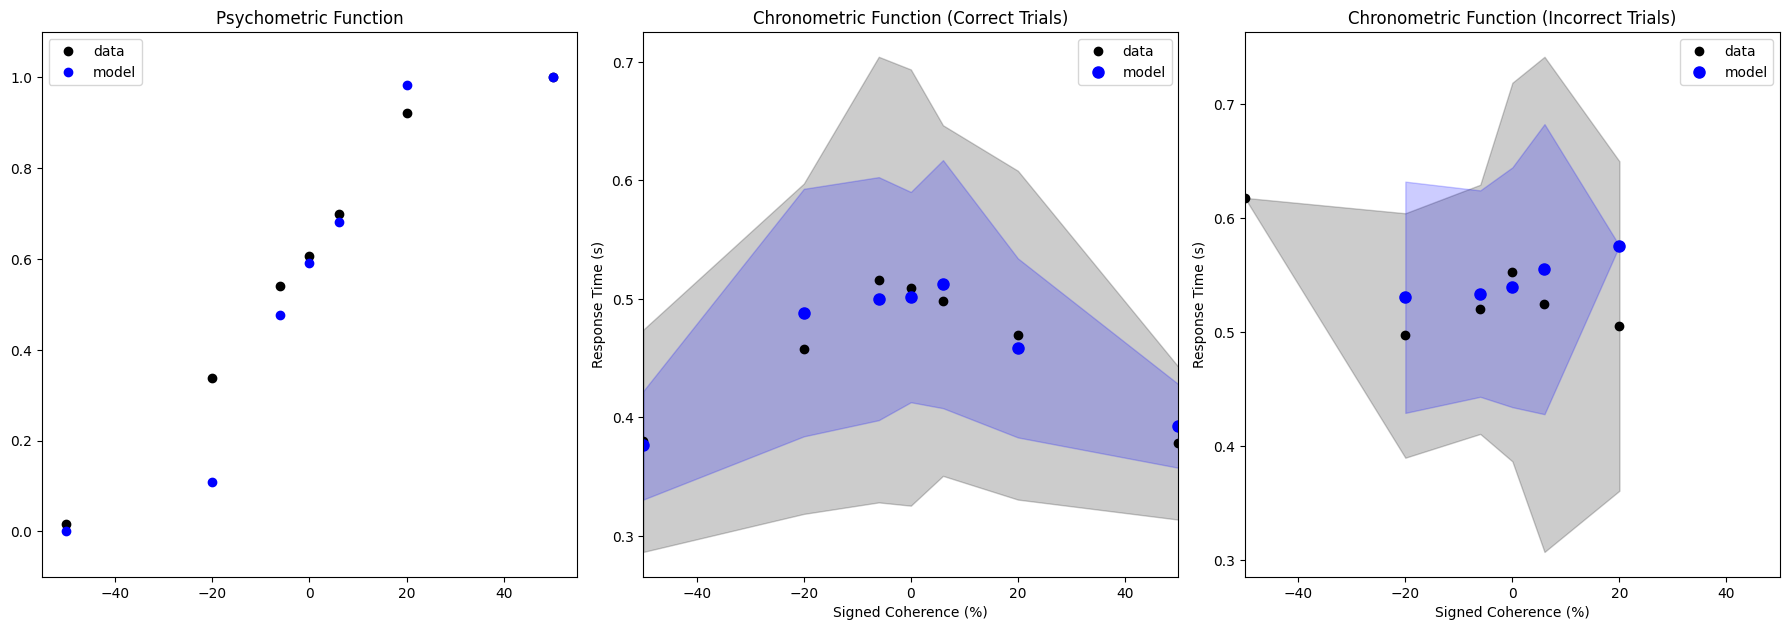

Proportion of invalid trials: 0.0

Session: 210126_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 613 trials
ndt (global): 0.2399
drift_gain (global): 11.1183
variance (global): 2.4168
a (prior 2): 4.7785
z (prior 2): 0.5005
drift_offset (prior 2): -1.2265
leak_rate (global): 0.5238
time_constant (global): 0.0161

Simulation completed. Generated 613 trials.
Valid simulated trials: 613


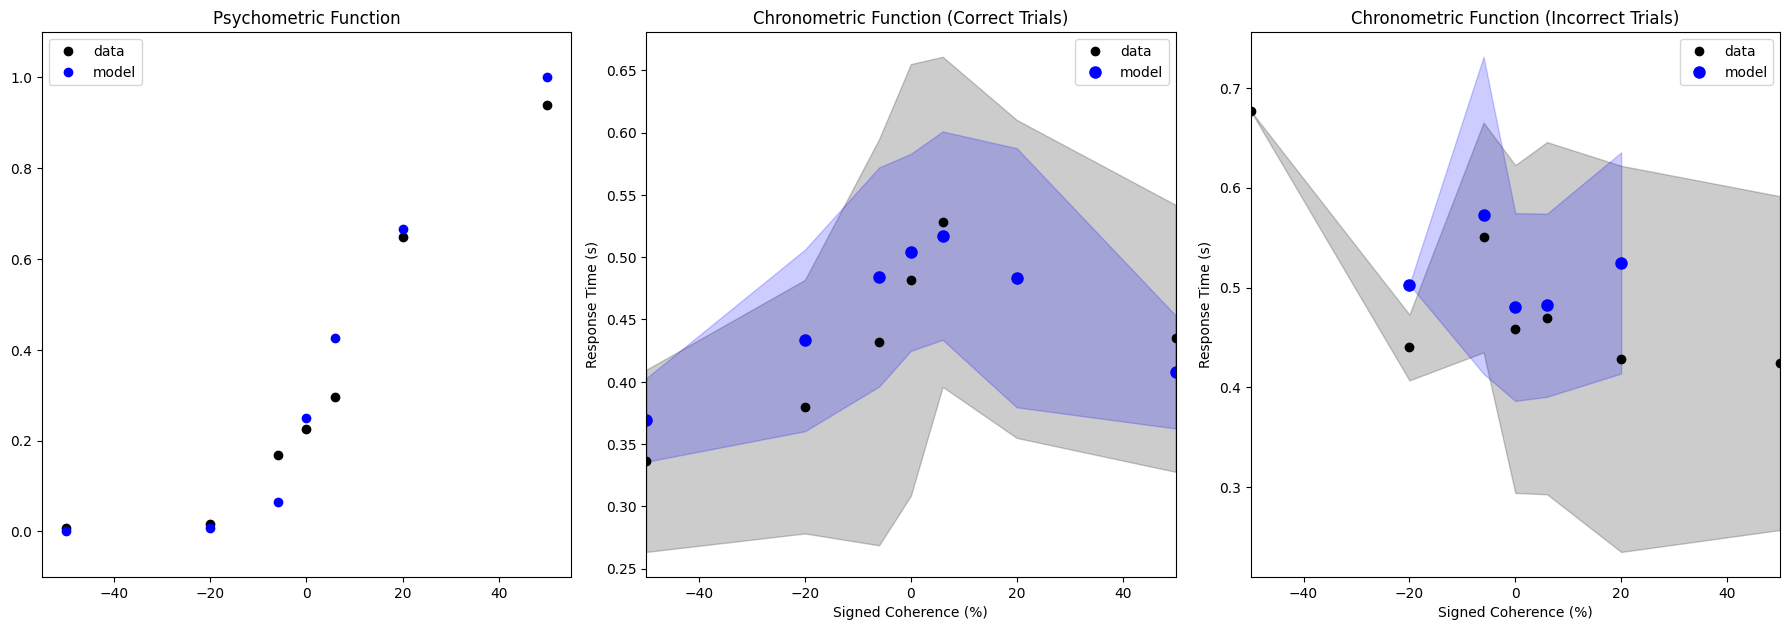

Proportion of invalid trials: 0.0

Session: 210210_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 334 trials
ndt (global): 0.2037
drift_gain (global): 7.0979
variance (global): 3.4302
a (prior 1): 5.4576
z (prior 1): 0.2833
drift_offset (prior 1): -0.0202
leak_rate (global): 0.2560
time_constant (global): 0.0040

Simulation completed. Generated 334 trials.
Valid simulated trials: 334


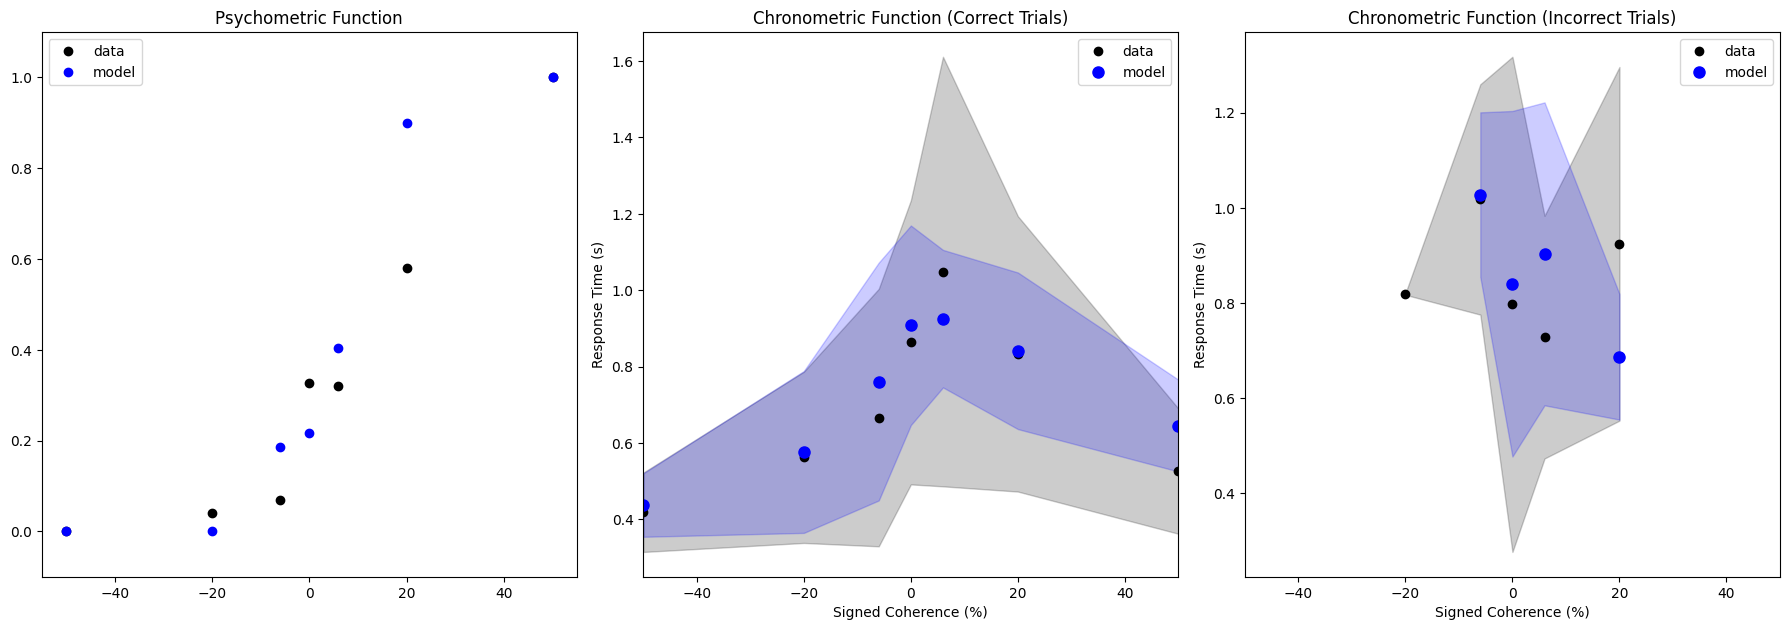

Proportion of invalid trials: 0.0

Session: 210210_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 589 trials
ndt (global): 0.2037
drift_gain (global): 7.0979
variance (global): 3.4302
a (prior 2): 5.4696
z (prior 2): 0.2153
drift_offset (prior 2): 0.3496
leak_rate (global): 0.2560
time_constant (global): 0.0040

Simulation completed. Generated 589 trials.
Valid simulated trials: 589


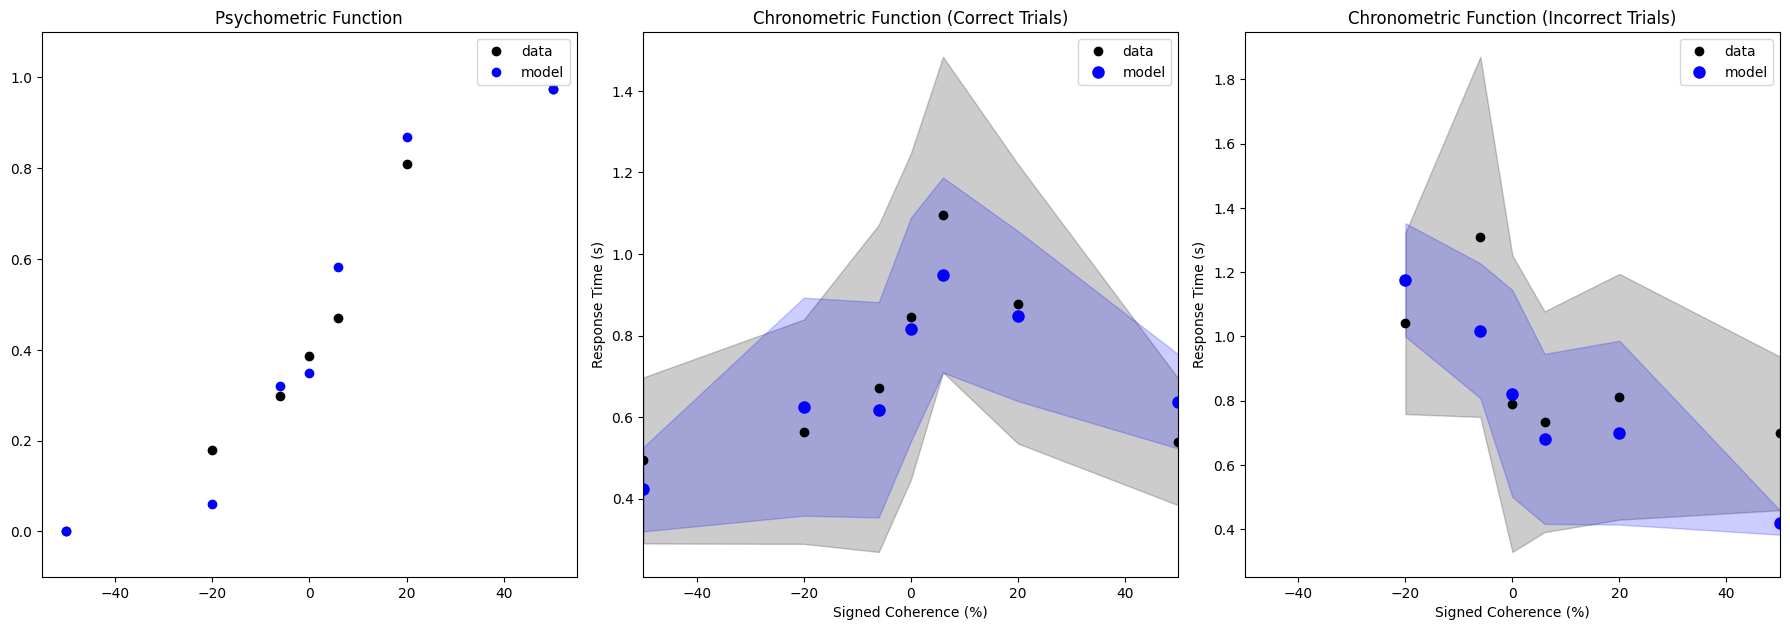

Proportion of invalid trials: 0.0

Session: 210217_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 399 trials
ndt (global): 0.1843
drift_gain (global): 5.1151
variance (global): 2.7038
a (prior 1): 5.2312
z (prior 1): 0.1918
drift_offset (prior 1): 1.1230
leak_rate (global): 0.3577
time_constant (global): 0.0031

Simulation completed. Generated 399 trials.
Valid simulated trials: 399


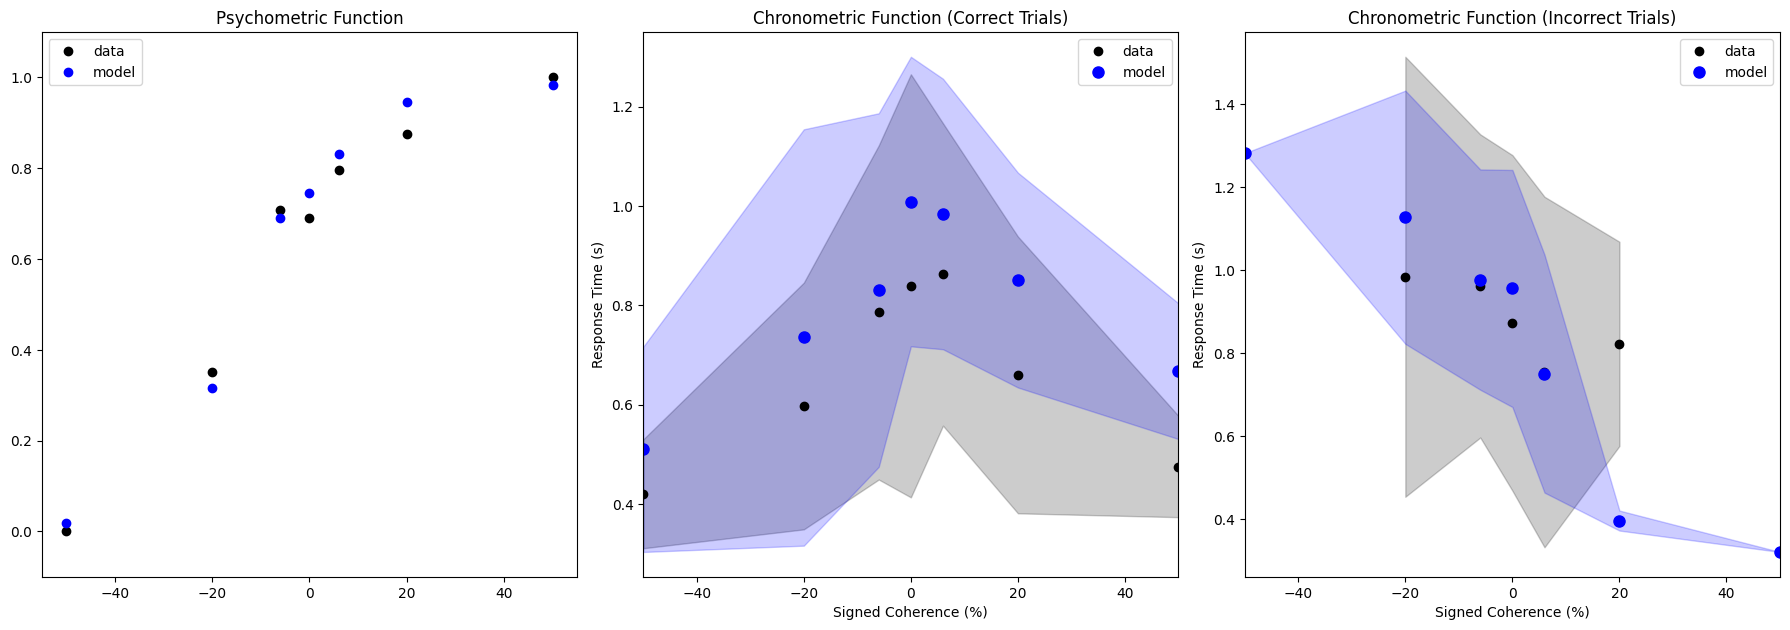

Proportion of invalid trials: 0.0

Session: 210217_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 593 trials
ndt (global): 0.1843
drift_gain (global): 5.1151
variance (global): 2.7038
a (prior 2): 5.4367
z (prior 2): 0.1693
drift_offset (prior 2): 0.2276
leak_rate (global): 0.3577
time_constant (global): 0.0031

Simulation completed. Generated 593 trials.
Valid simulated trials: 593


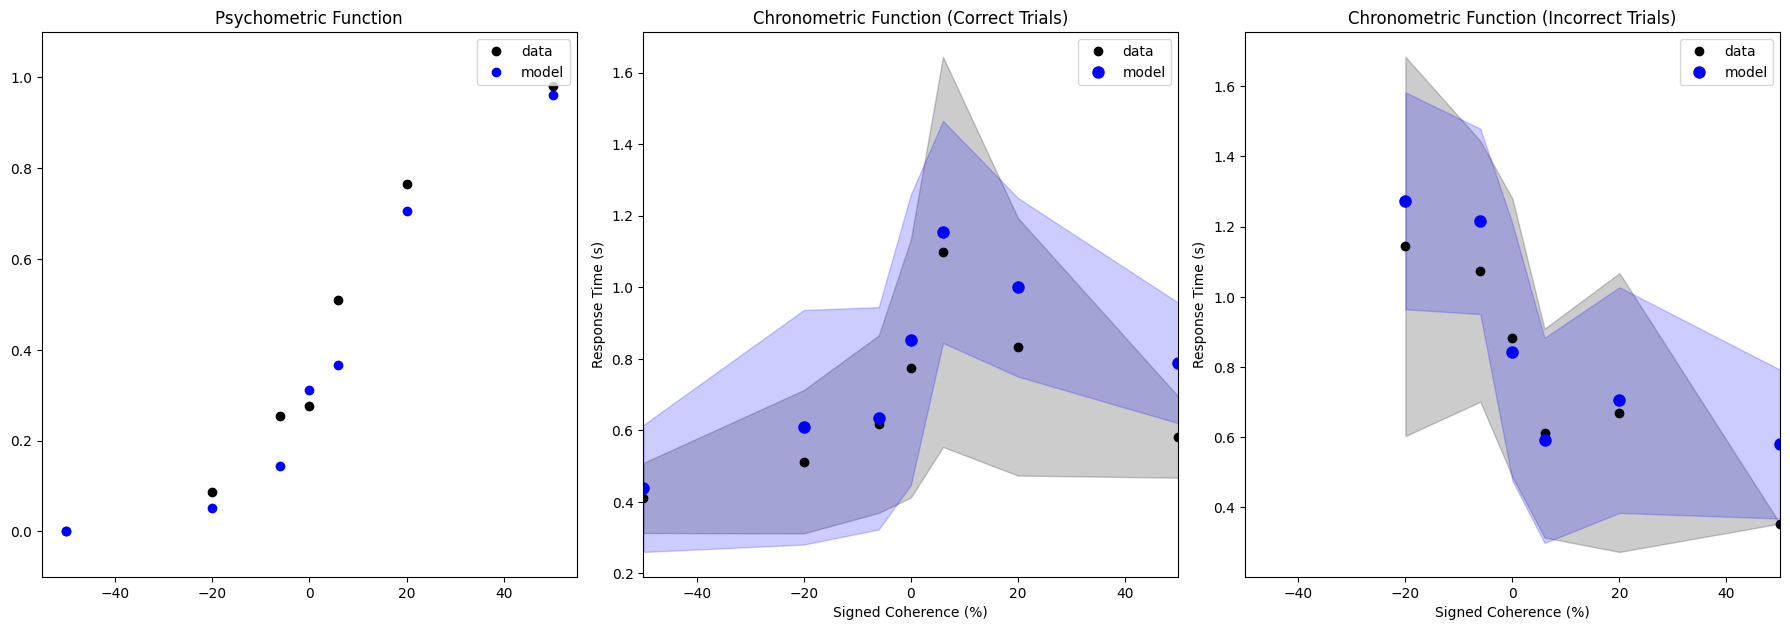

Proportion of invalid trials: 0.0

Session: 210224_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 492 trials
ndt (global): 0.1714
drift_gain (global): 9.0120
variance (global): 3.0939
a (prior 1): 2.5927
z (prior 1): 0.5600
drift_offset (prior 1): -1.4721
leak_rate (global): 0.1931
time_constant (global): 0.0034

Simulation completed. Generated 492 trials.
Valid simulated trials: 492


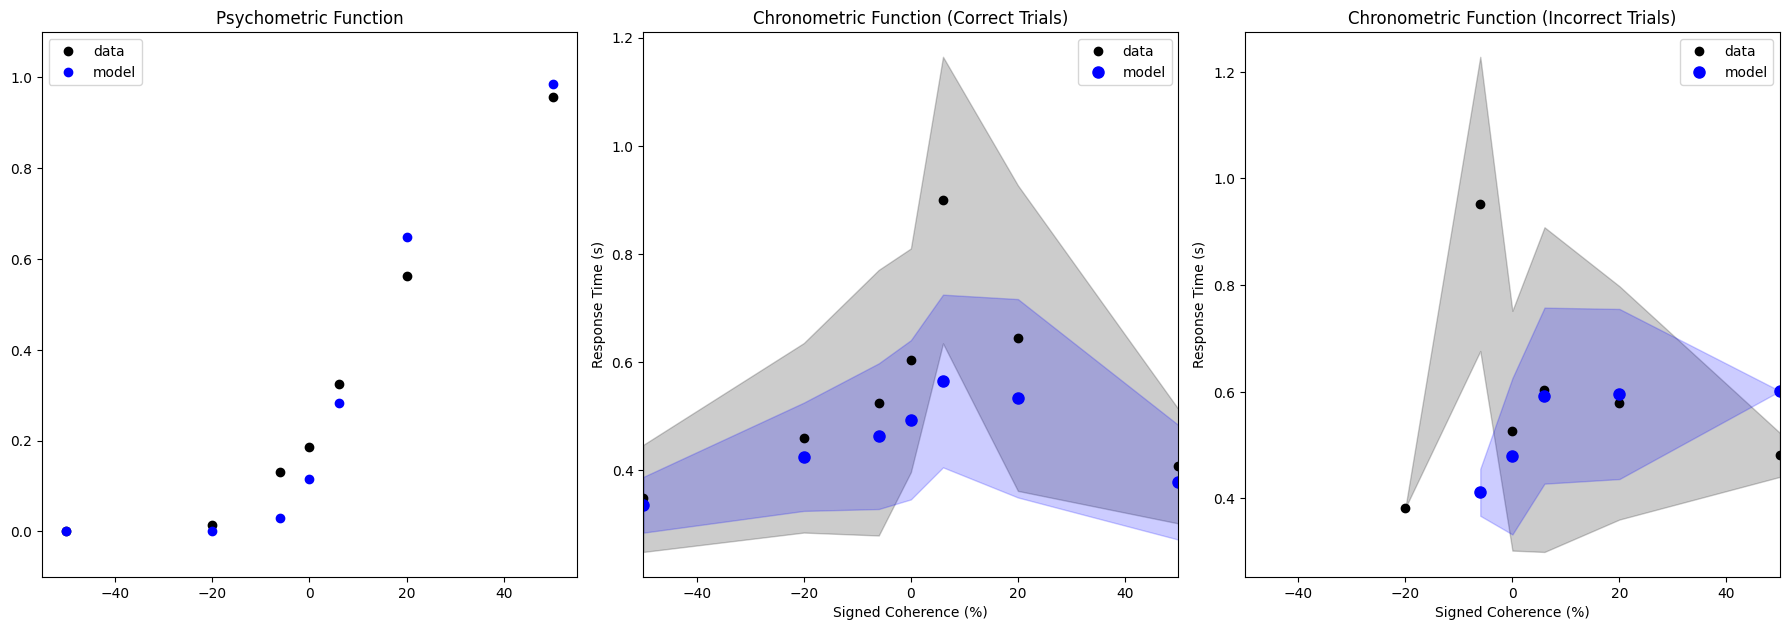

Proportion of invalid trials: 0.0

Session: 210224_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 797 trials
ndt (global): 0.1714
drift_gain (global): 9.0120
variance (global): 3.0939
a (prior 2): 5.5424
z (prior 2): 0.1953
drift_offset (prior 2): 0.7304
leak_rate (global): 0.1931
time_constant (global): 0.0034

Simulation completed. Generated 797 trials.
Valid simulated trials: 797


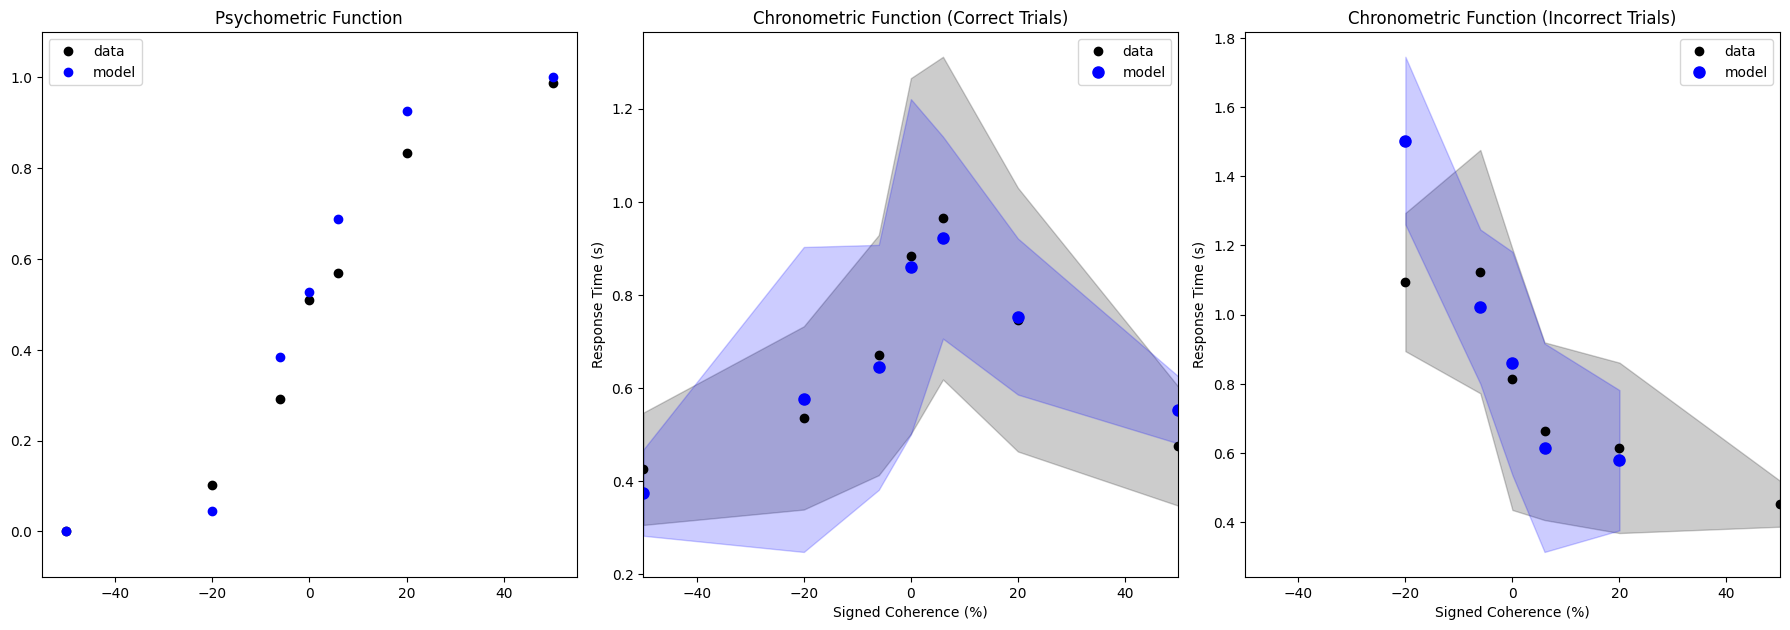

Proportion of invalid trials: 0.0

Session: 210302_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 353 trials
ndt (global): 0.1383
drift_gain (global): 13.2092
variance (global): 4.0904
a (prior 1): 4.7803
z (prior 1): 0.3536
drift_offset (prior 1): 0.4768
leak_rate (global): 0.0472
time_constant (global): 0.0037

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


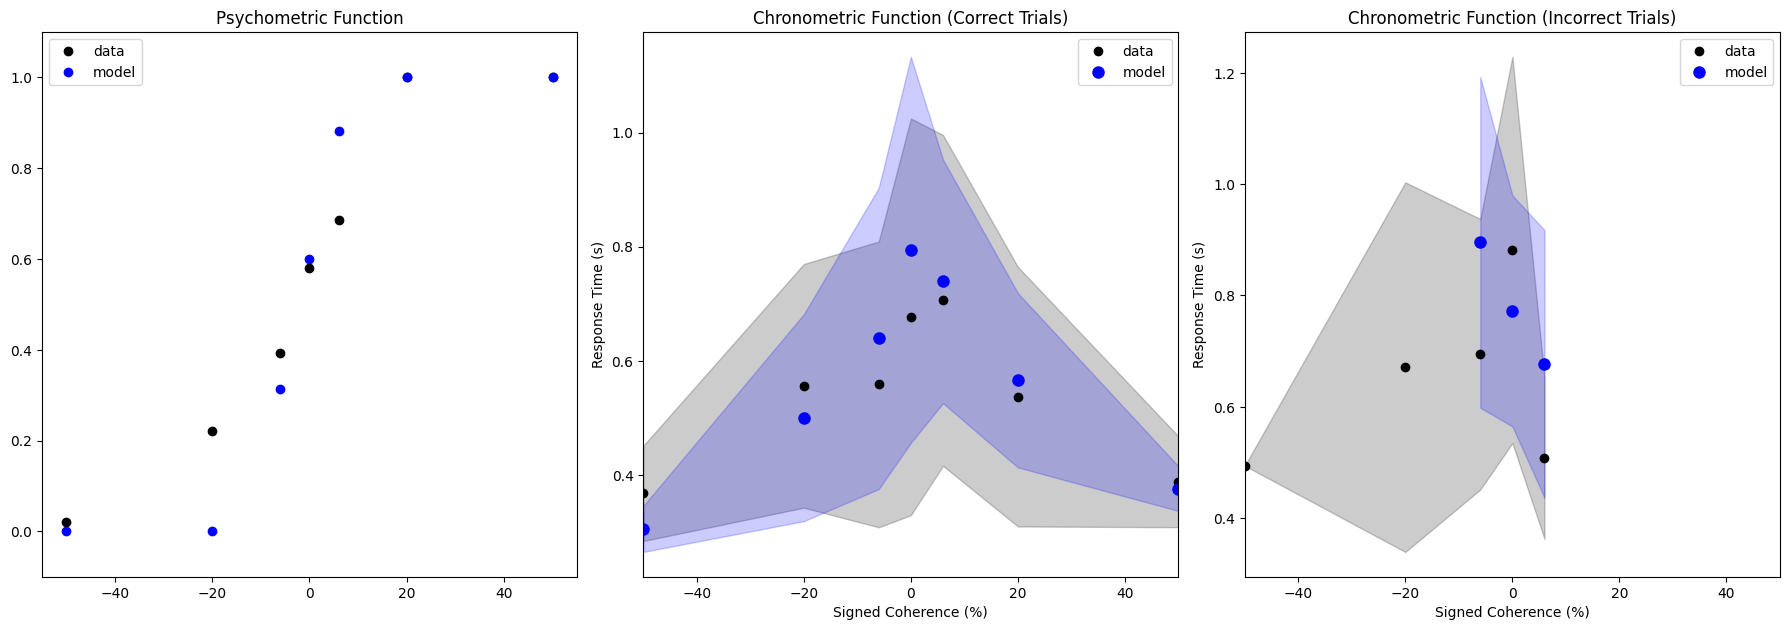

Proportion of invalid trials: 0.0

Session: 210302_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 691 trials
ndt (global): 0.1383
drift_gain (global): 13.2092
variance (global): 4.0904
a (prior 2): 4.3681
z (prior 2): 0.3554
drift_offset (prior 2): 0.1663
leak_rate (global): 0.0472
time_constant (global): 0.0037

Simulation completed. Generated 691 trials.
Valid simulated trials: 691


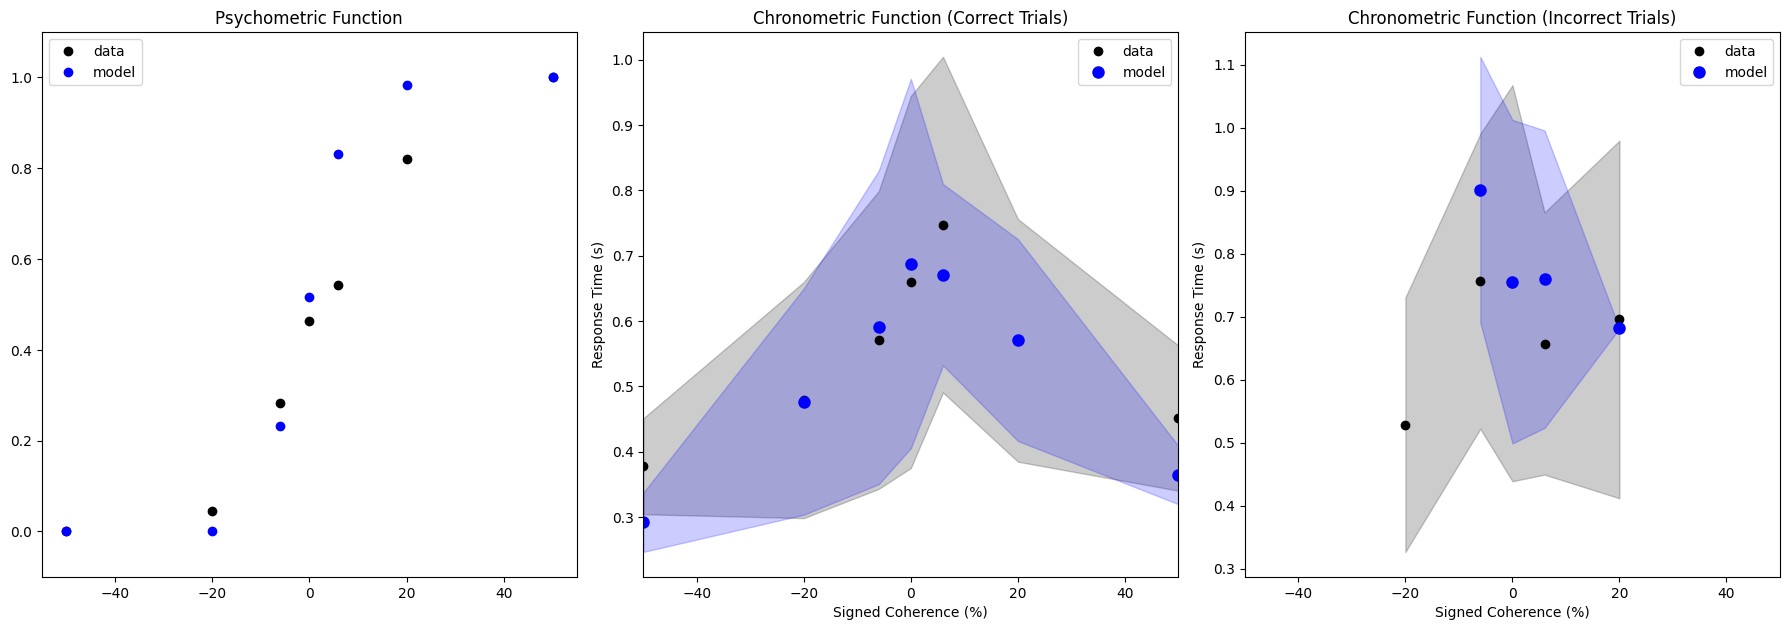

Proportion of invalid trials: 0.0

Session: 210311_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 356 trials
ndt (global): 0.3096
drift_gain (global): 5.4687
variance (global): 3.6881
a (prior 1): 1.7295
z (prior 1): 0.6620
drift_offset (prior 1): -1.1692
leak_rate (global): 0.3299
time_constant (global): 0.0054

Simulation completed. Generated 356 trials.
Valid simulated trials: 356


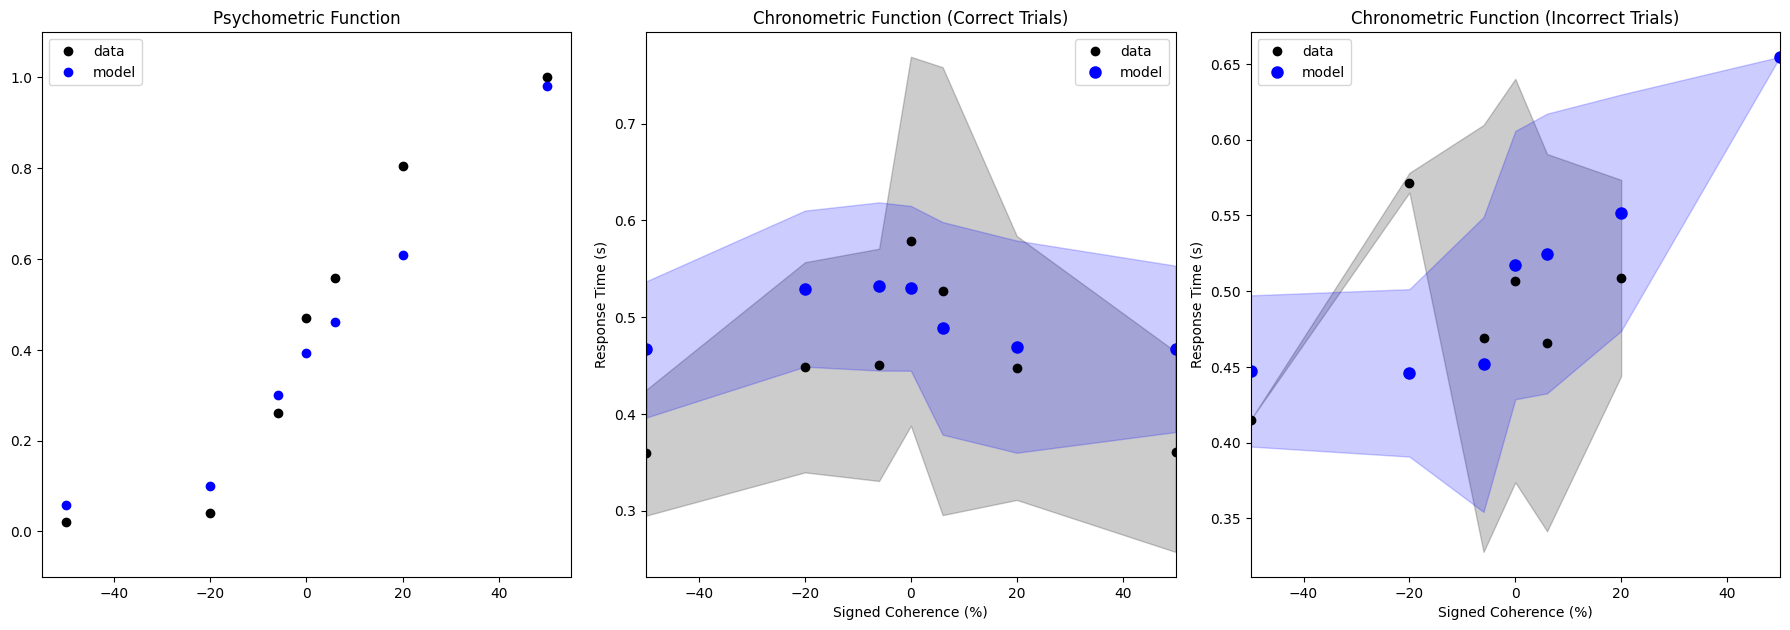

Proportion of invalid trials: 0.0

Session: 210311_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 764 trials
ndt (global): 0.3096
drift_gain (global): 5.4687
variance (global): 3.6881
a (prior 2): 2.4348
z (prior 2): 0.4811
drift_offset (prior 2): 0.0583
leak_rate (global): 0.3299
time_constant (global): 0.0054

Simulation completed. Generated 764 trials.
Valid simulated trials: 764


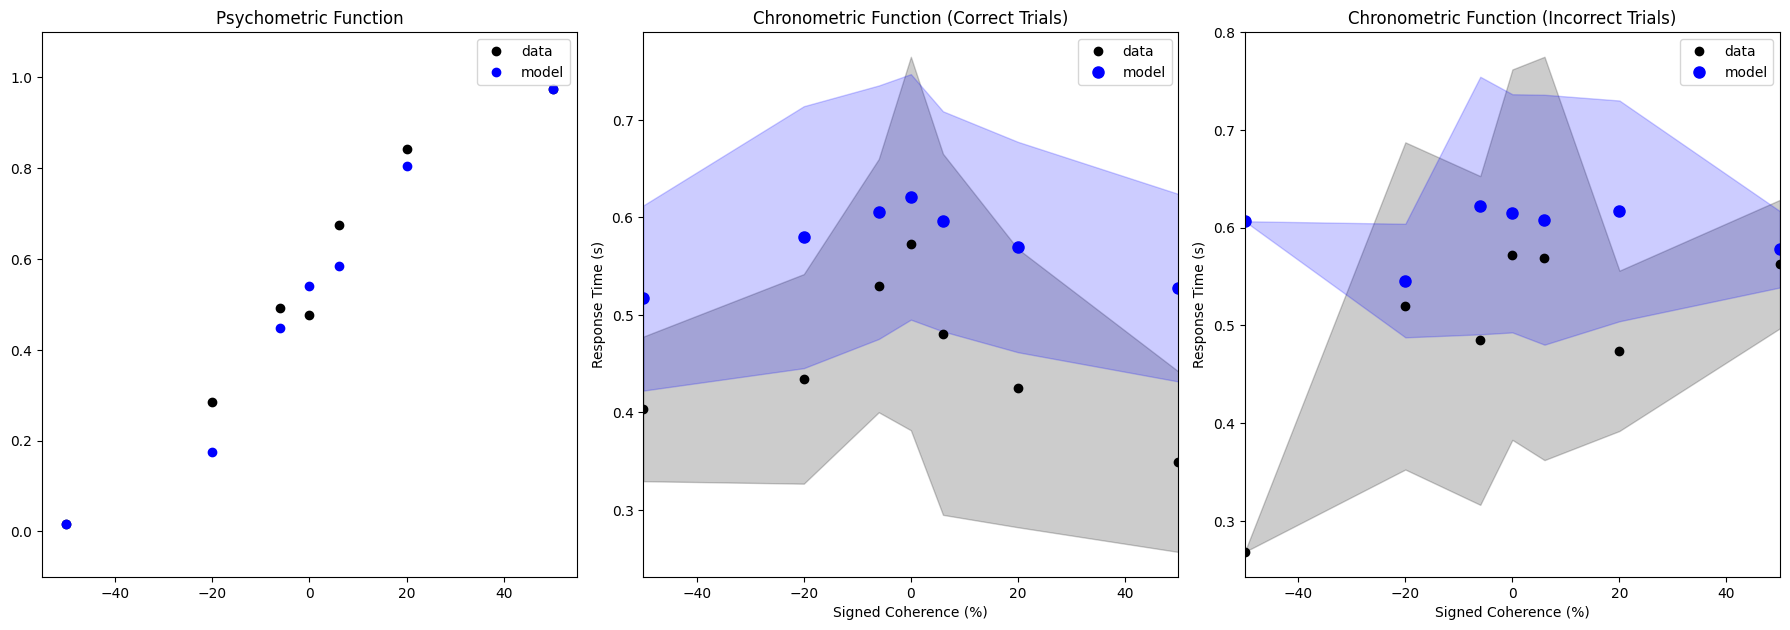

Proportion of invalid trials: 0.0

Session: 210312_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 346 trials
ndt (global): 0.1975
drift_gain (global): 1.7652
variance (global): 3.1779
a (prior 1): 2.6911
z (prior 1): 0.7580
drift_offset (prior 1): -0.2854
leak_rate (global): 0.4993
time_constant (global): 0.0025

Simulation completed. Generated 346 trials.
Valid simulated trials: 346


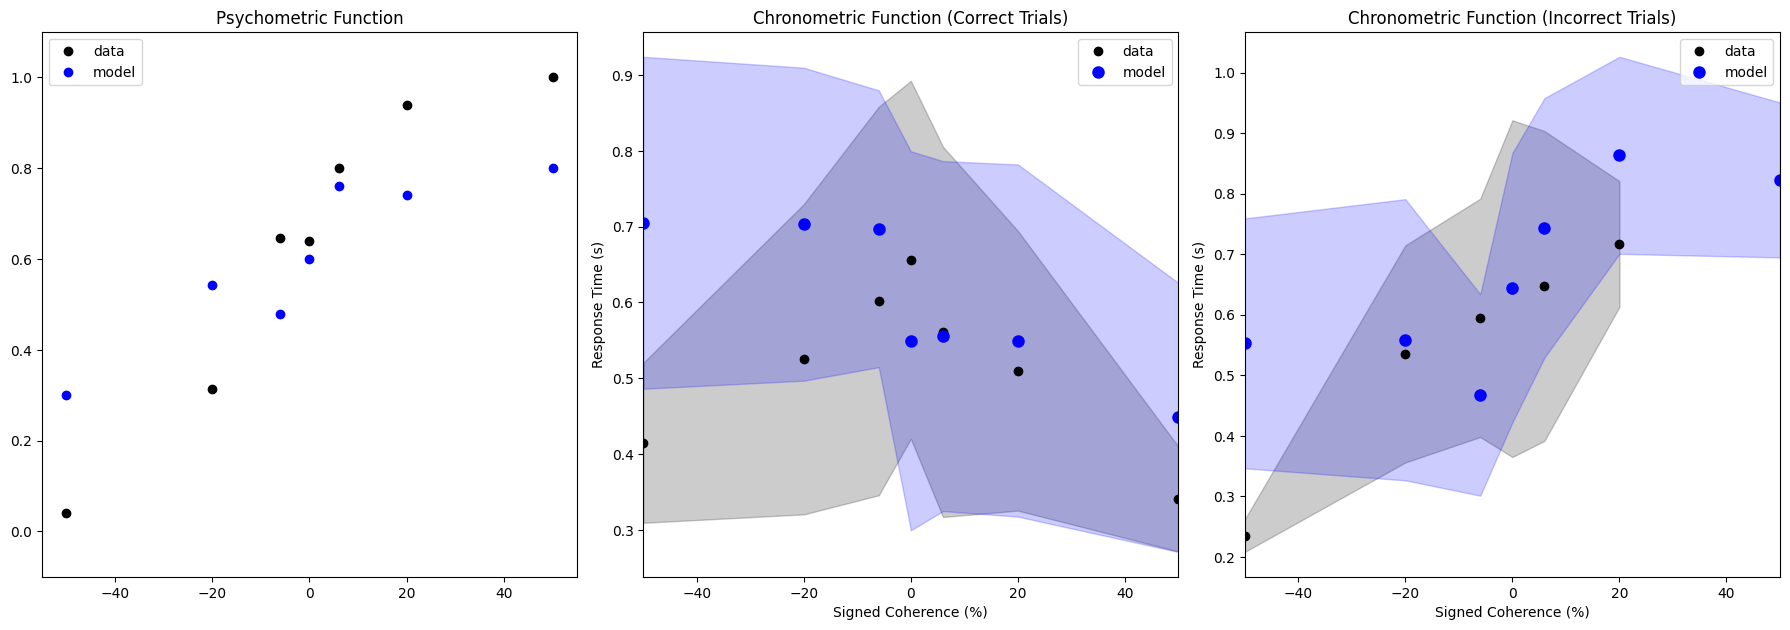

Proportion of invalid trials: 0.0

Session: 210312_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 665 trials
ndt (global): 0.1975
drift_gain (global): 1.7652
variance (global): 3.1779
a (prior 2): 3.1436
z (prior 2): 0.4928
drift_offset (prior 2): -0.4765
leak_rate (global): 0.4993
time_constant (global): 0.0025

Simulation completed. Generated 665 trials.
Valid simulated trials: 665


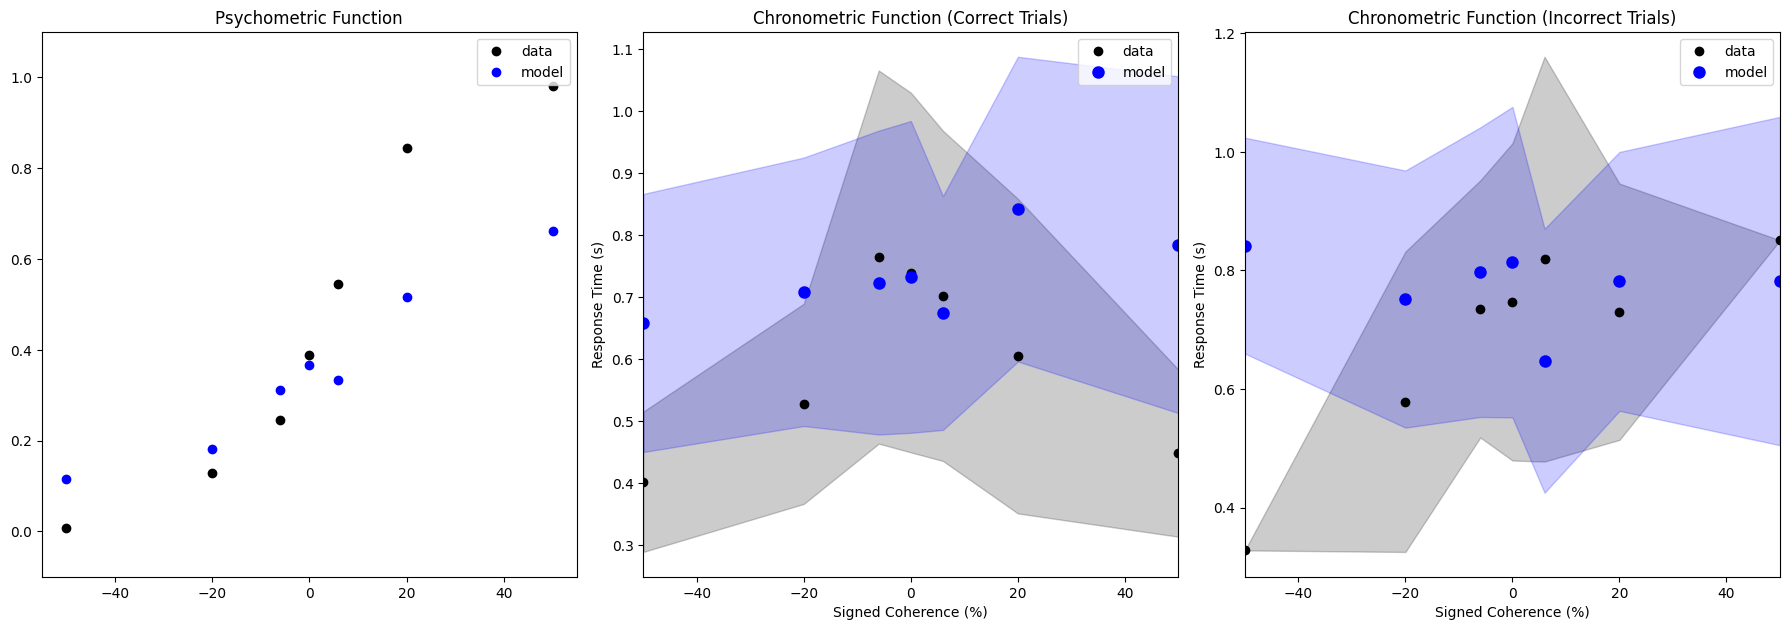

Proportion of invalid trials: 0.0

Session: 210315_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 352 trials
ndt (global): 0.1189
drift_gain (global): 17.2731
variance (global): 3.2939
a (prior 1): 3.4931
z (prior 1): 0.4491
drift_offset (prior 1): -0.9581
leak_rate (global): 0.9604
time_constant (global): 0.0018

Simulation completed. Generated 352 trials.
Valid simulated trials: 352


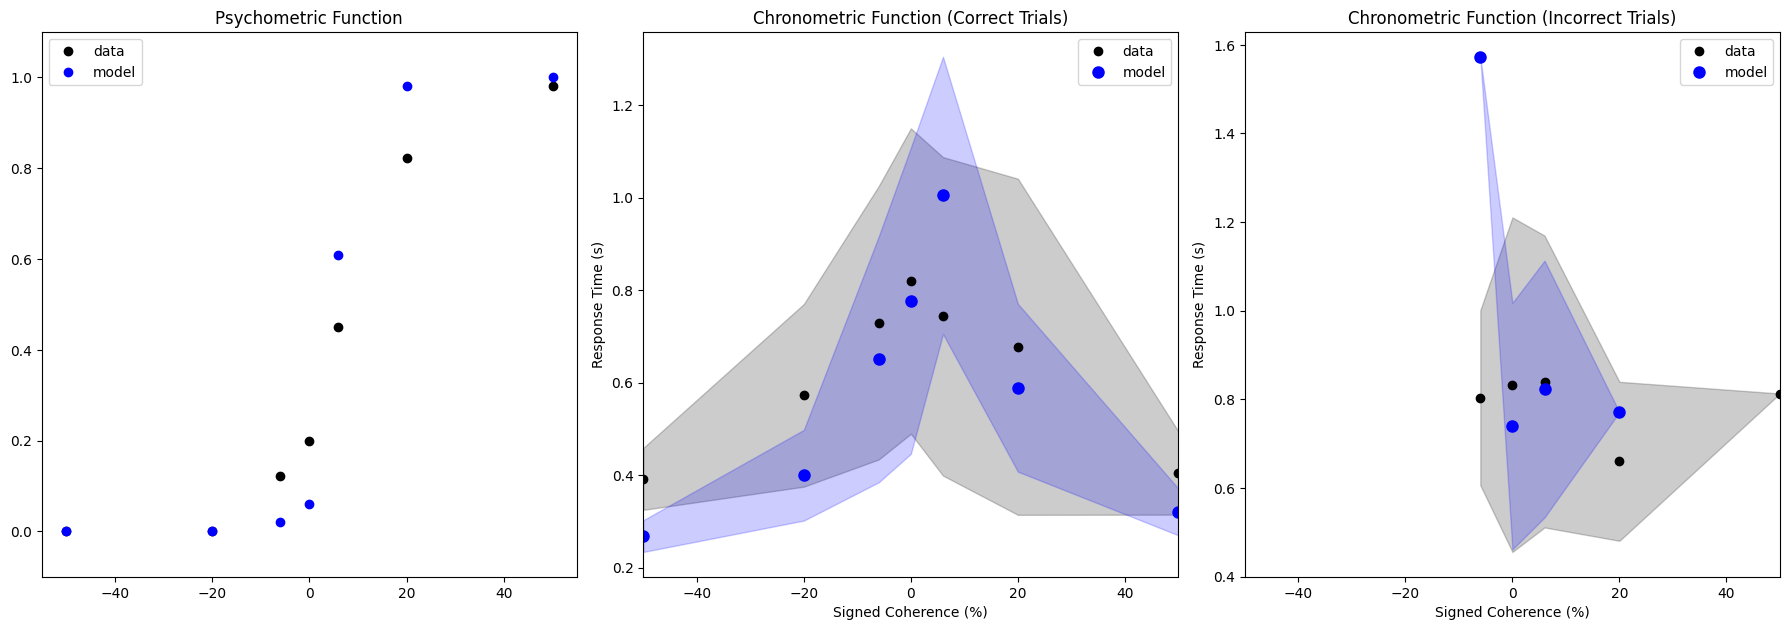

Proportion of invalid trials: 0.0

Session: 210315_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 805 trials
ndt (global): 0.1189
drift_gain (global): 17.2731
variance (global): 3.2939
a (prior 2): 3.4249
z (prior 2): 0.5477
drift_offset (prior 2): -0.1038
leak_rate (global): 0.9604
time_constant (global): 0.0018

Simulation completed. Generated 805 trials.
Valid simulated trials: 805


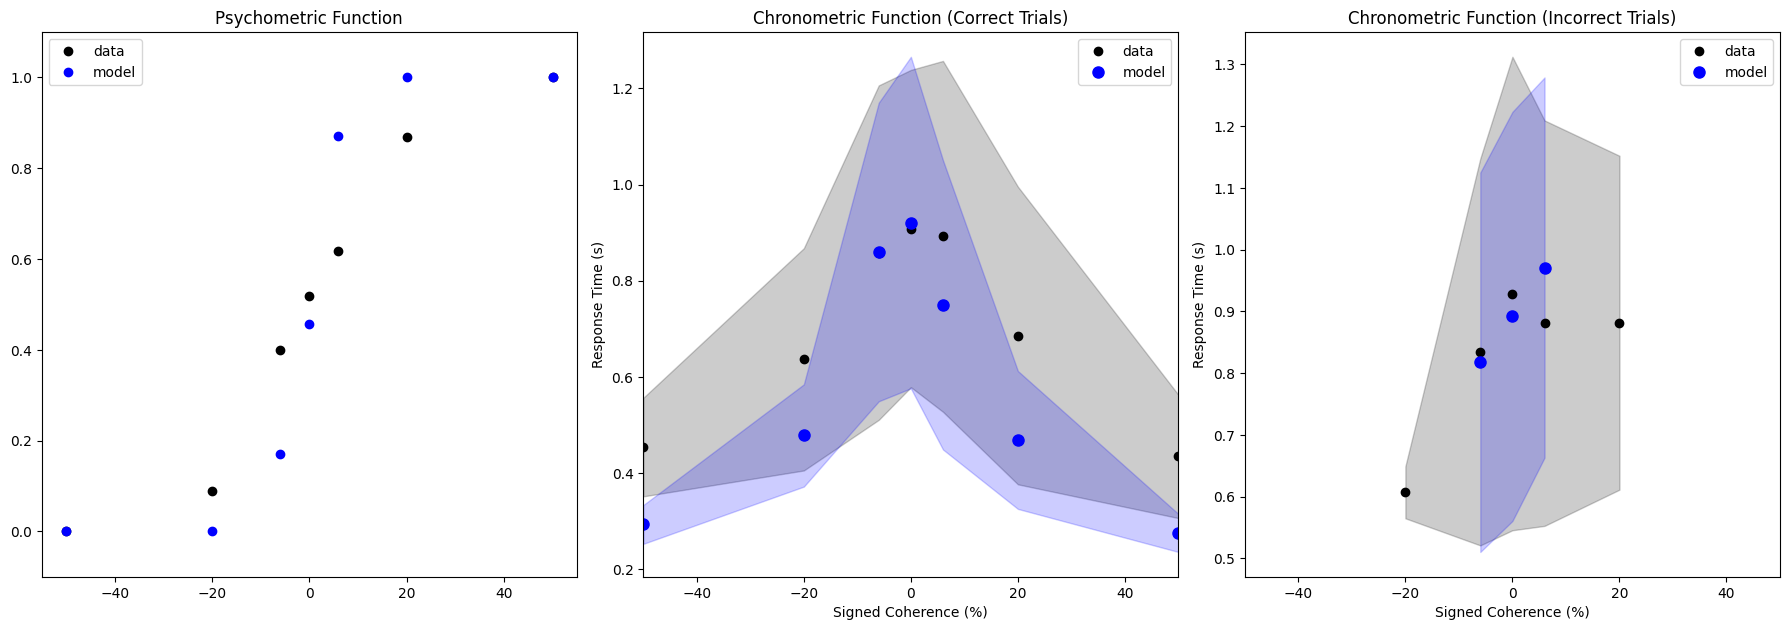

Proportion of invalid trials: 0.0

Session: 210317_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 355 trials
ndt (global): 0.1746
drift_gain (global): 8.7037
variance (global): 3.8004
a (prior 1): 3.1825
z (prior 1): 0.6344
drift_offset (prior 1): -0.7505
leak_rate (global): 0.4039
time_constant (global): 0.0037

Simulation completed. Generated 355 trials.
Valid simulated trials: 355


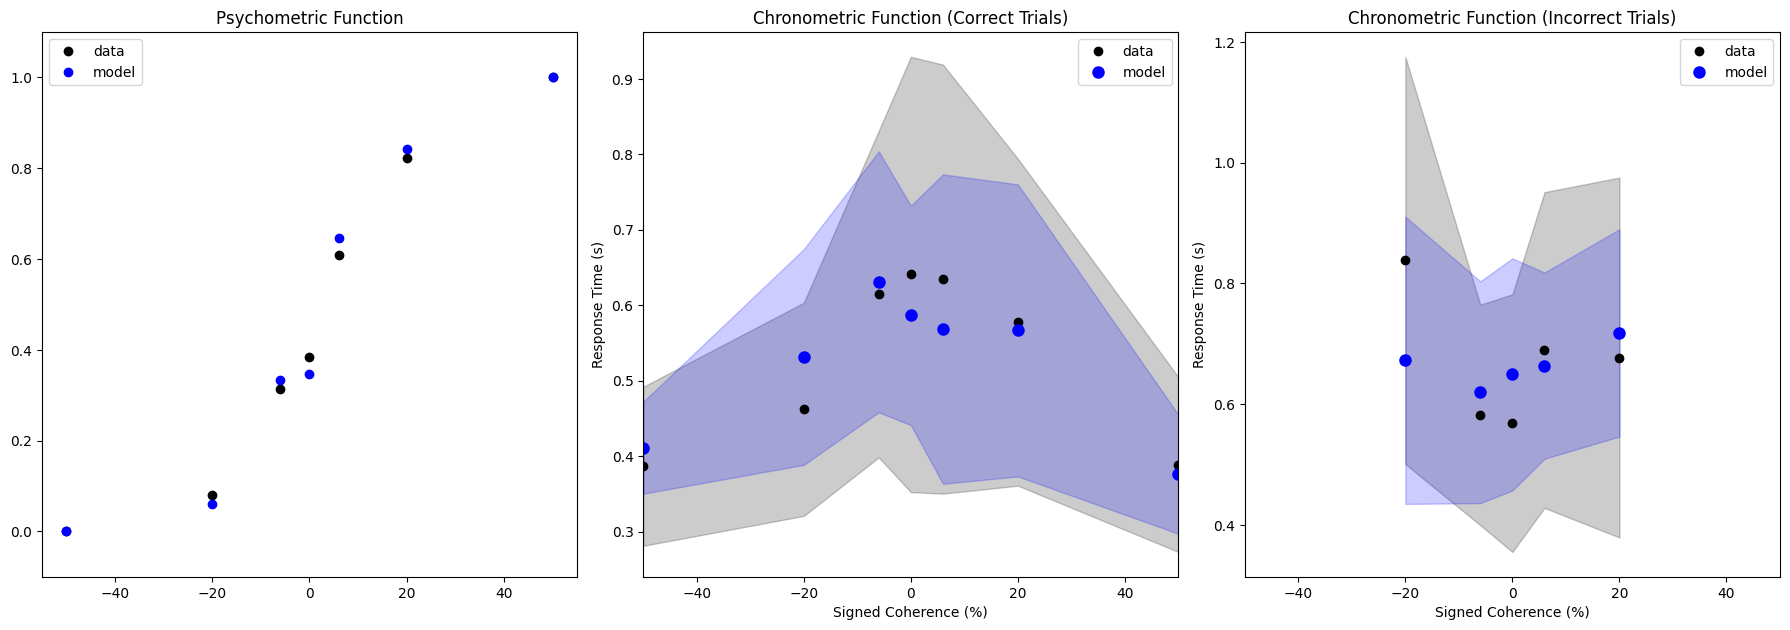

Proportion of invalid trials: 0.0

Session: 210317_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 692 trials
ndt (global): 0.1746
drift_gain (global): 8.7037
variance (global): 3.8004
a (prior 2): 4.9926
z (prior 2): 0.6689
drift_offset (prior 2): -0.2699
leak_rate (global): 0.4039
time_constant (global): 0.0037

Simulation completed. Generated 692 trials.
Valid simulated trials: 689


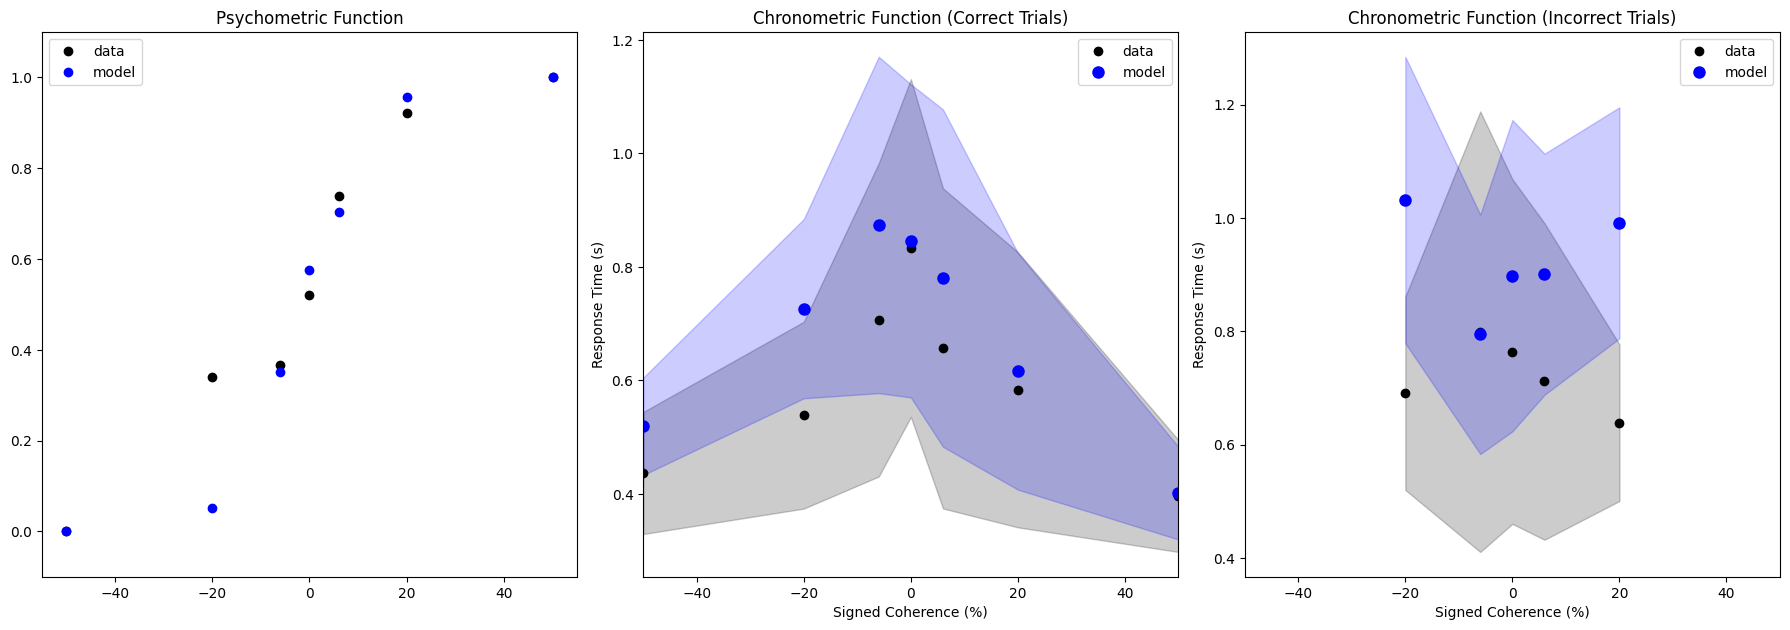

Proportion of invalid trials: 0.004335260115606936

Session: 210318_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 364 trials
ndt (global): 0.1594
drift_gain (global): 3.1090
variance (global): 1.8763
a (prior 1): 5.2906
z (prior 1): 0.5966
drift_offset (prior 1): -0.0571
leak_rate (global): 0.2316
time_constant (global): 0.0038

Simulation completed. Generated 364 trials.
Valid simulated trials: 364


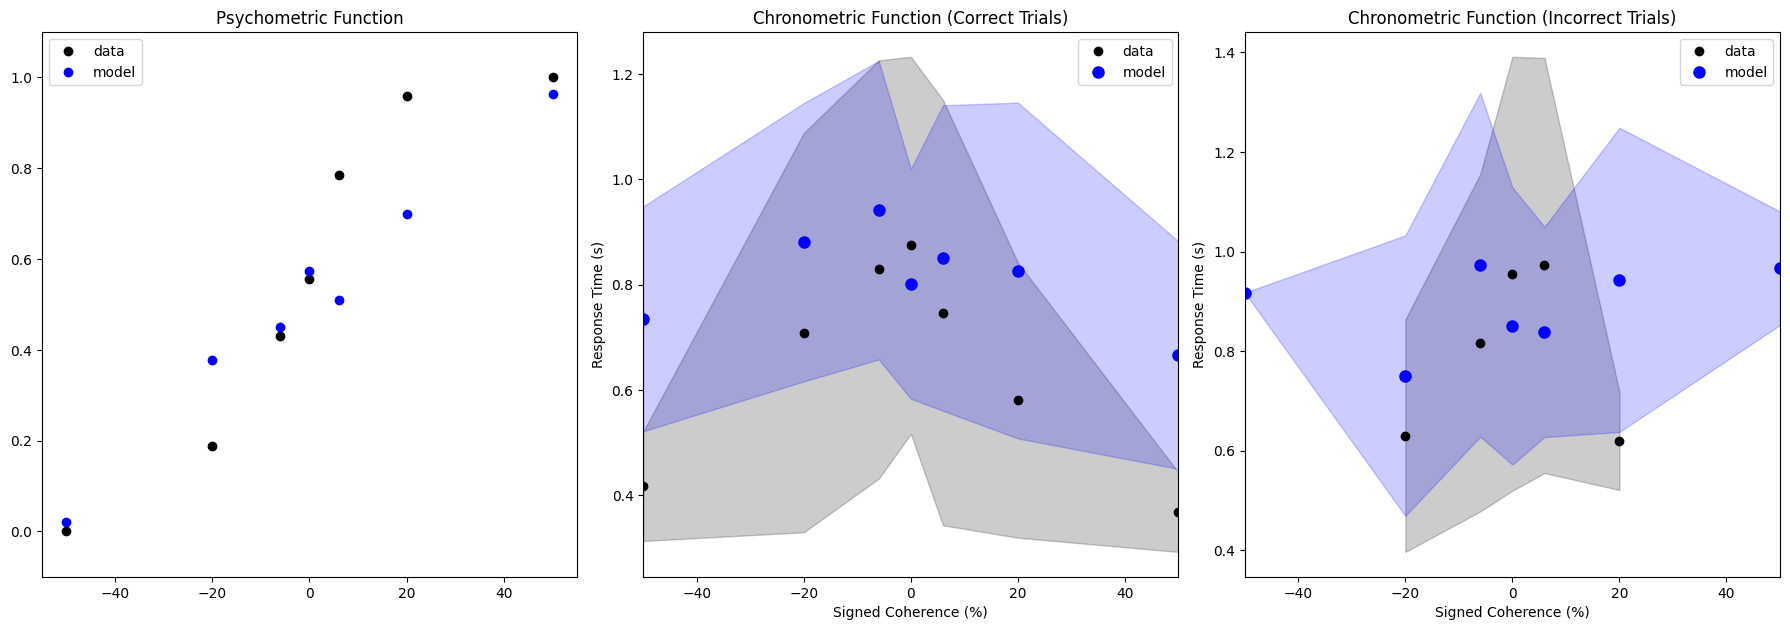

Proportion of invalid trials: 0.0

Session: 210318_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 740 trials
ndt (global): 0.1594
drift_gain (global): 3.1090
variance (global): 1.8763
a (prior 2): 4.9833
z (prior 2): 0.5707
drift_offset (prior 2): -0.6718
leak_rate (global): 0.2316
time_constant (global): 0.0038

Simulation completed. Generated 740 trials.
Valid simulated trials: 740


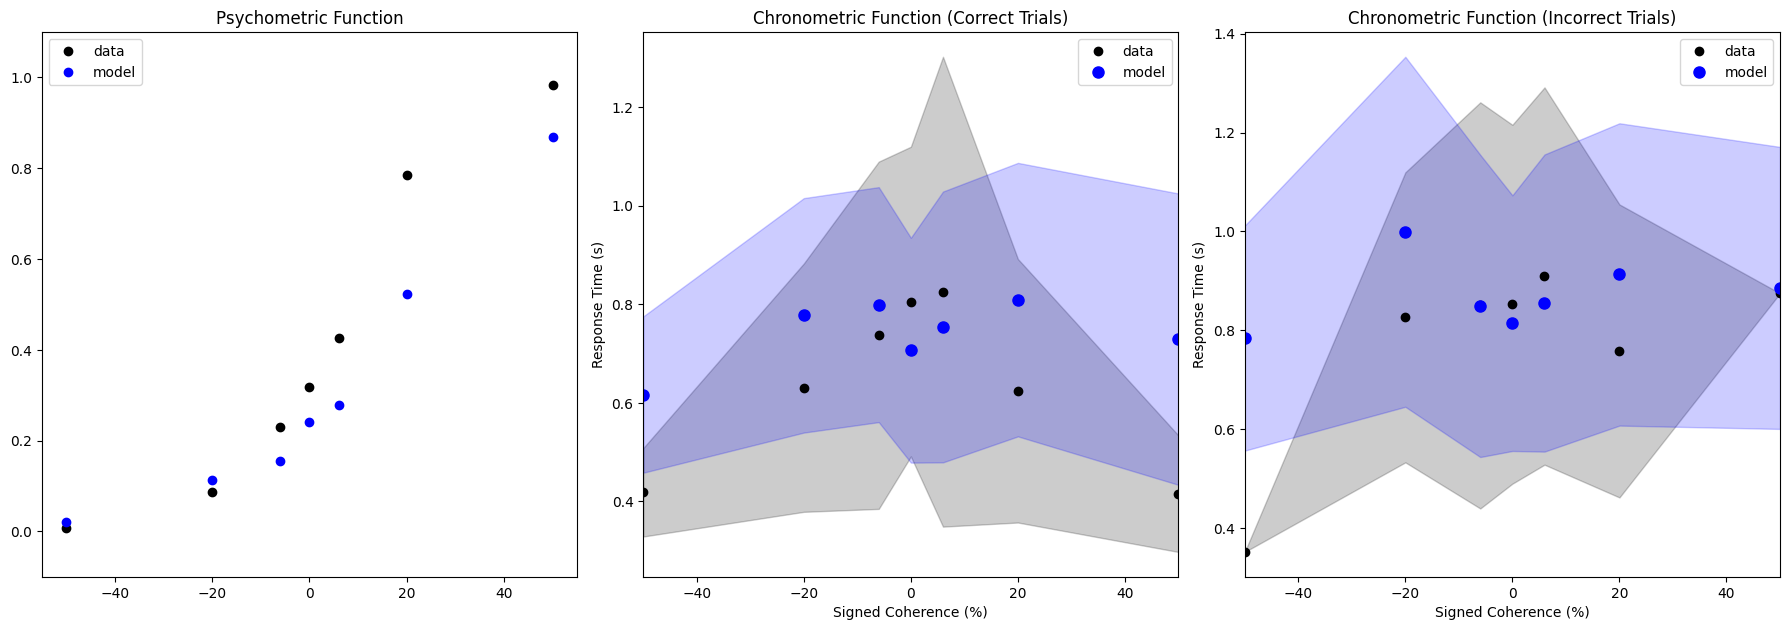

Proportion of invalid trials: 0.0

Session: 210323_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 357 trials
ndt (global): 0.1214
drift_gain (global): 1.4387
variance (global): 3.8722
a (prior 1): 5.7131
z (prior 1): 0.3566
drift_offset (prior 1): 0.1319
leak_rate (global): 0.1082
time_constant (global): 0.0036

Simulation completed. Generated 357 trials.
Valid simulated trials: 357


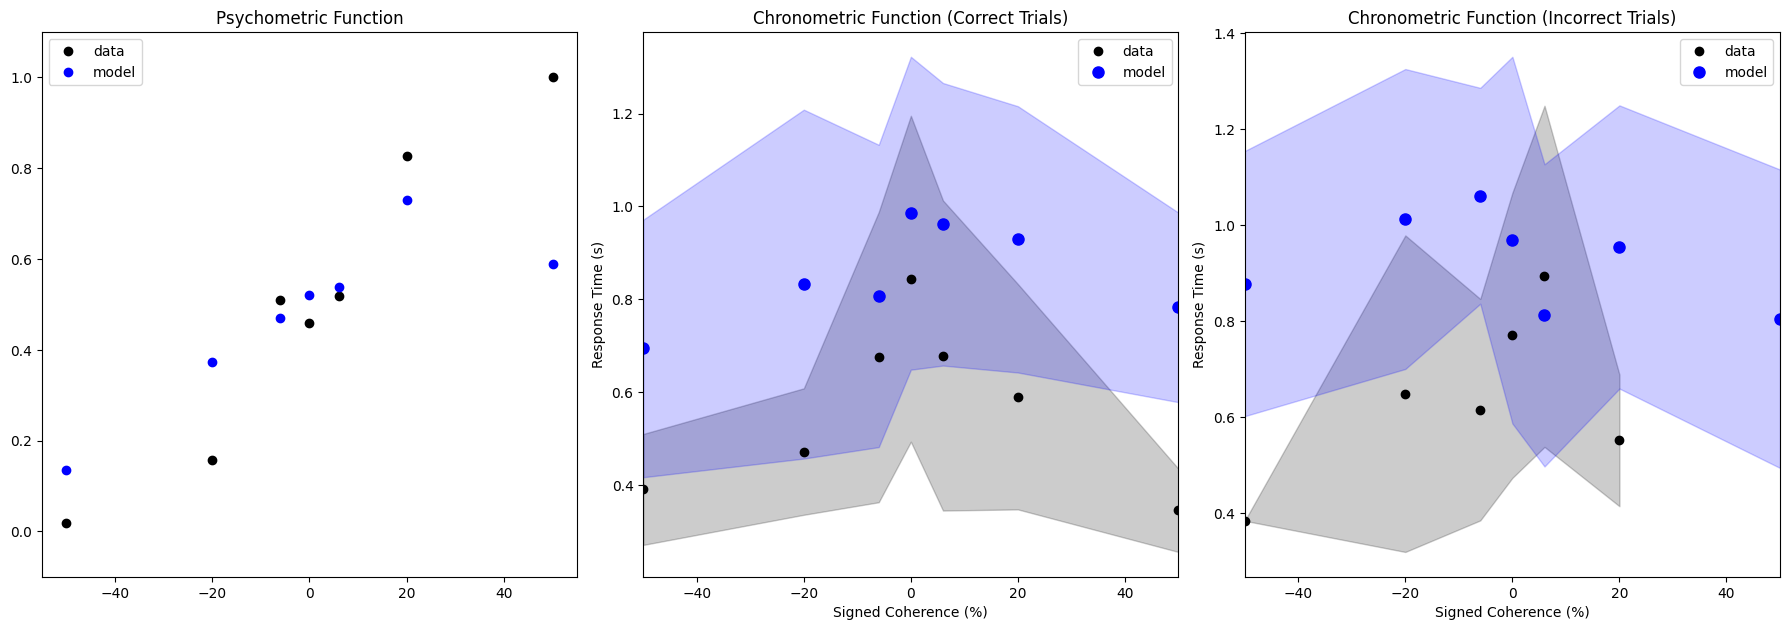

Proportion of invalid trials: 0.0

Session: 210323_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 695 trials
ndt (global): 0.1214
drift_gain (global): 1.4387
variance (global): 3.8722
a (prior 2): 4.8008
z (prior 2): 0.4558
drift_offset (prior 2): -0.4107
leak_rate (global): 0.1082
time_constant (global): 0.0036

Simulation completed. Generated 695 trials.
Valid simulated trials: 694


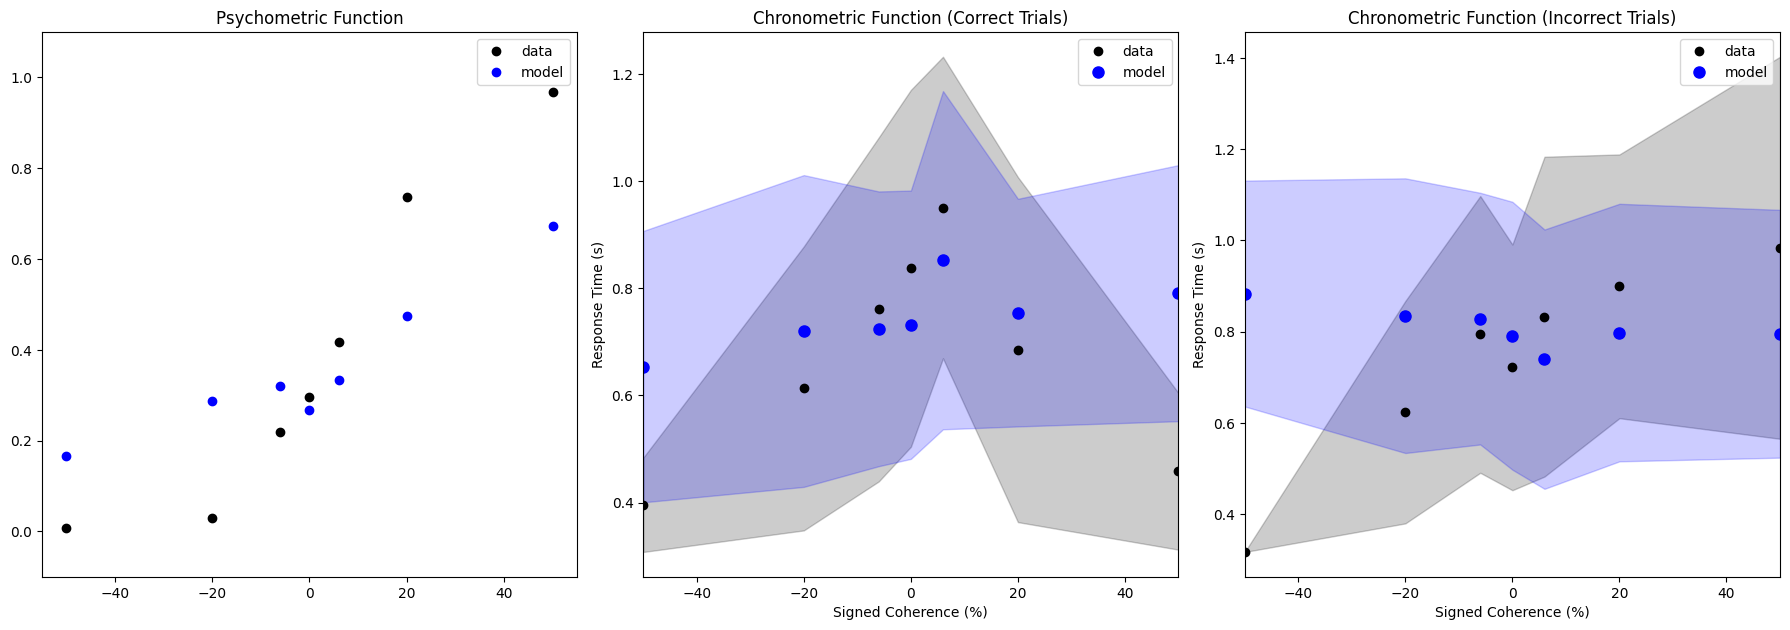

Proportion of invalid trials: 0.0014388489208633094

Session: 210413_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 350 trials
ndt (global): 0.3290
drift_gain (global): 3.3617
variance (global): 0.4208
a (prior 1): 2.6541
z (prior 1): 0.4140
drift_offset (prior 1): 0.3550
leak_rate (global): 0.0016
time_constant (global): 0.0018

Simulation completed. Generated 350 trials.
Valid simulated trials: 350


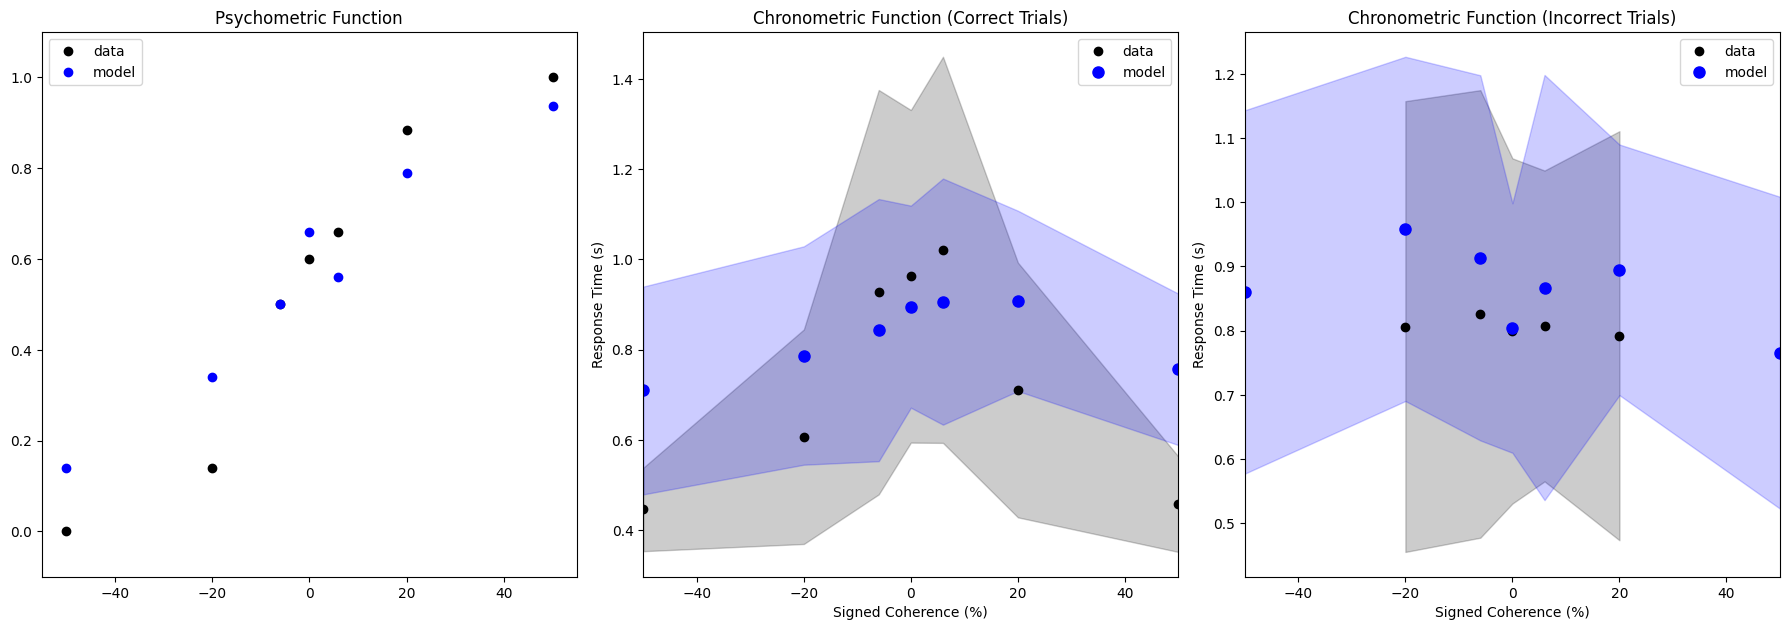

Proportion of invalid trials: 0.0

Session: 210413_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 704 trials
ndt (global): 0.3290
drift_gain (global): 3.3617
variance (global): 0.4208
a (prior 2): 3.2926
z (prior 2): 0.3546
drift_offset (prior 2): 0.1107
leak_rate (global): 0.0016
time_constant (global): 0.0018

Simulation completed. Generated 704 trials.
Valid simulated trials: 704


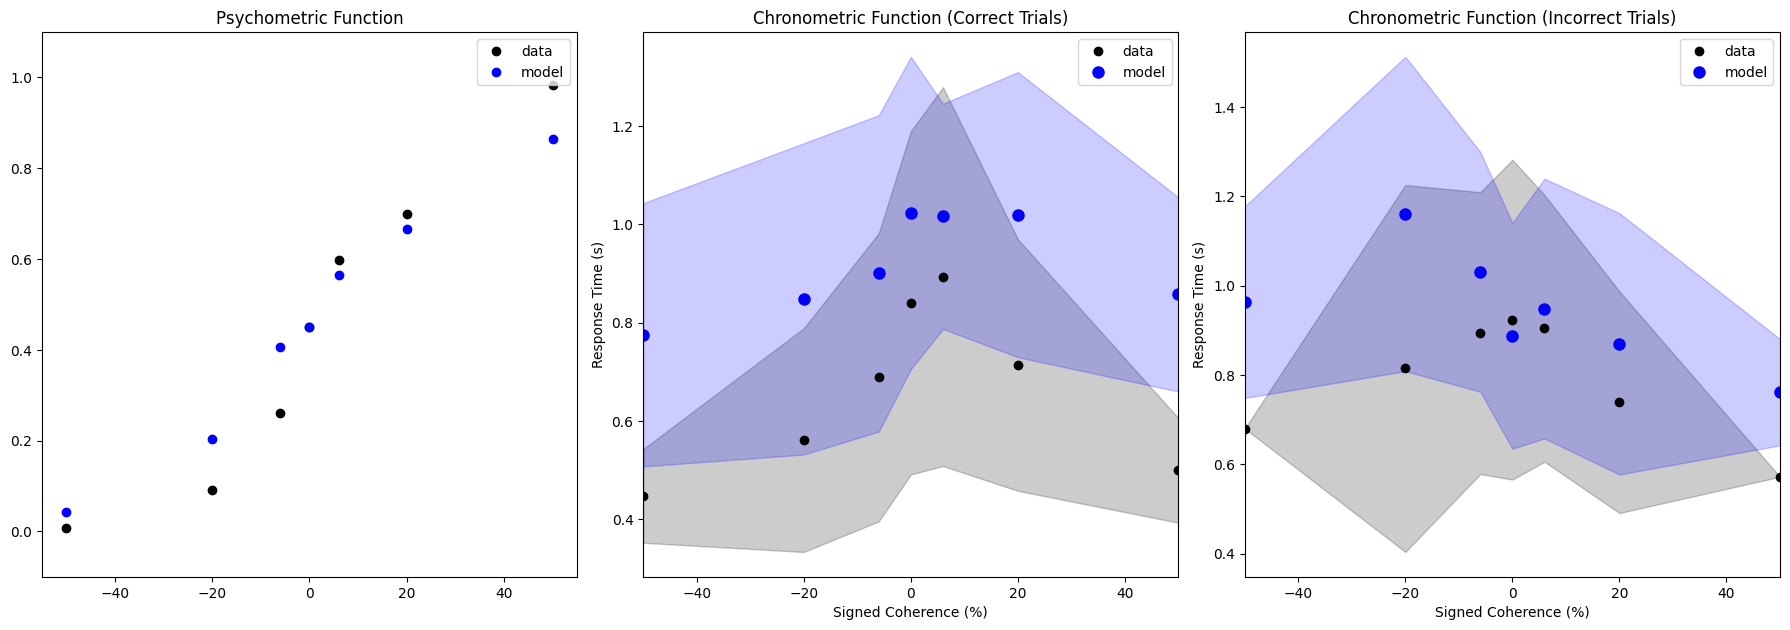

Proportion of invalid trials: 0.0

Session: 210528_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 353 trials
ndt (global): 0.1466
drift_gain (global): 13.2853
variance (global): 2.5356
a (prior 1): 3.2061
z (prior 1): 0.3631
drift_offset (prior 1): 0.5906
leak_rate (global): 0.2661
time_constant (global): 0.0017

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


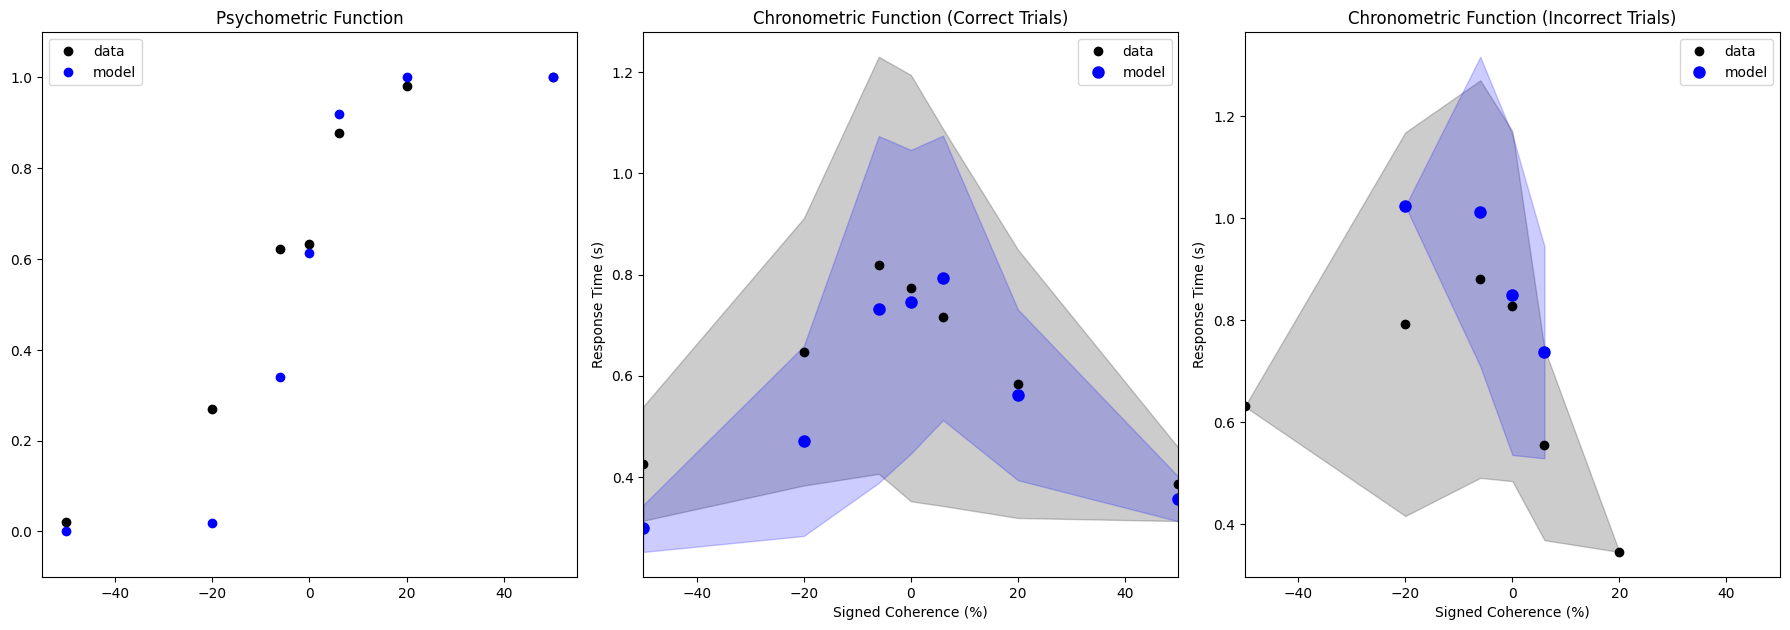

Proportion of invalid trials: 0.0

Session: 210528_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 744 trials
ndt (global): 0.1466
drift_gain (global): 13.2853
variance (global): 2.5356
a (prior 2): 3.9477
z (prior 2): 0.3961
drift_offset (prior 2): 0.1620
leak_rate (global): 0.2661
time_constant (global): 0.0017

Simulation completed. Generated 744 trials.
Valid simulated trials: 744


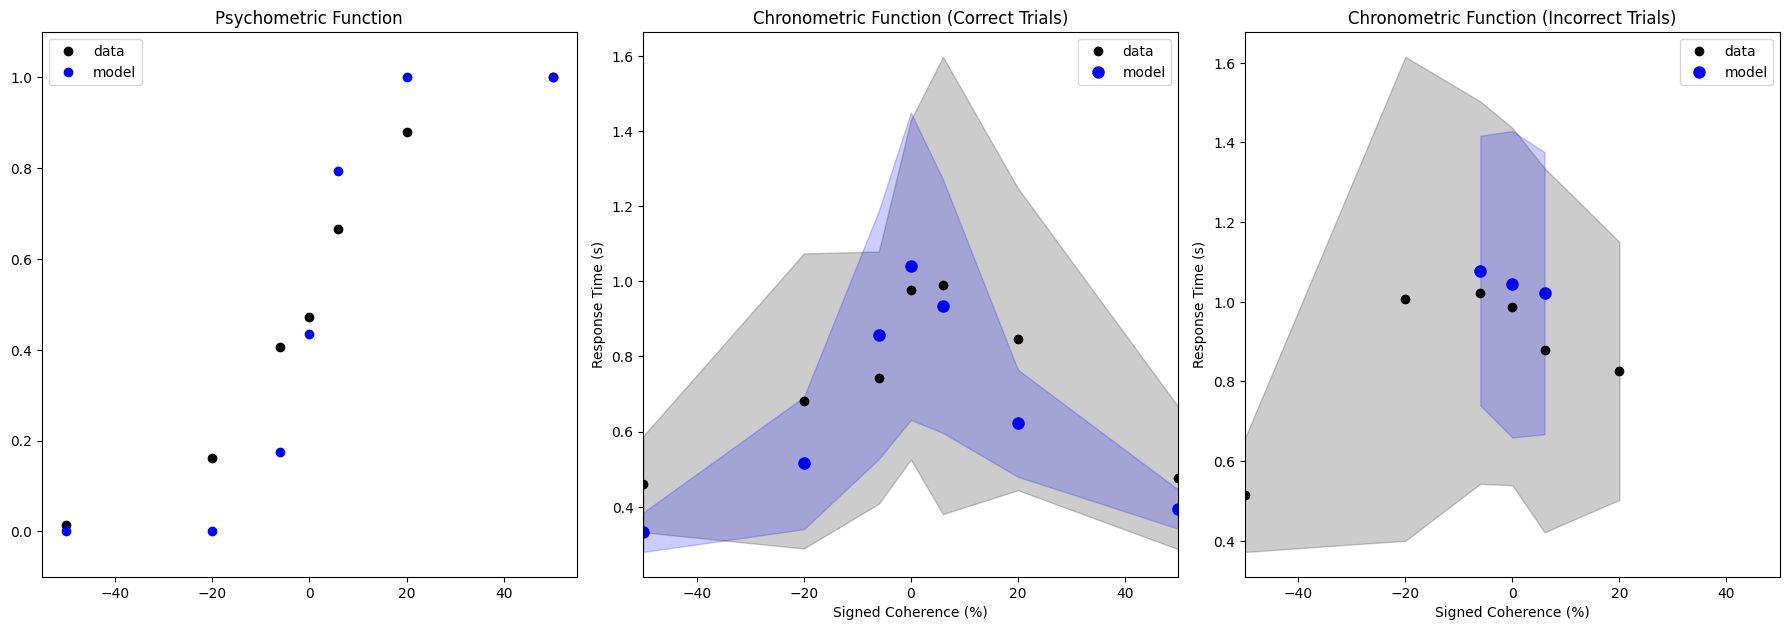

Proportion of invalid trials: 0.0

Session: 210601_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 333 trials
ndt (global): 0.1619
drift_gain (global): 9.0223
variance (global): 0.5846
a (prior 1): 2.5125
z (prior 1): 0.2232
drift_offset (prior 1): 0.7265
leak_rate (global): 0.8175
time_constant (global): 0.0010

Simulation completed. Generated 333 trials.
Valid simulated trials: 333


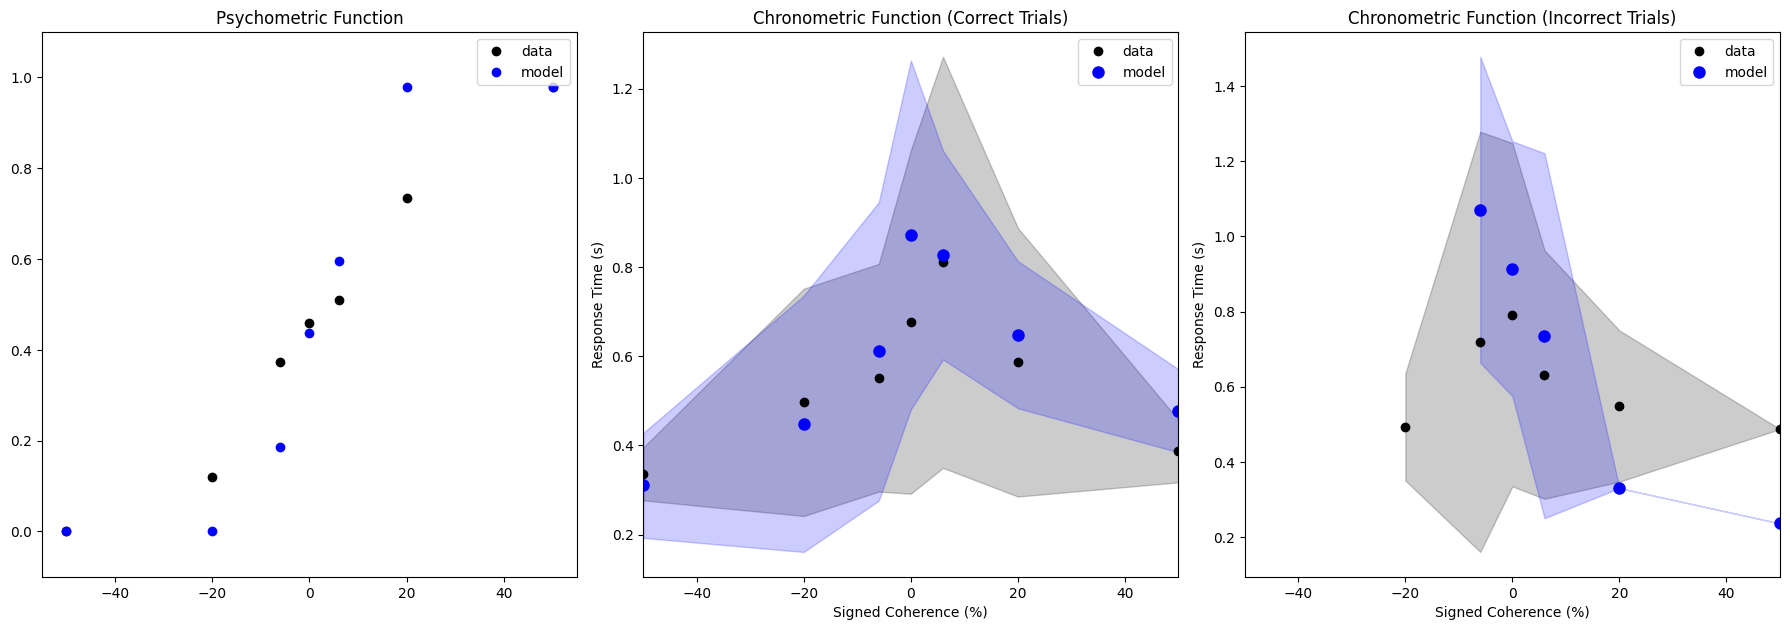

Proportion of invalid trials: 0.0

Session: 210601_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 895 trials
ndt (global): 0.1619
drift_gain (global): 9.0223
variance (global): 0.5846
a (prior 2): 2.1133
z (prior 2): 0.4189
drift_offset (prior 2): 0.2457
leak_rate (global): 0.8175
time_constant (global): 0.0010

Simulation completed. Generated 895 trials.
Valid simulated trials: 895


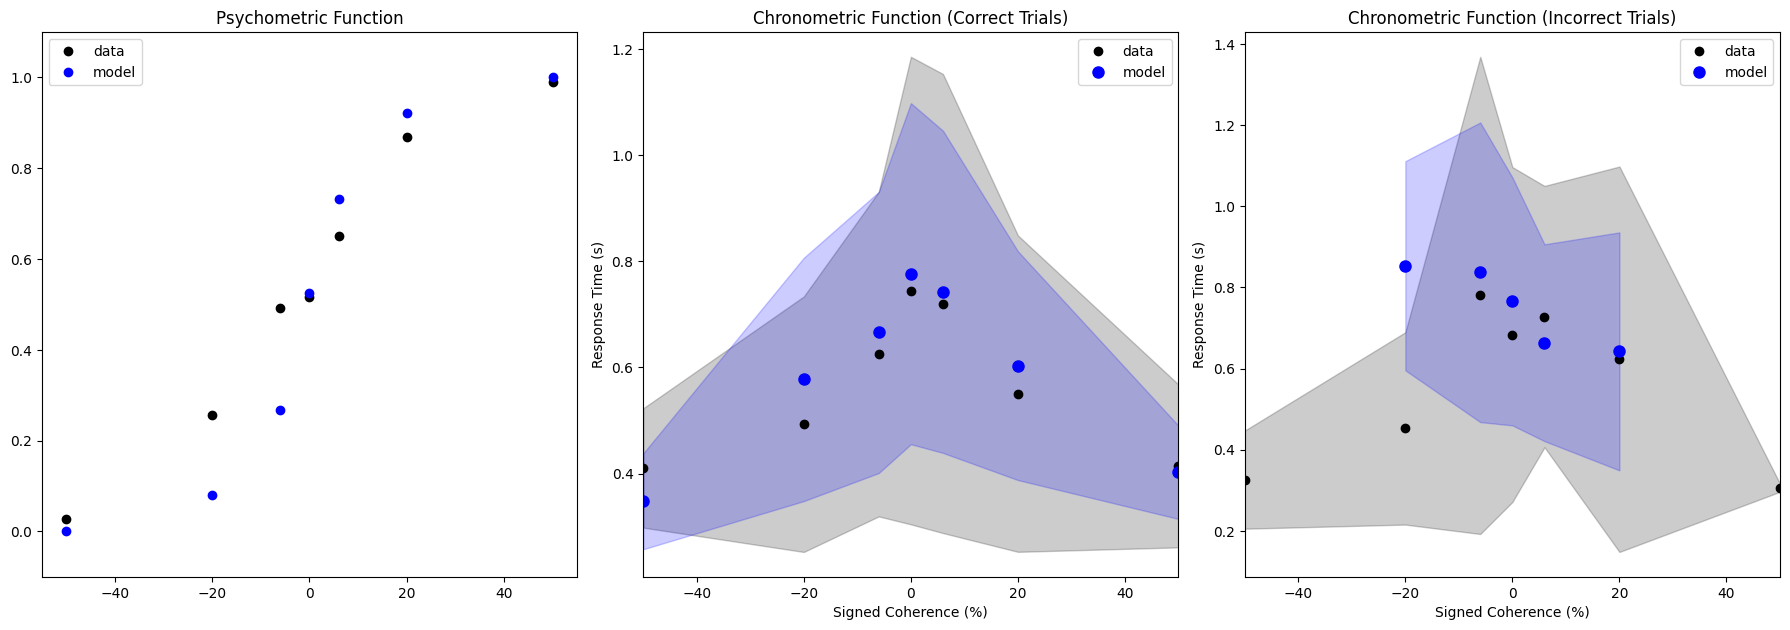

Proportion of invalid trials: 0.0

Session: 210602_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 441 trials
ndt (global): 0.1040
drift_gain (global): 9.8997
variance (global): 0.6430
a (prior 1): 5.4626
z (prior 1): 0.6884
drift_offset (prior 1): -0.1741
leak_rate (global): 0.3476
time_constant (global): 0.0045

Simulation completed. Generated 441 trials.
Valid simulated trials: 441


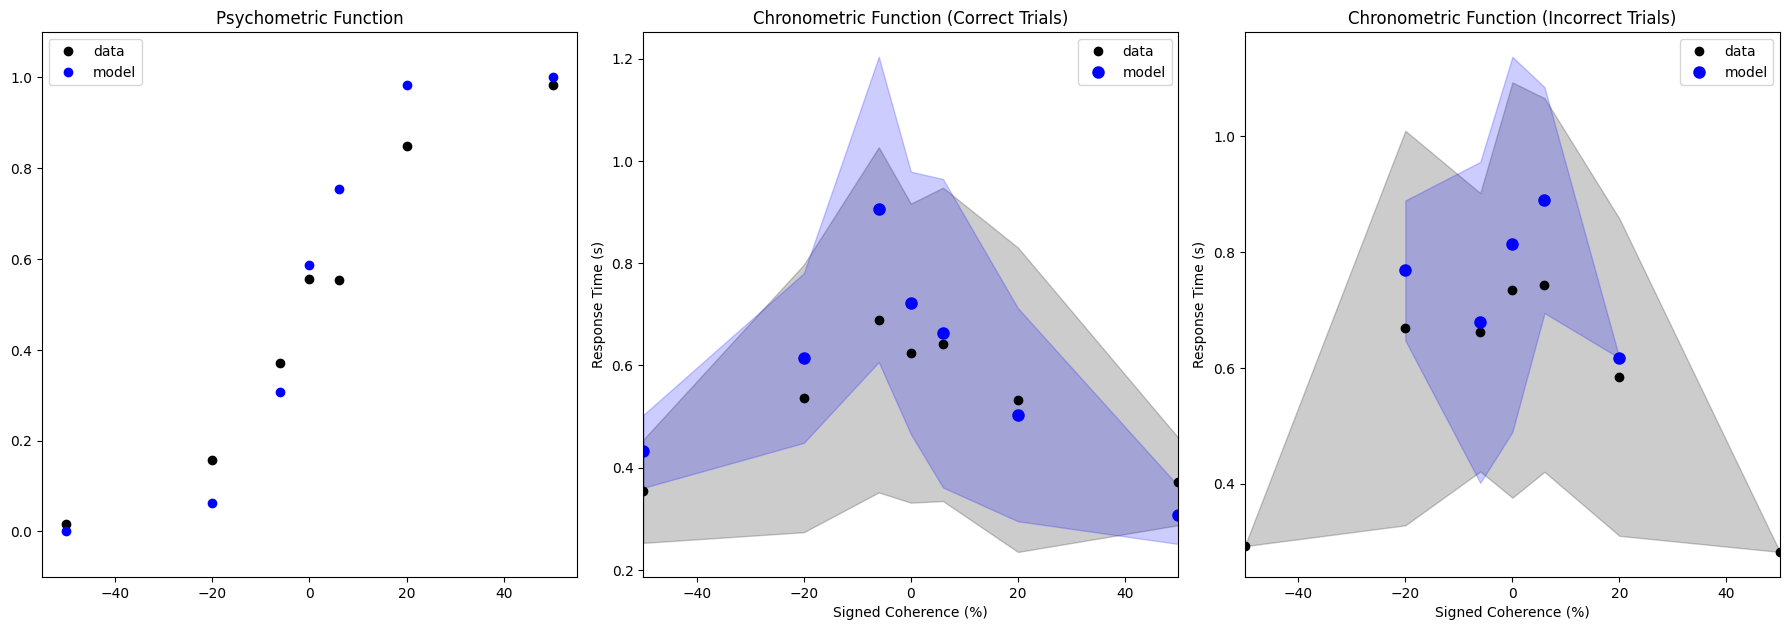

Proportion of invalid trials: 0.0

Session: 210602_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 694 trials
ndt (global): 0.1040
drift_gain (global): 9.8997
variance (global): 0.6430
a (prior 2): 4.6295
z (prior 2): 0.6026
drift_offset (prior 2): 0.1533
leak_rate (global): 0.3476
time_constant (global): 0.0045

Simulation completed. Generated 694 trials.
Valid simulated trials: 694


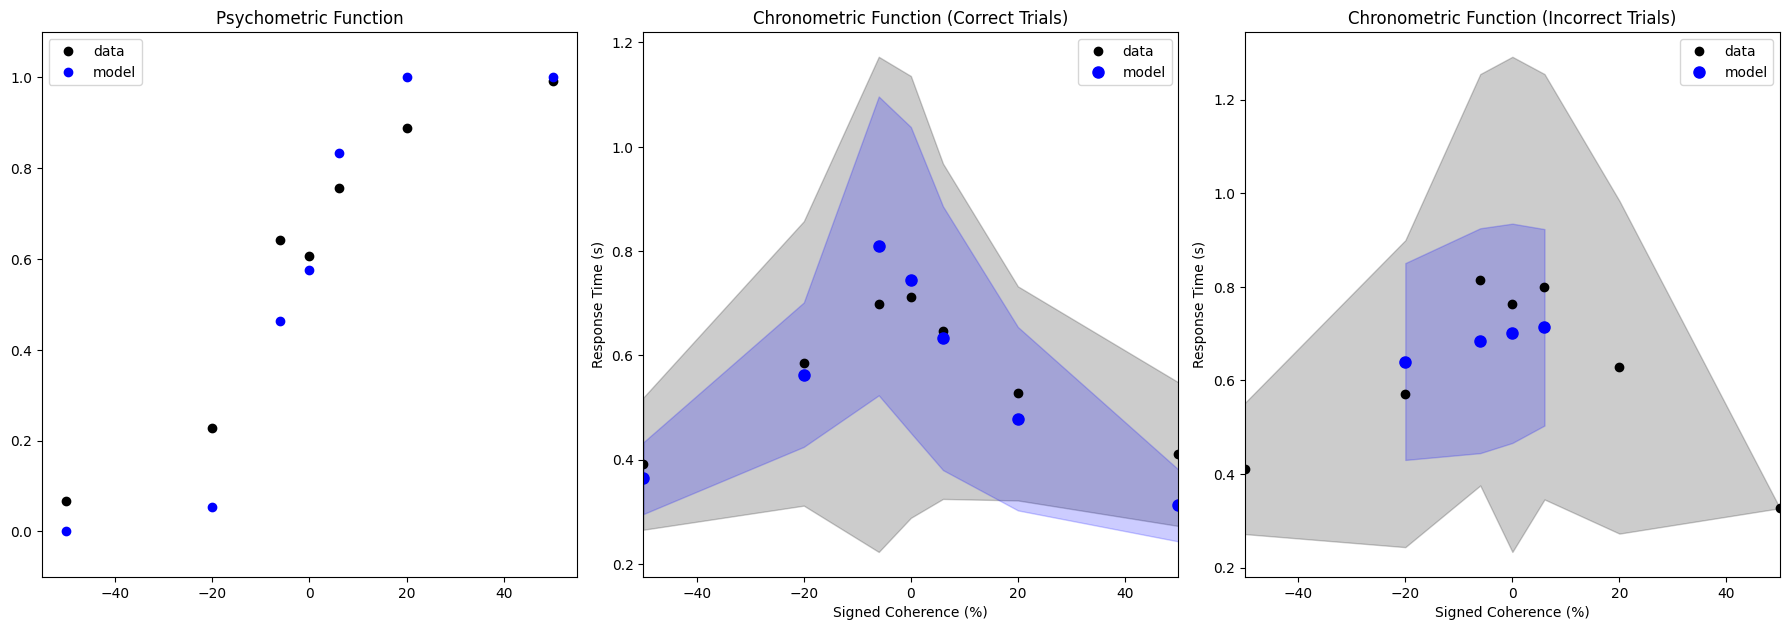

Proportion of invalid trials: 0.0

Session: 210603_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 353 trials
ndt (global): 0.1251
drift_gain (global): 4.5476
variance (global): 3.5125
a (prior 1): 2.2117
z (prior 1): 0.3265
drift_offset (prior 1): 0.2160
leak_rate (global): 0.4522
time_constant (global): 0.0012

Simulation completed. Generated 353 trials.
Valid simulated trials: 353


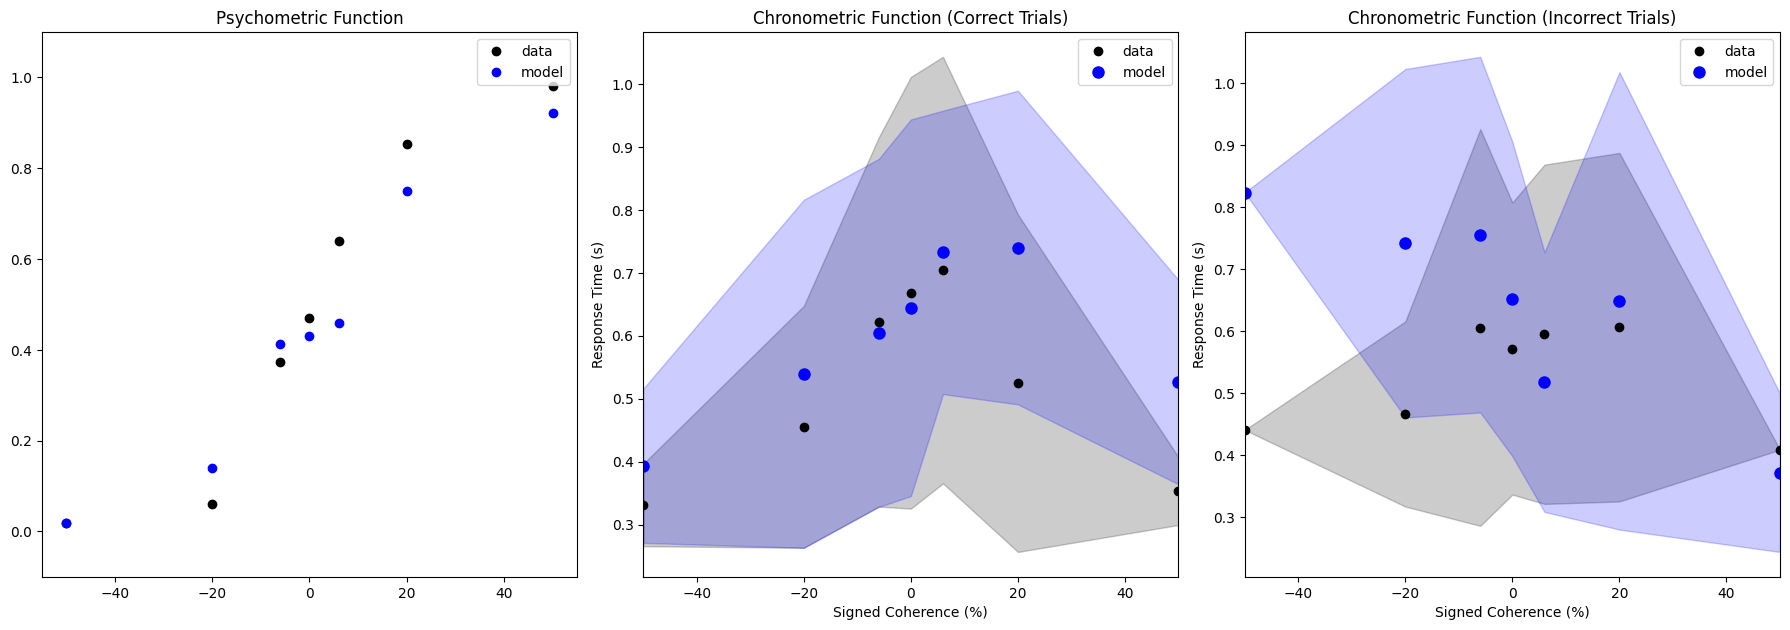

Proportion of invalid trials: 0.0

Session: 210603_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 900 trials
ndt (global): 0.1251
drift_gain (global): 4.5476
variance (global): 3.5125
a (prior 2): 2.3316
z (prior 2): 0.4605
drift_offset (prior 2): 0.5673
leak_rate (global): 0.4522
time_constant (global): 0.0012

Simulation completed. Generated 900 trials.
Valid simulated trials: 900


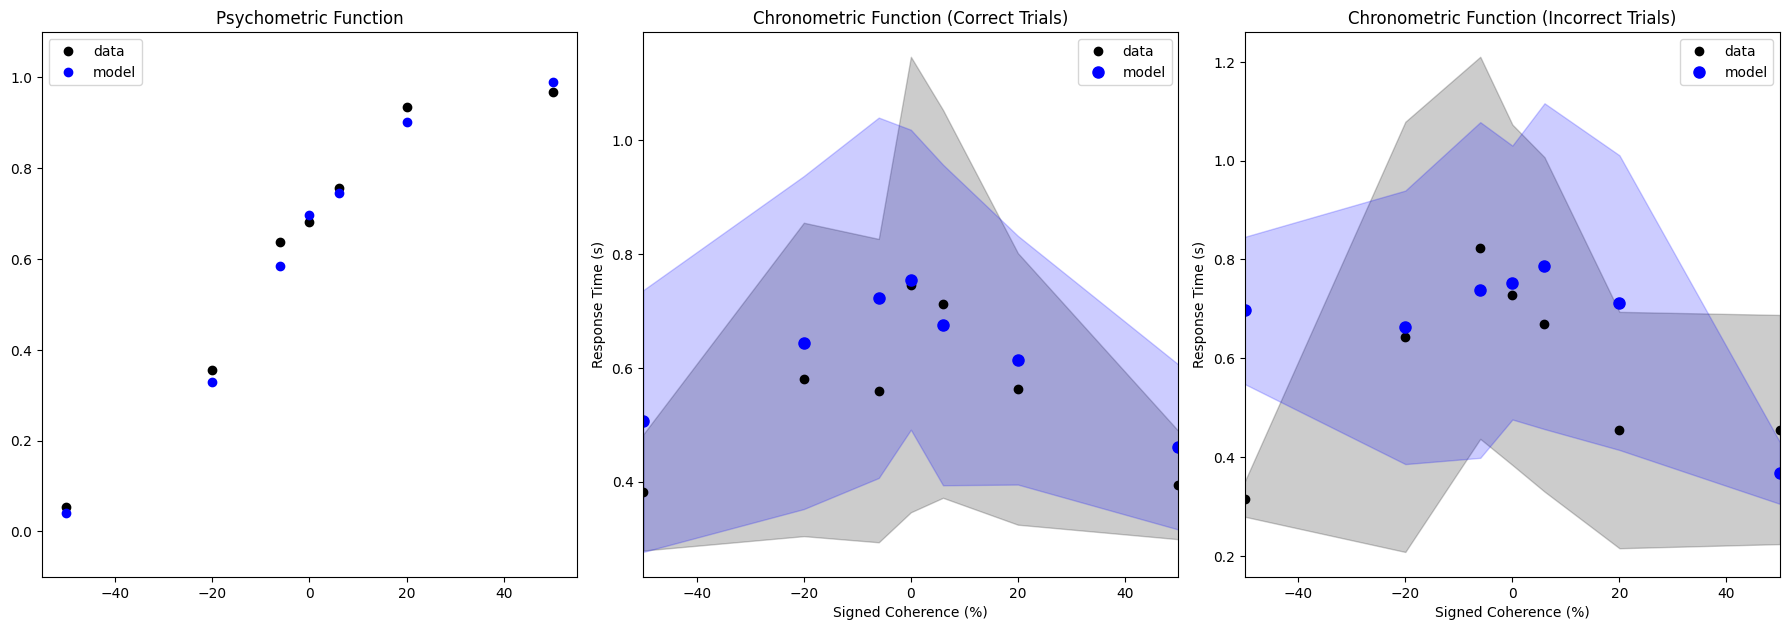

Proportion of invalid trials: 0.0

Session: 210608_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 490 trials
ndt (global): 0.3662
drift_gain (global): 17.2708
variance (global): 4.1138
a (prior 1): 2.4930
z (prior 1): 0.5243
drift_offset (prior 1): 1.3644
leak_rate (global): 0.4733
time_constant (global): 0.0017

Simulation completed. Generated 490 trials.
Valid simulated trials: 490


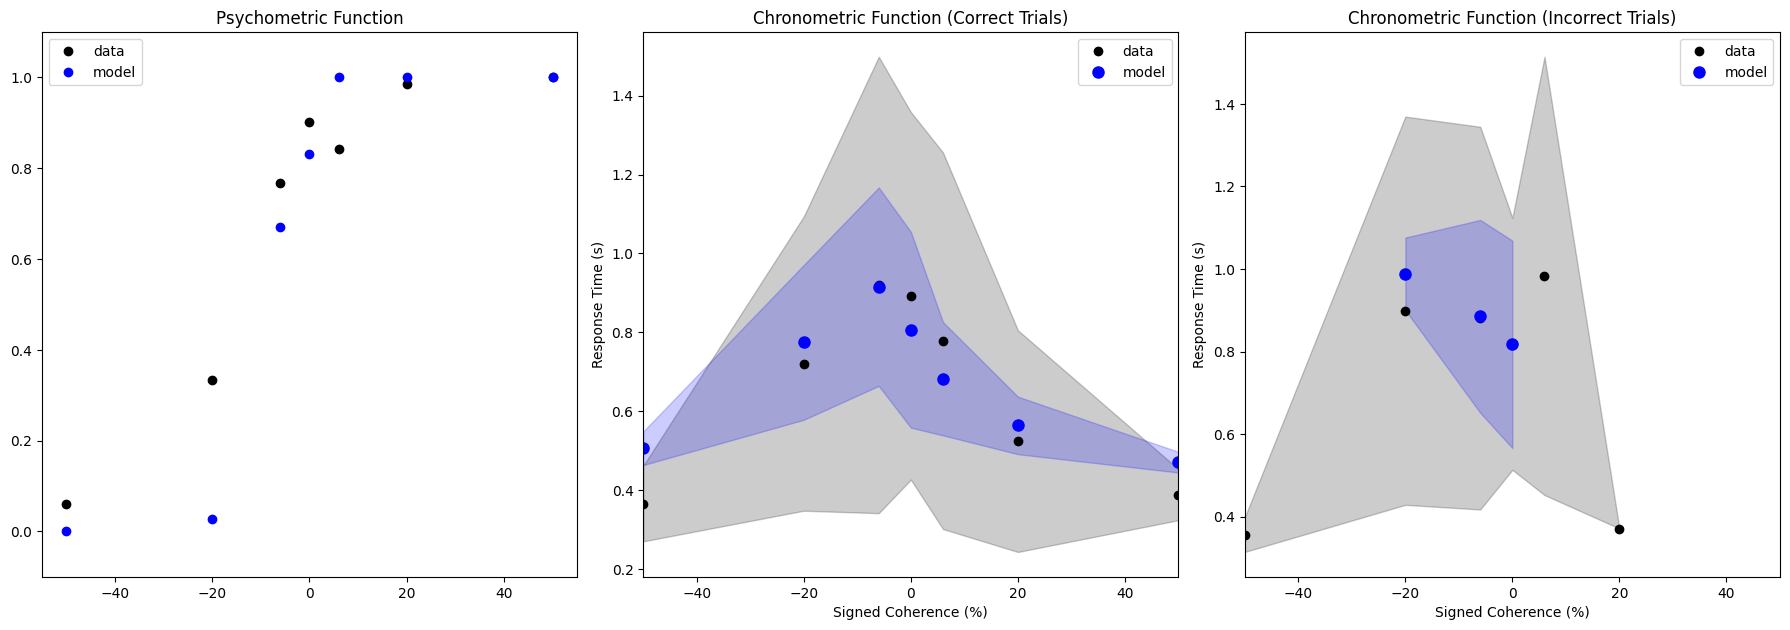

Proportion of invalid trials: 0.0

Session: 210608_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 732 trials
ndt (global): 0.3662
drift_gain (global): 17.2708
variance (global): 4.1138
a (prior 2): 2.5396
z (prior 2): 0.4049
drift_offset (prior 2): 0.0467
leak_rate (global): 0.4733
time_constant (global): 0.0017

Simulation completed. Generated 732 trials.
Valid simulated trials: 732


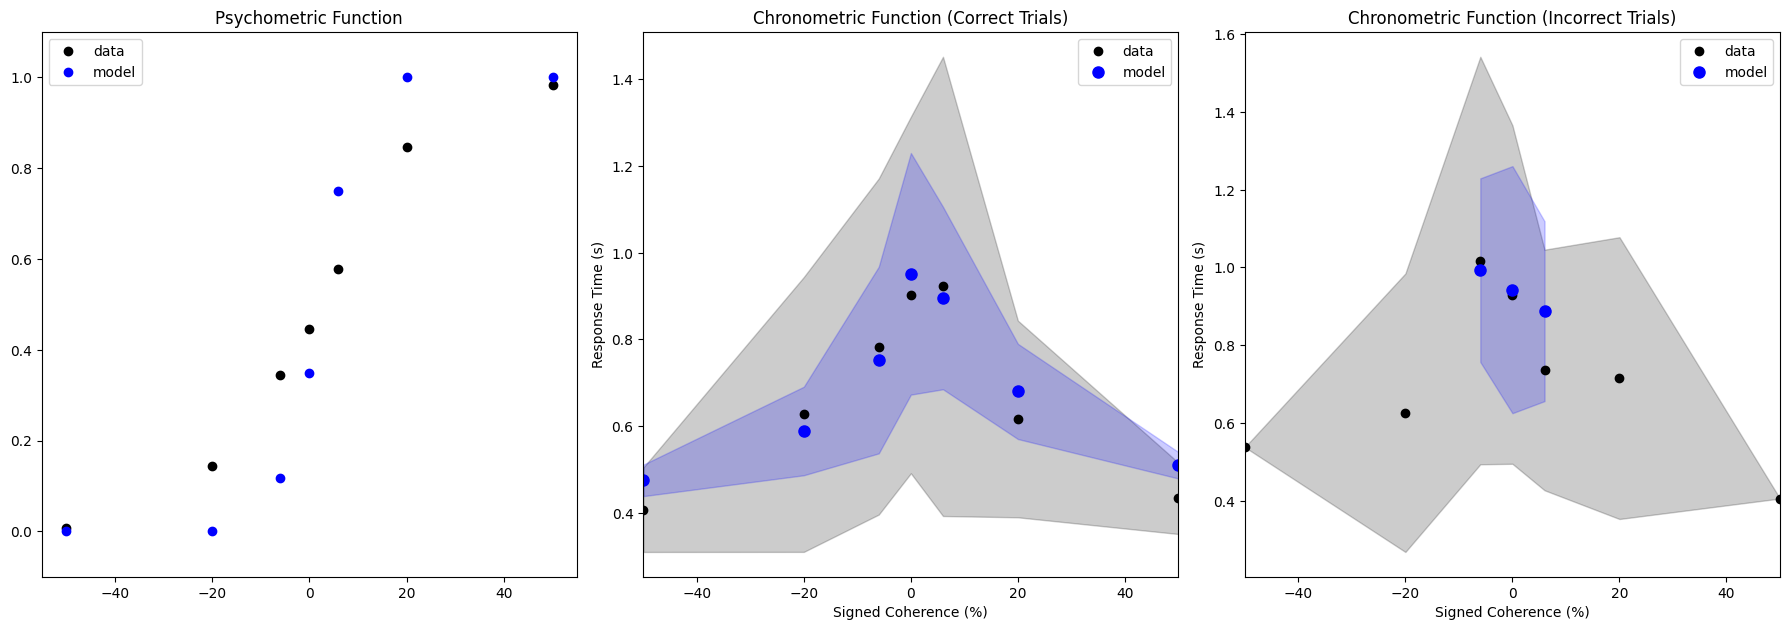

Proportion of invalid trials: 0.0

Session: 210609_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 422 trials
ndt (global): 0.1242
drift_gain (global): 16.4308
variance (global): 4.1037
a (prior 1): 3.7856
z (prior 1): 0.6874
drift_offset (prior 1): -0.4989
leak_rate (global): 0.4842
time_constant (global): 0.0045

Simulation completed. Generated 422 trials.
Valid simulated trials: 422


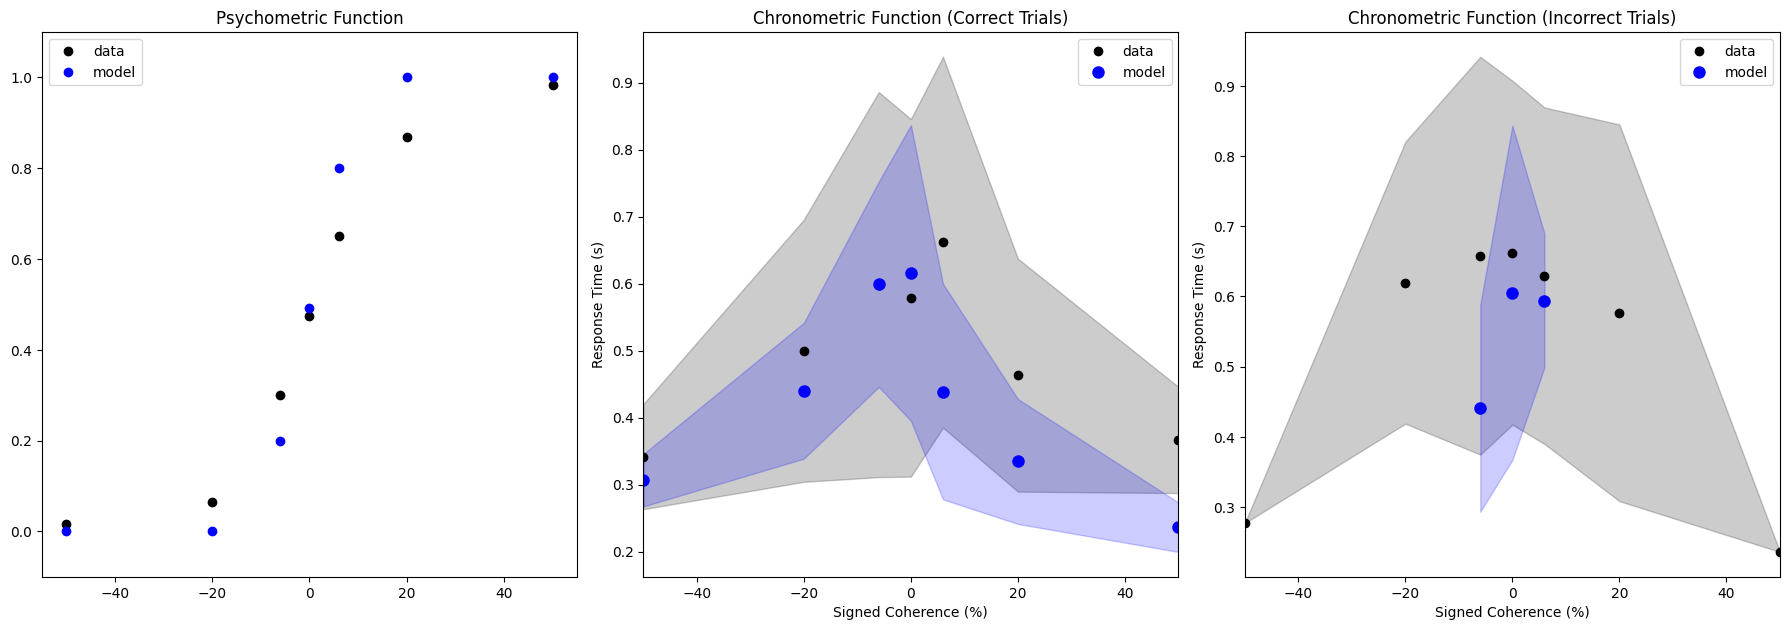

Proportion of invalid trials: 0.0

Session: 210609_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 889 trials
ndt (global): 0.1242
drift_gain (global): 16.4308
variance (global): 4.1037
a (prior 2): 4.4532
z (prior 2): 0.3553
drift_offset (prior 2): 0.7019
leak_rate (global): 0.4842
time_constant (global): 0.0045

Simulation completed. Generated 889 trials.
Valid simulated trials: 889


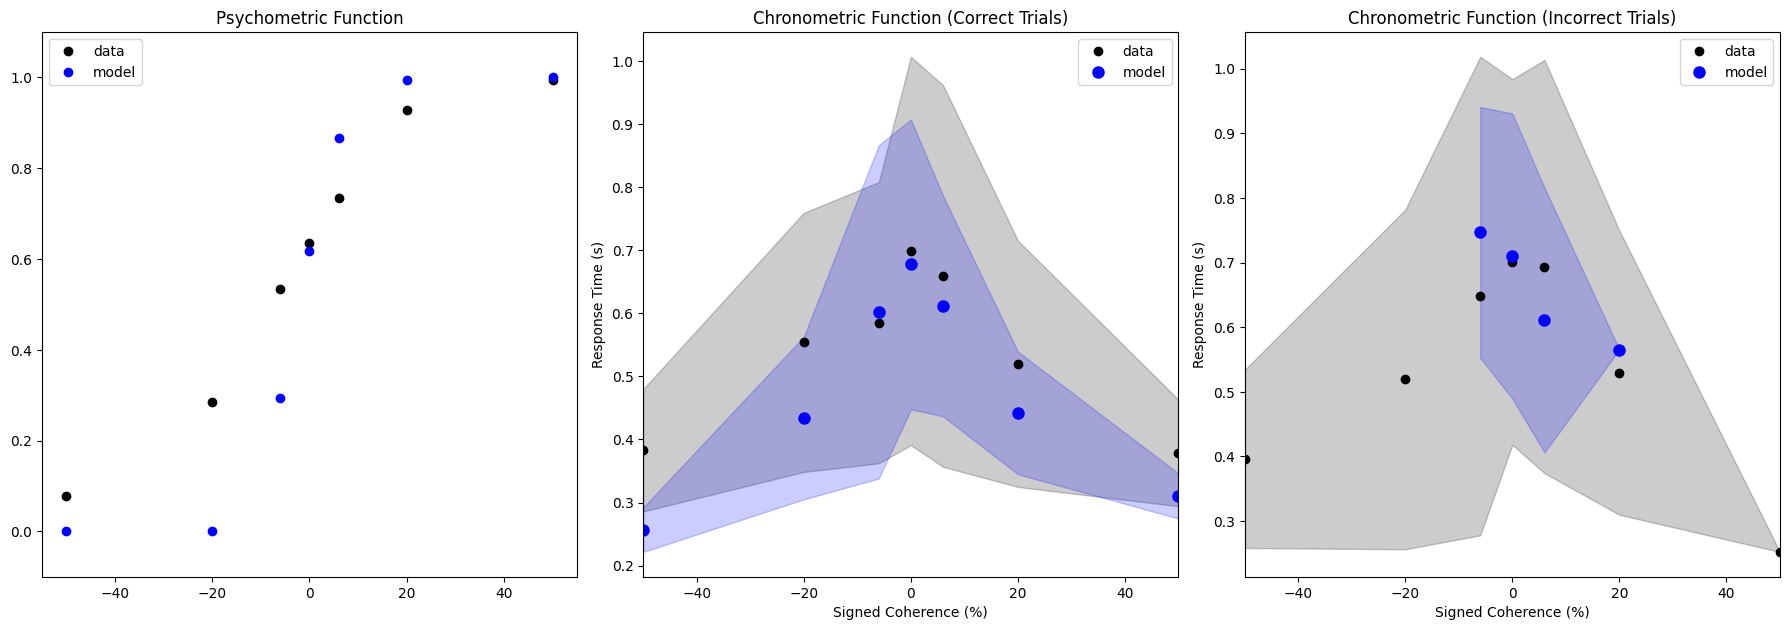

Proportion of invalid trials: 0.0

Session: 210708_GP_JP, Prior: equal (idx: 0)
Prior condition 'equal' has 441 trials
ndt (global): 0.1605
drift_gain (global): 16.1398
variance (global): 1.5517
a (prior 1): 4.7577
z (prior 1): 0.4720
drift_offset (prior 1): 0.1318
leak_rate (global): 0.2576
time_constant (global): 0.0020

Simulation completed. Generated 441 trials.
Valid simulated trials: 441


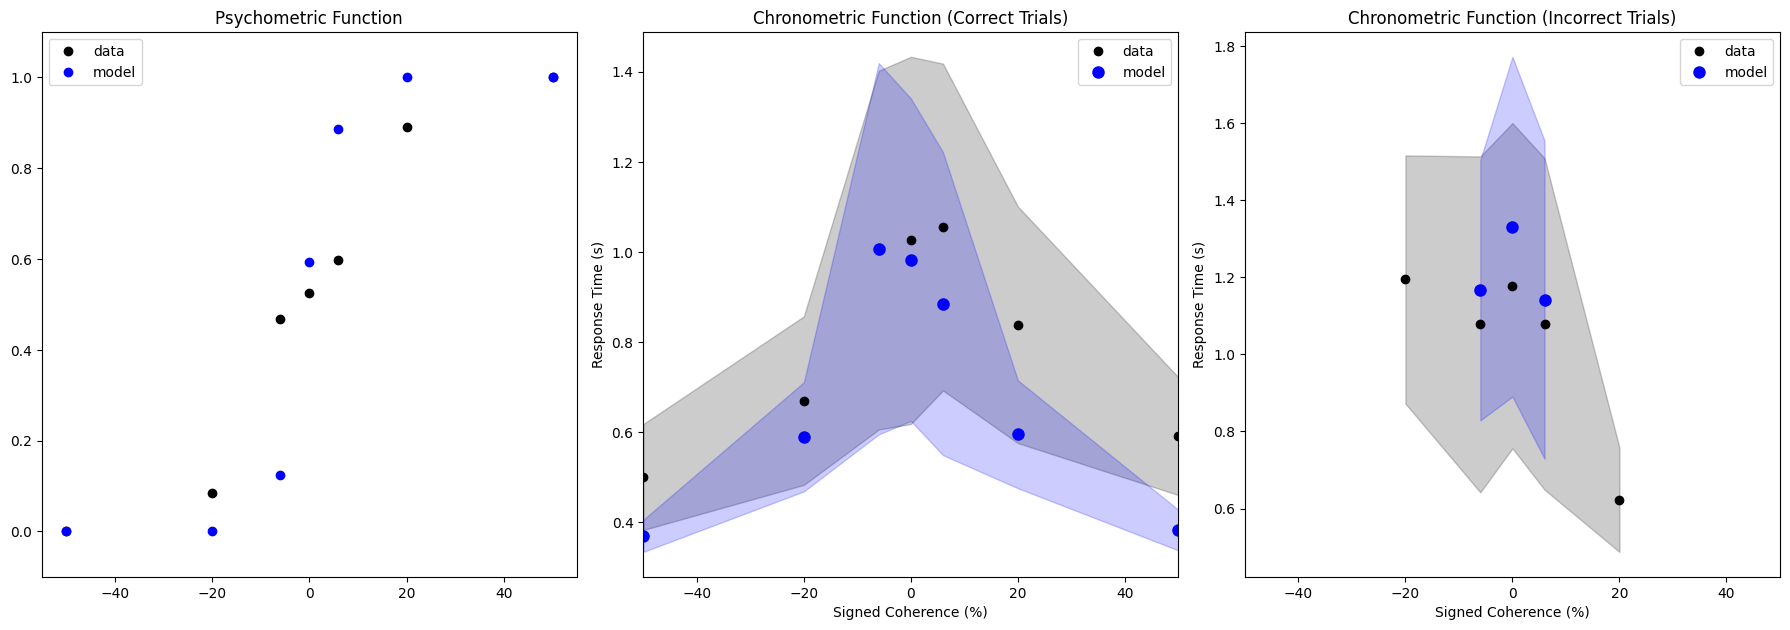

Proportion of invalid trials: 0.0

Session: 210708_GP_JP, Prior: unequal (idx: 1)
Prior condition 'unequal' has 321 trials
ndt (global): 0.1605
drift_gain (global): 16.1398
variance (global): 1.5517
a (prior 2): 3.8502
z (prior 2): 0.4049
drift_offset (prior 2): -0.4107
leak_rate (global): 0.2576
time_constant (global): 0.0020

Simulation completed. Generated 321 trials.
Valid simulated trials: 321


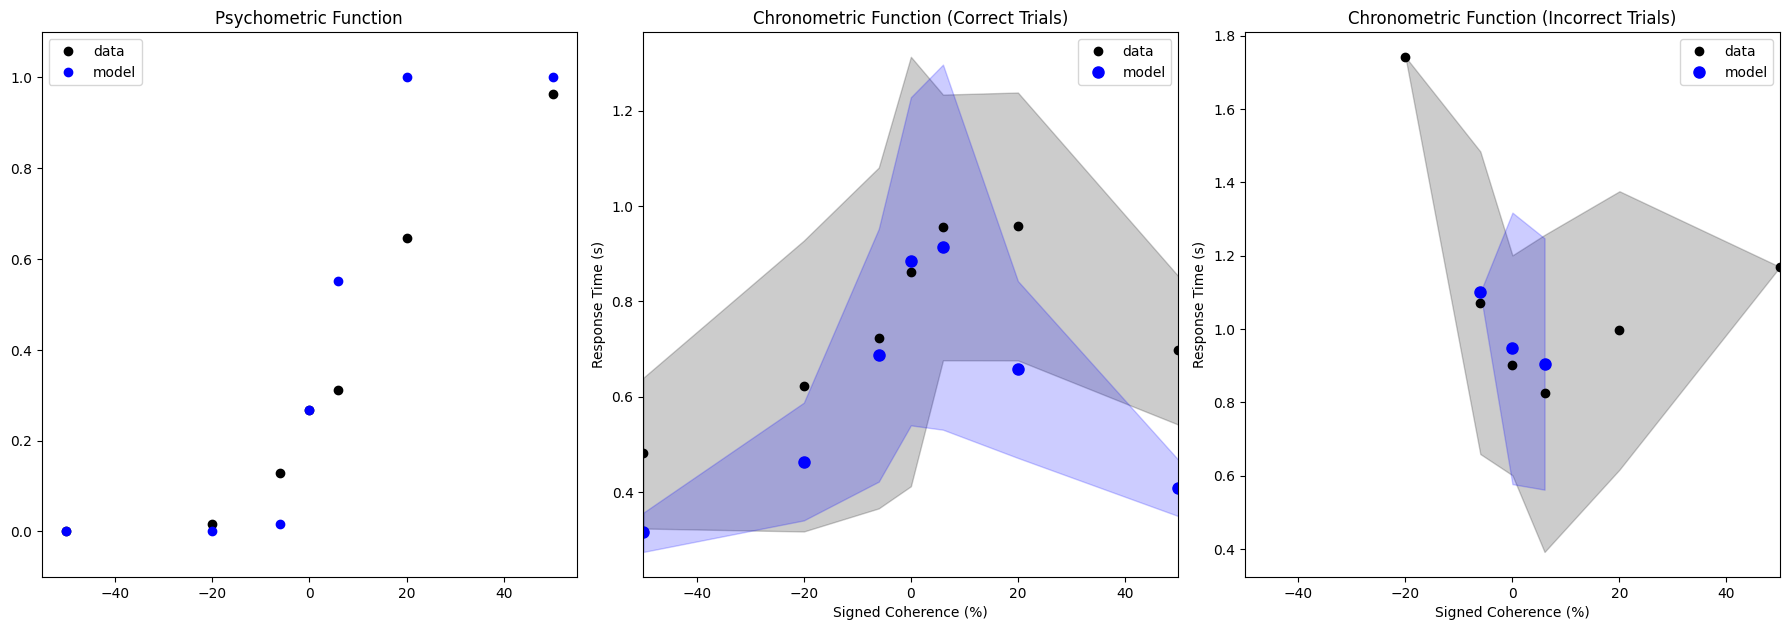

Proportion of invalid trials: 0.0

Session: 240625_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 511 trials
ndt (global): 0.1467
drift_gain (global): 16.1819
variance (global): 0.1517
a (prior 1): 5.7669
z (prior 1): 0.1159
drift_offset (prior 1): 0.5525
leak_rate (global): 0.6527
time_constant (global): 0.0077

Simulation completed. Generated 511 trials.
Valid simulated trials: 511


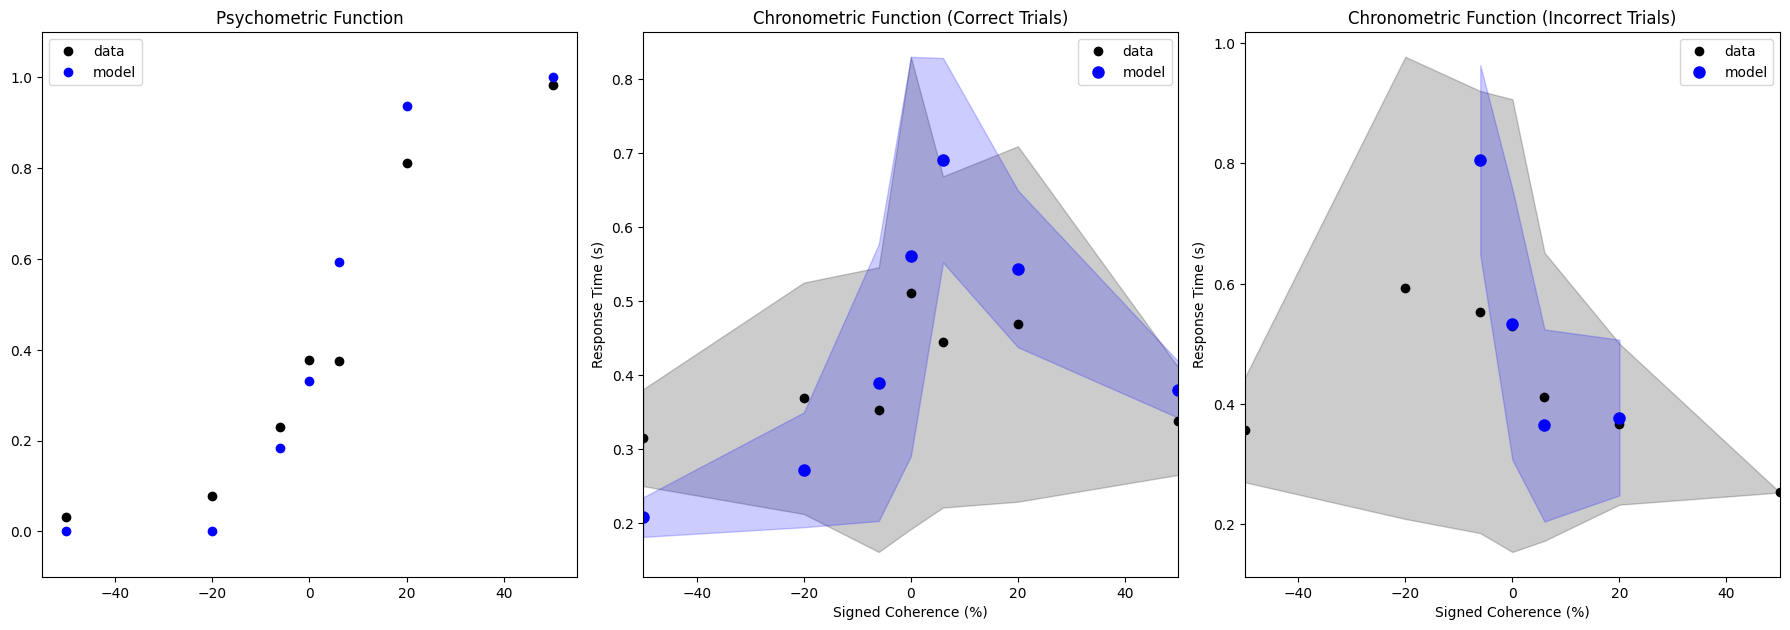

Proportion of invalid trials: 0.0

Session: 240625_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 727 trials
ndt (global): 0.1467
drift_gain (global): 16.1819
variance (global): 0.1517
a (prior 2): 4.4042
z (prior 2): 0.5187
drift_offset (prior 2): 0.6909
leak_rate (global): 0.6527
time_constant (global): 0.0077

Simulation completed. Generated 727 trials.
Valid simulated trials: 727


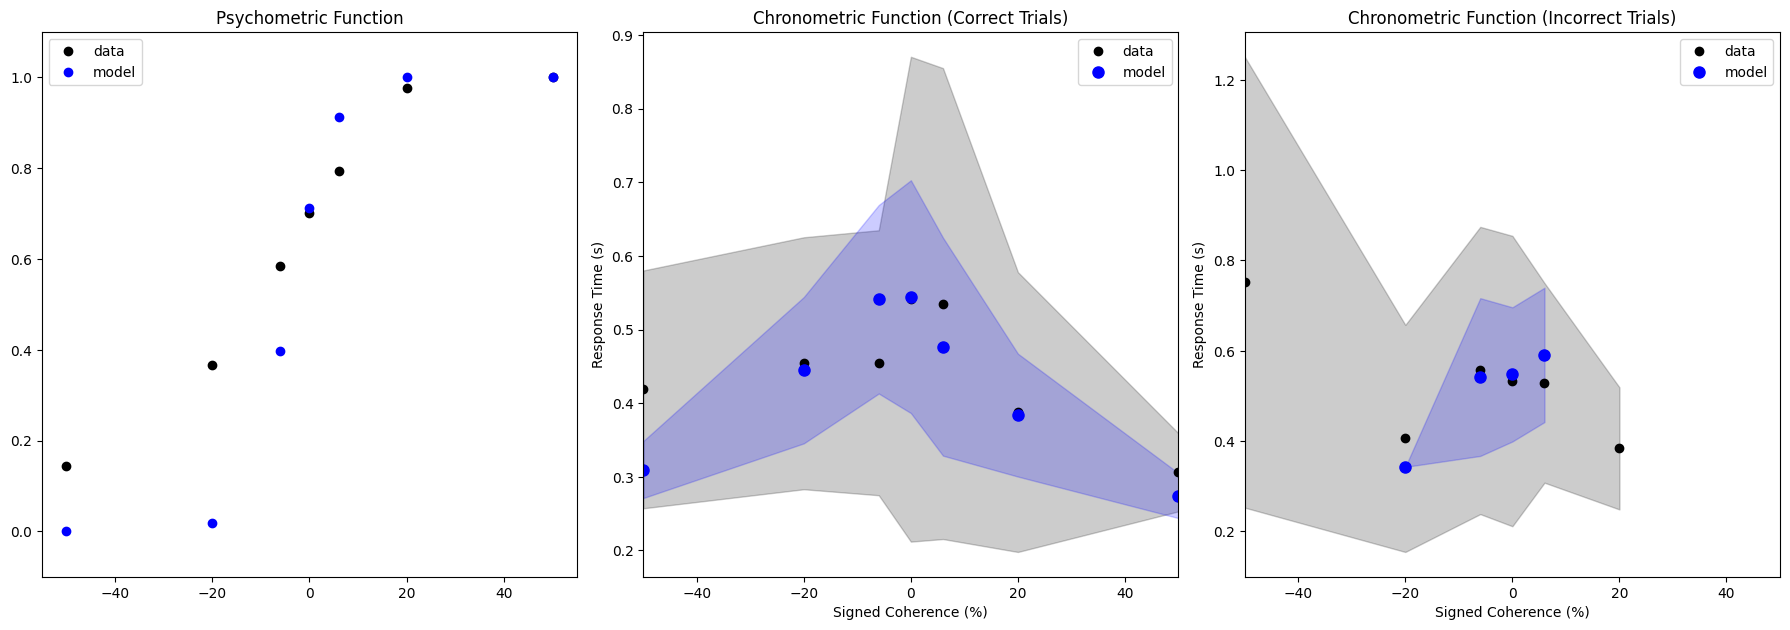

Proportion of invalid trials: 0.0

Session: 240805_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 457 trials
ndt (global): 0.1074
drift_gain (global): 9.3012
variance (global): 3.9226
a (prior 1): 2.0324
z (prior 1): 0.2965
drift_offset (prior 1): 0.6488
leak_rate (global): 0.3559
time_constant (global): 0.0010

Simulation completed. Generated 457 trials.
Valid simulated trials: 457


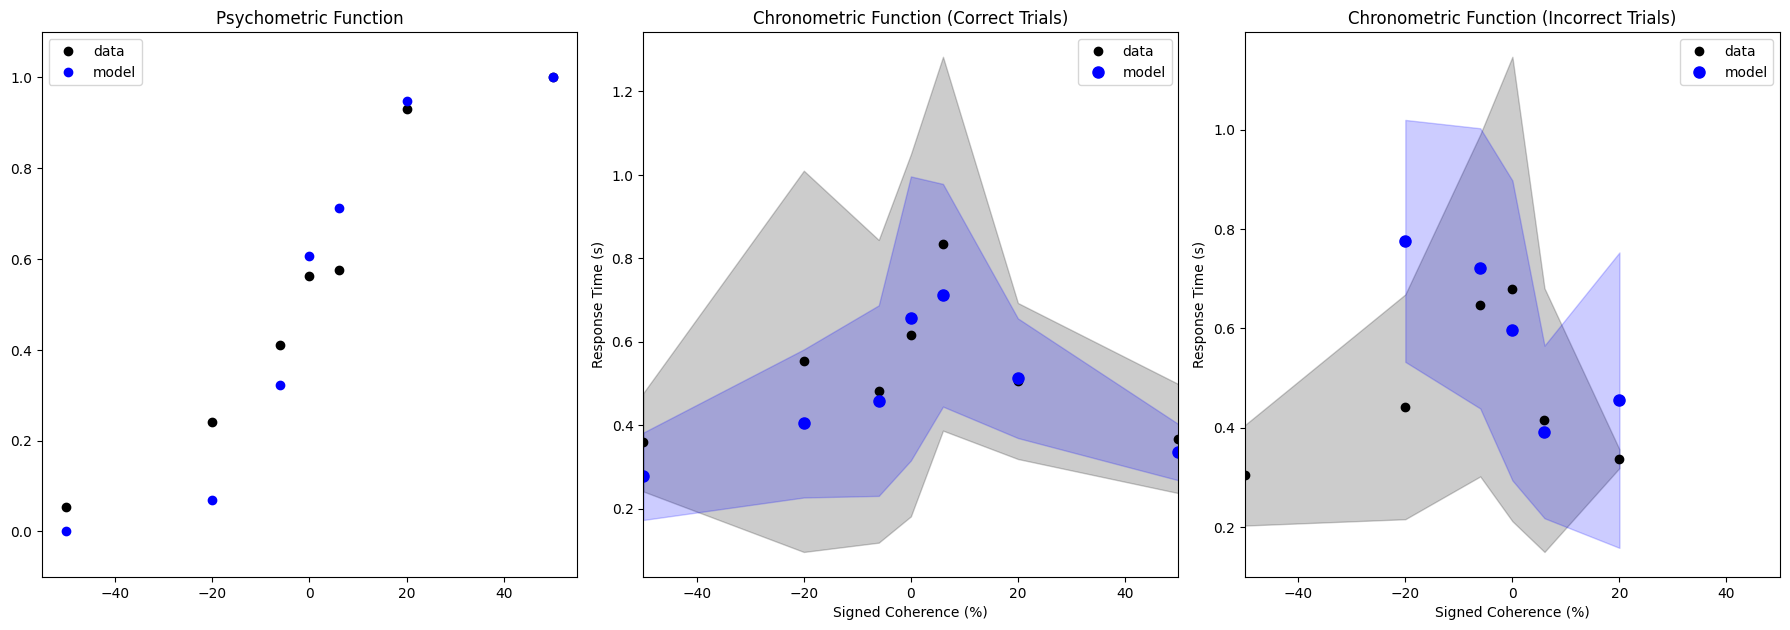

Proportion of invalid trials: 0.0

Session: 240805_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 679 trials
ndt (global): 0.1074
drift_gain (global): 9.3012
variance (global): 3.9226
a (prior 2): 1.8766
z (prior 2): 0.1938
drift_offset (prior 2): 0.0714
leak_rate (global): 0.3559
time_constant (global): 0.0010

Simulation completed. Generated 679 trials.
Valid simulated trials: 679


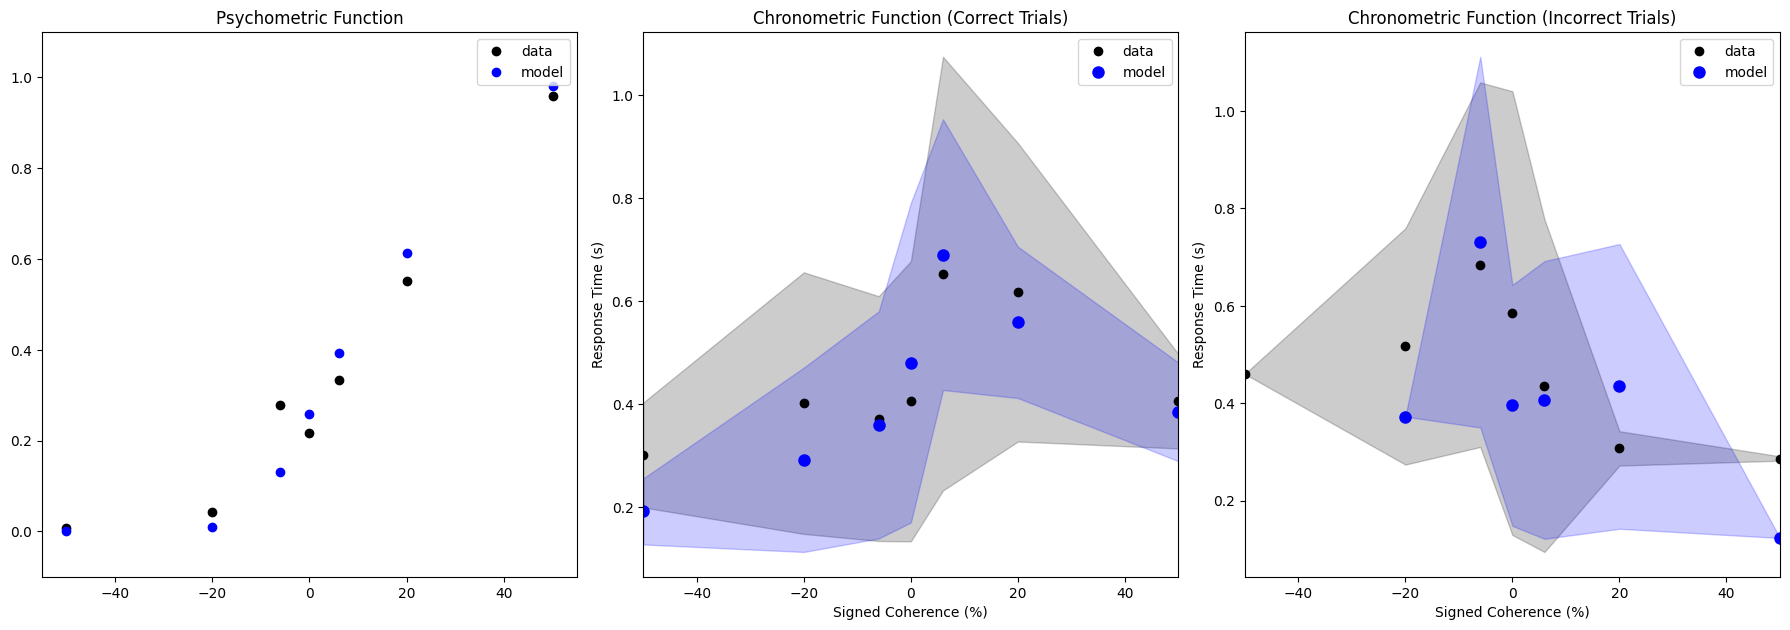

Proportion of invalid trials: 0.0

Session: 240809_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 507 trials
ndt (global): 0.1973
drift_gain (global): 19.8683
variance (global): 0.3728
a (prior 1): 1.8411
z (prior 1): 0.5719
drift_offset (prior 1): -0.4245
leak_rate (global): 0.4858
time_constant (global): 0.0014

Simulation completed. Generated 507 trials.
Valid simulated trials: 507


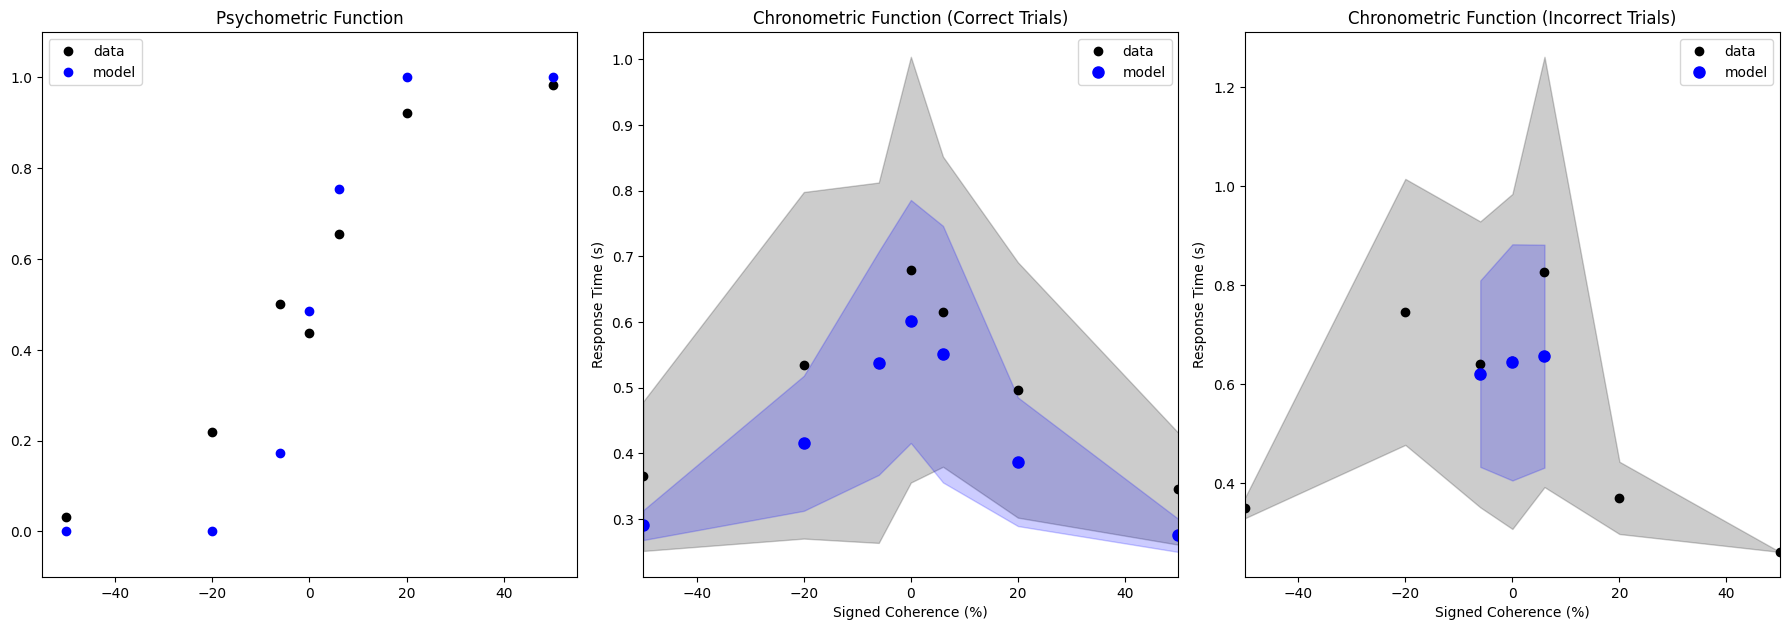

Proportion of invalid trials: 0.0

Session: 240809_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 701 trials
ndt (global): 0.1973
drift_gain (global): 19.8683
variance (global): 0.3728
a (prior 2): 2.4033
z (prior 2): 0.5588
drift_offset (prior 2): 0.5967
leak_rate (global): 0.4858
time_constant (global): 0.0014

Simulation completed. Generated 701 trials.
Valid simulated trials: 701


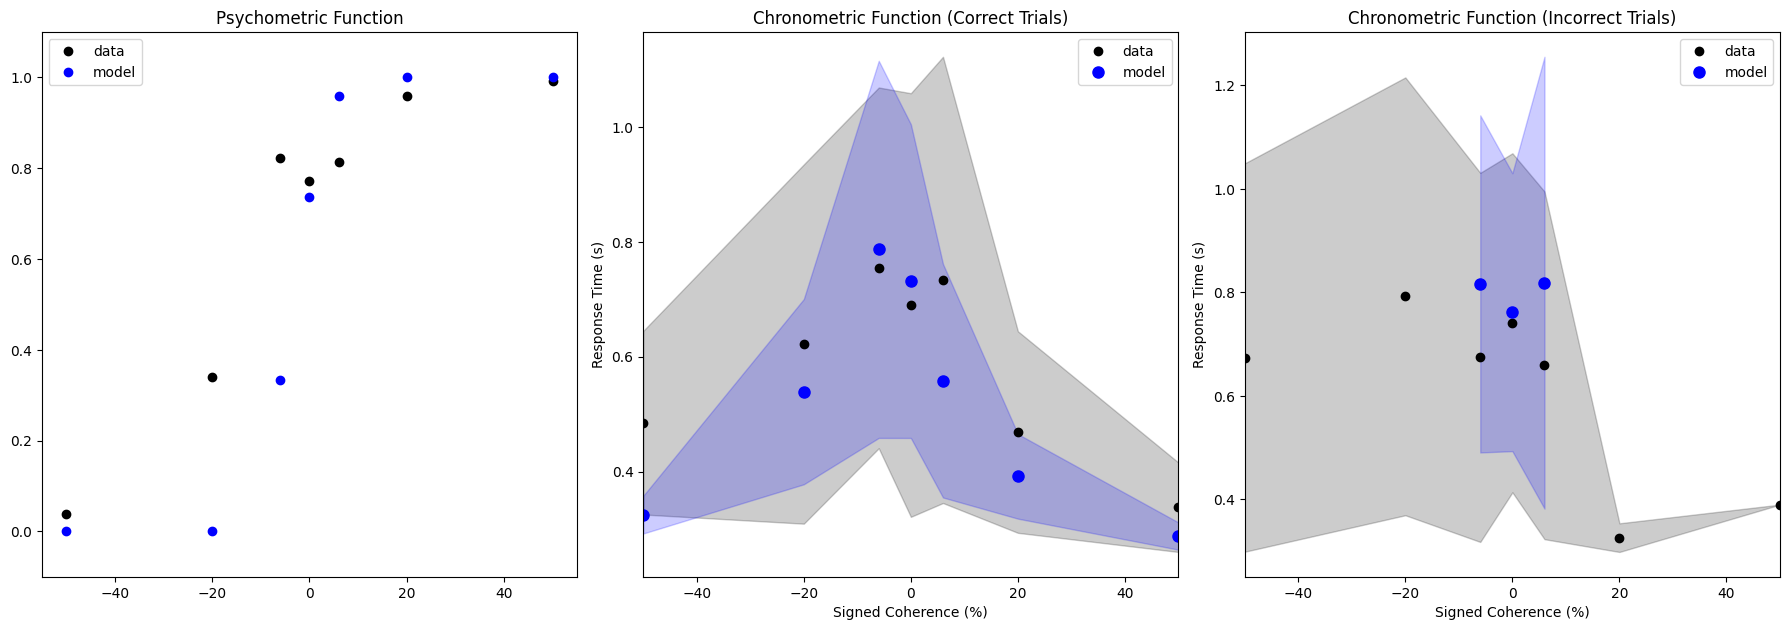

Proportion of invalid trials: 0.0

Session: 240903_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 546 trials
ndt (global): 0.1111
drift_gain (global): 16.3666
variance (global): 1.9500
a (prior 1): 3.4268
z (prior 1): 0.5846
drift_offset (prior 1): -0.3886
leak_rate (global): 0.5673
time_constant (global): 0.0031

Simulation completed. Generated 546 trials.
Valid simulated trials: 546


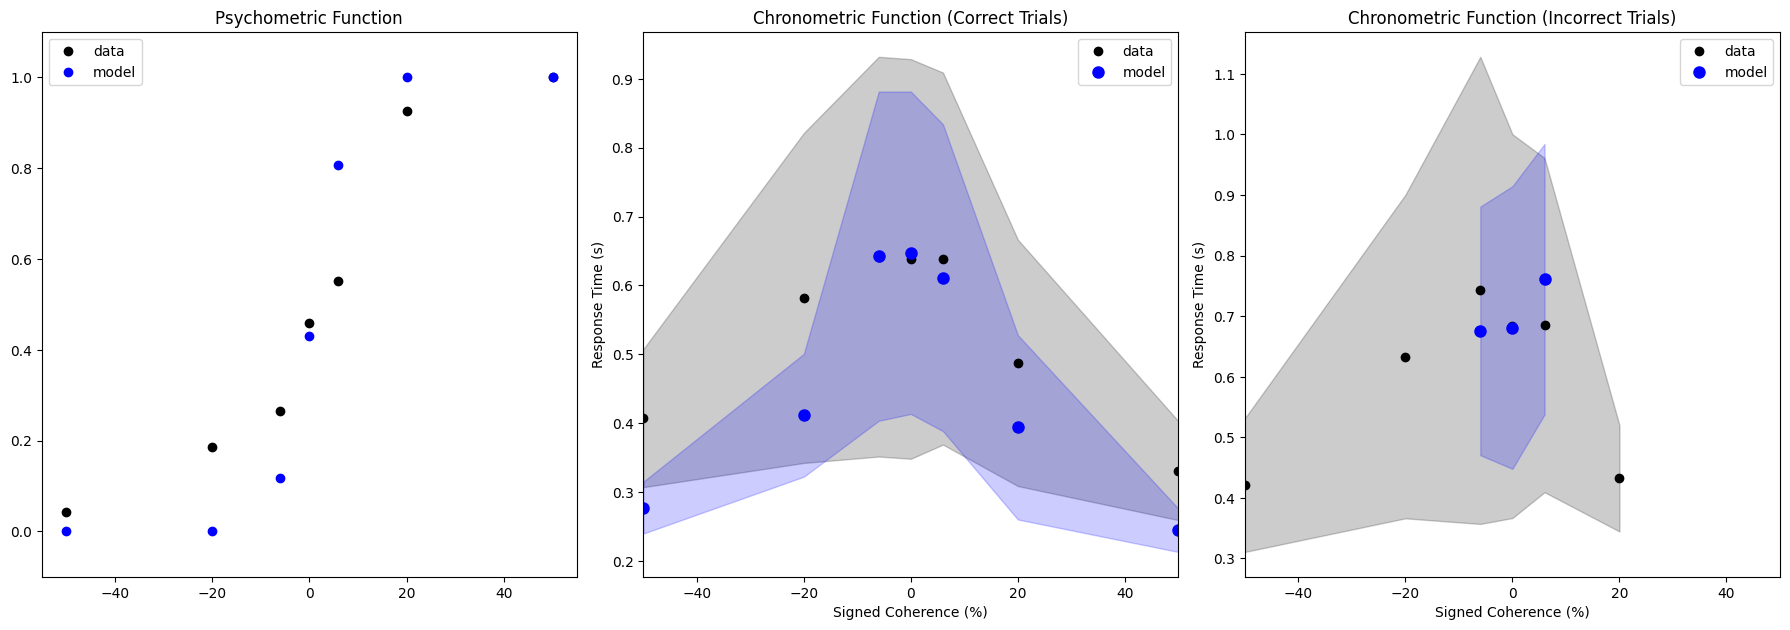

Proportion of invalid trials: 0.0

Session: 240903_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 686 trials
ndt (global): 0.1111
drift_gain (global): 16.3666
variance (global): 1.9500
a (prior 2): 3.4157
z (prior 2): 0.4188
drift_offset (prior 2): -0.6564
leak_rate (global): 0.5673
time_constant (global): 0.0031

Simulation completed. Generated 686 trials.
Valid simulated trials: 686


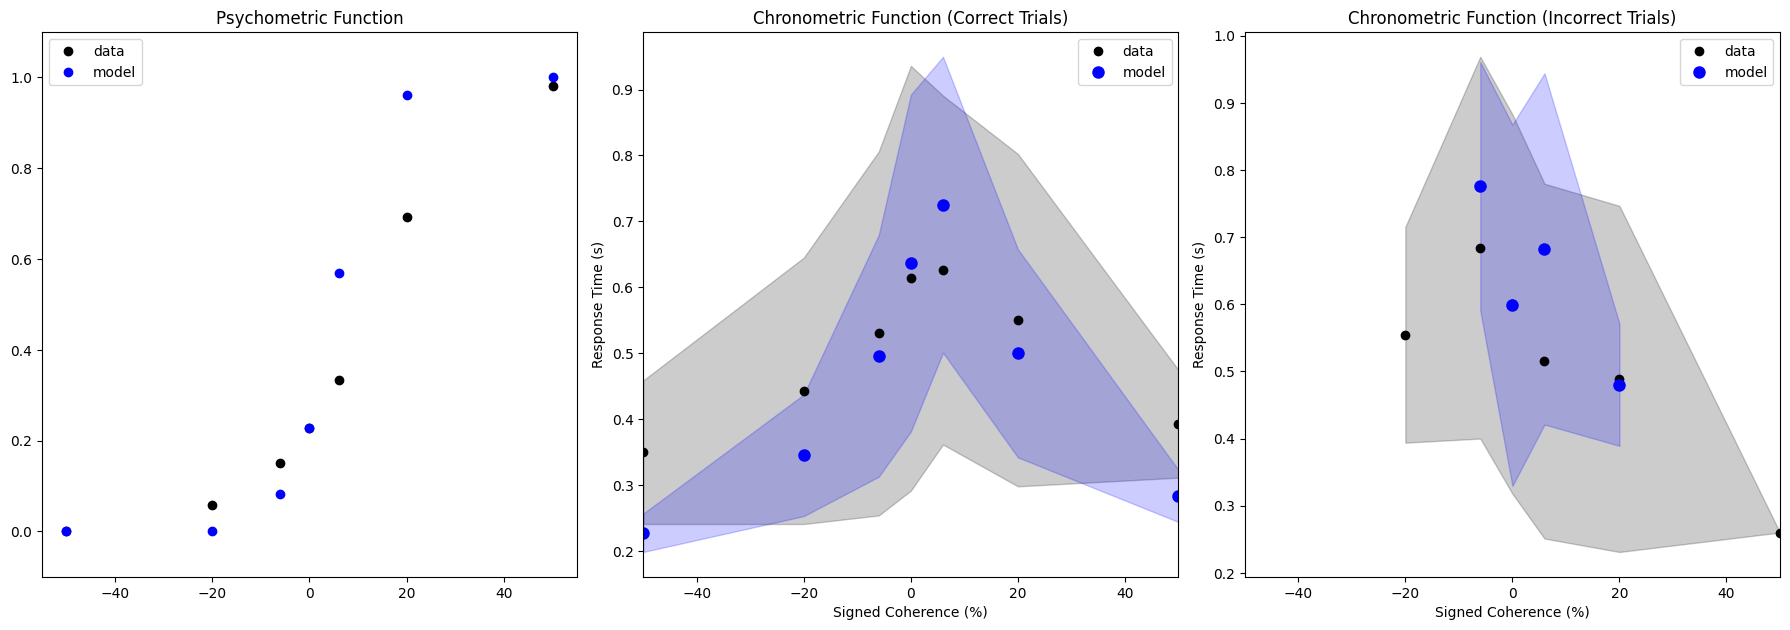

Proportion of invalid trials: 0.0

Session: 241129_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 549 trials
ndt (global): 0.2878
drift_gain (global): 8.2262
variance (global): 1.6771
a (prior 1): 1.9968
z (prior 1): 0.2929
drift_offset (prior 1): -0.7183
leak_rate (global): 0.6432
time_constant (global): 0.0020

Simulation completed. Generated 549 trials.
Valid simulated trials: 549


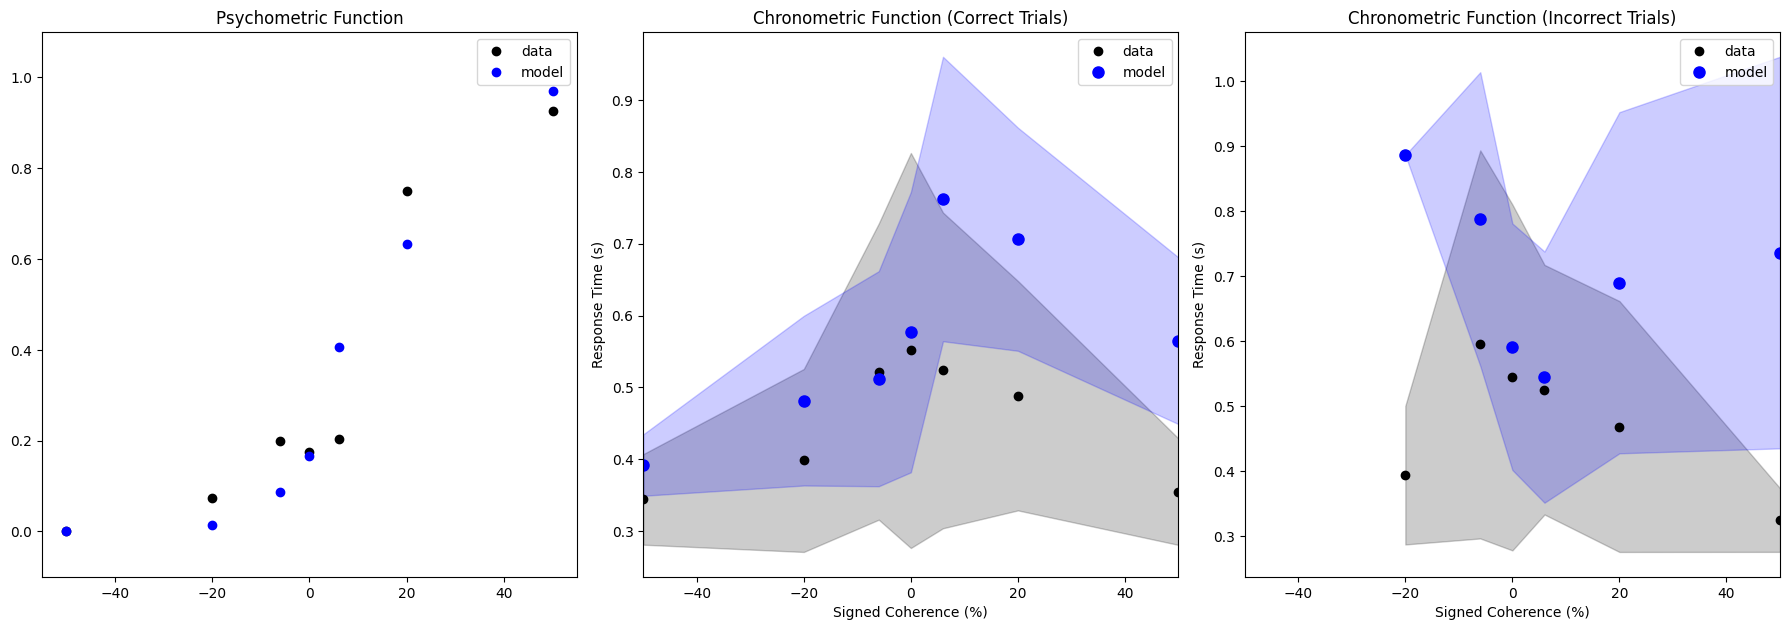

Proportion of invalid trials: 0.0

Session: 241129_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 684 trials
ndt (global): 0.2878
drift_gain (global): 8.2262
variance (global): 1.6771
a (prior 2): 1.8714
z (prior 2): 0.7004
drift_offset (prior 2): -0.6292
leak_rate (global): 0.6432
time_constant (global): 0.0020

Simulation completed. Generated 684 trials.
Valid simulated trials: 684


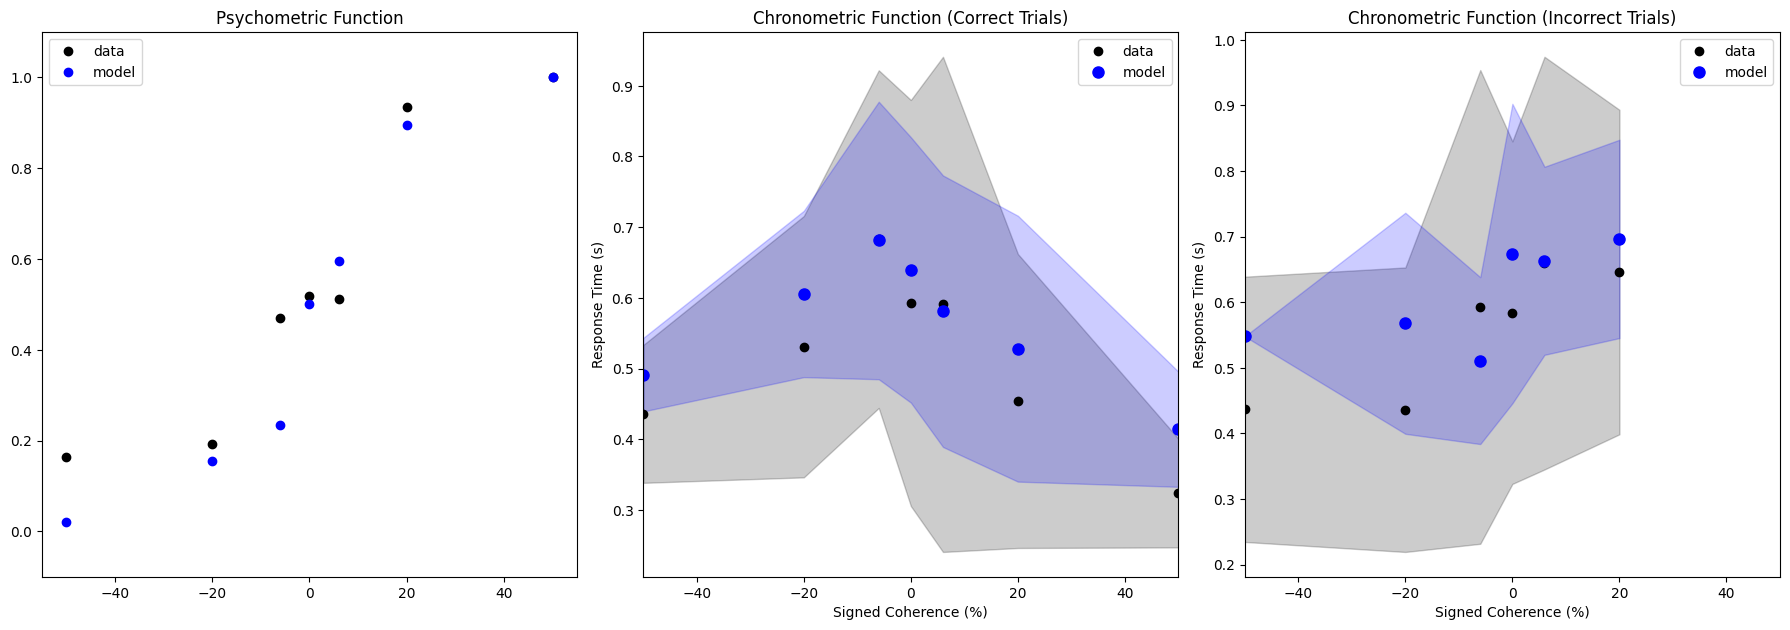

Proportion of invalid trials: 0.0

Session: 241130_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 496 trials
ndt (global): 0.1173
drift_gain (global): 3.8634
variance (global): 3.2819
a (prior 1): 4.3977
z (prior 1): 0.6984
drift_offset (prior 1): -0.7030
leak_rate (global): 0.6571
time_constant (global): 0.0057

Simulation completed. Generated 496 trials.
Valid simulated trials: 496


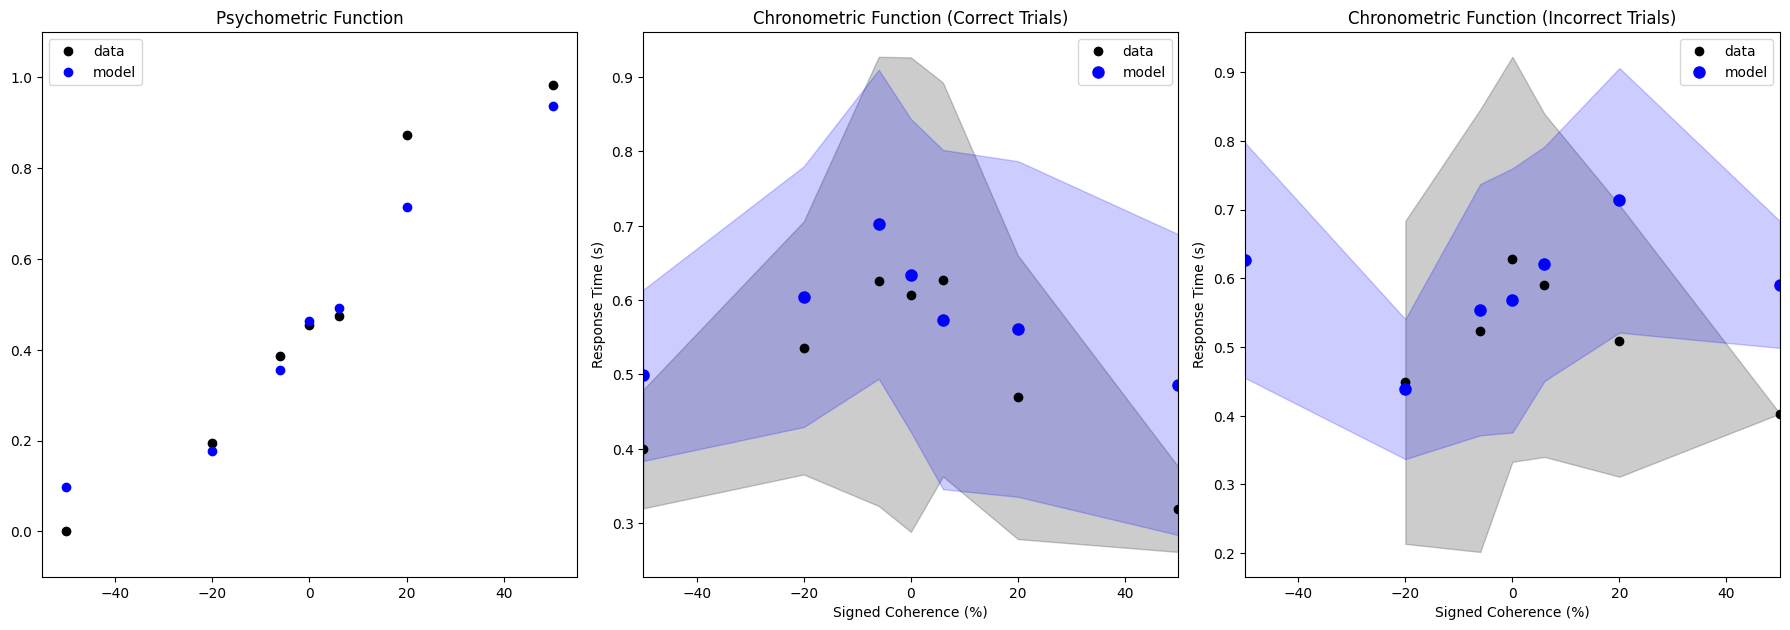

Proportion of invalid trials: 0.0

Session: 241130_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 719 trials
ndt (global): 0.1173
drift_gain (global): 3.8634
variance (global): 3.2819
a (prior 2): 4.4305
z (prior 2): 0.4806
drift_offset (prior 2): -0.6600
leak_rate (global): 0.6571
time_constant (global): 0.0057

Simulation completed. Generated 719 trials.
Valid simulated trials: 719


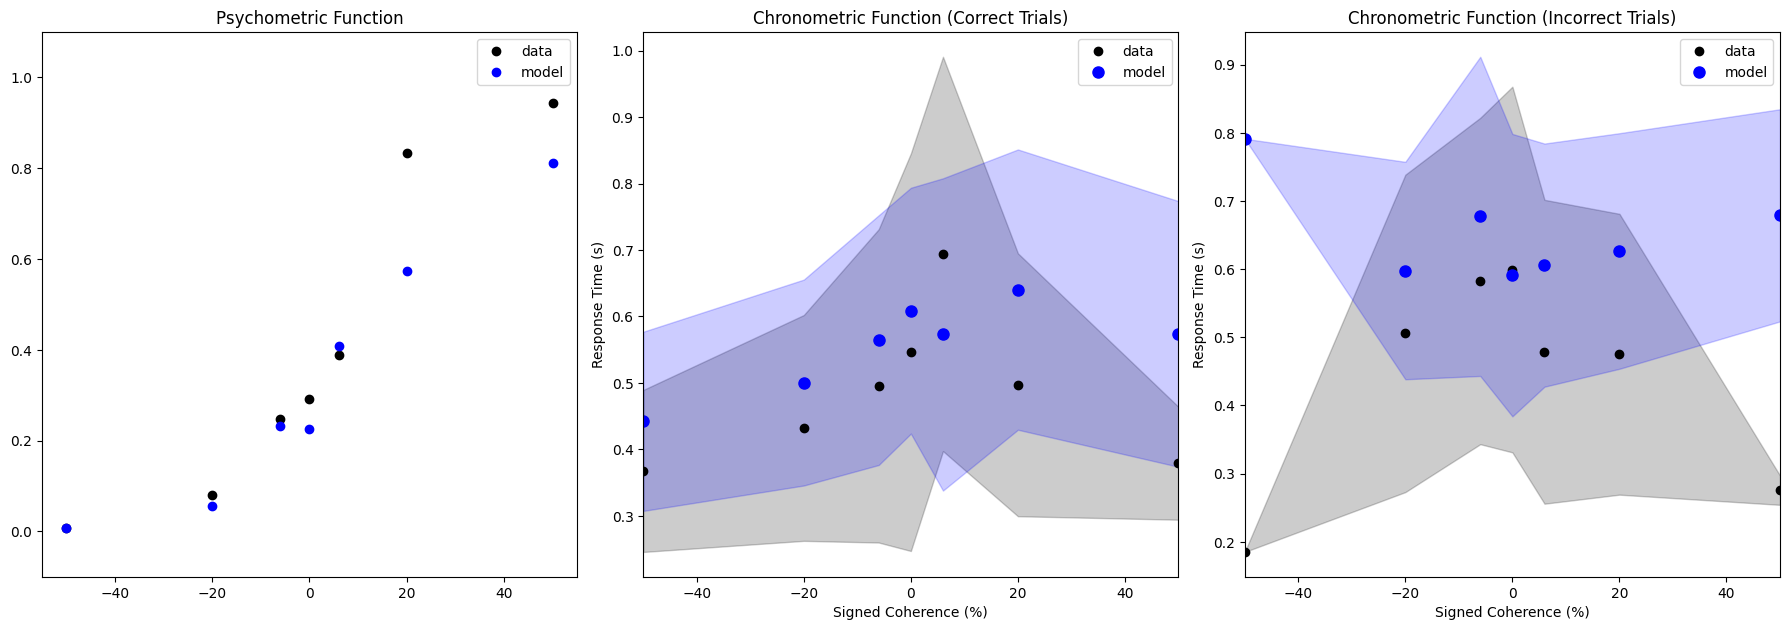

Proportion of invalid trials: 0.0

Session: 241211_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 545 trials
ndt (global): 0.1008
drift_gain (global): 16.2737
variance (global): 4.5281
a (prior 1): 3.8701
z (prior 1): 0.3293
drift_offset (prior 1): -0.3701
leak_rate (global): 0.4755
time_constant (global): 0.0032

Simulation completed. Generated 545 trials.
Valid simulated trials: 545


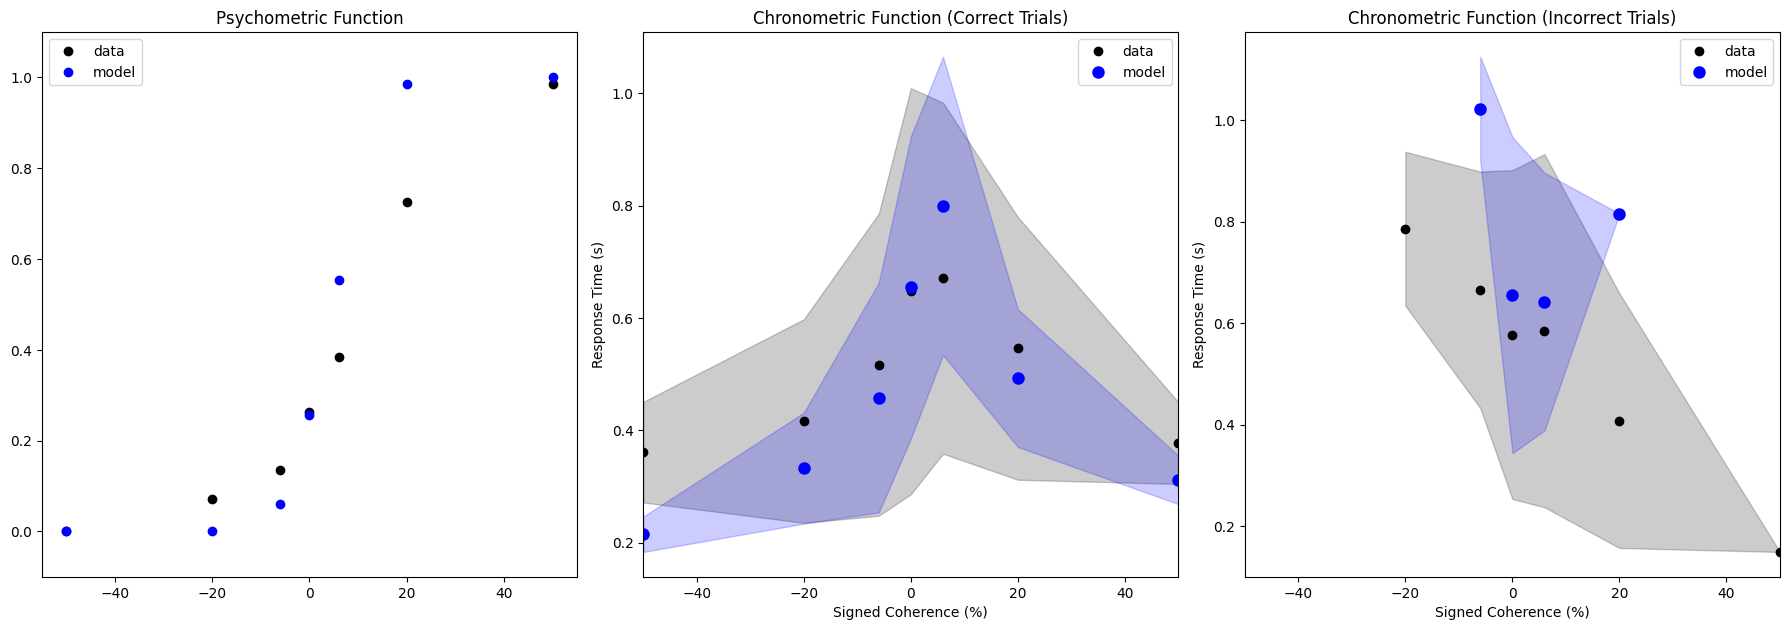

Proportion of invalid trials: 0.0

Session: 241211_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 634 trials
ndt (global): 0.1008
drift_gain (global): 16.2737
variance (global): 4.5281
a (prior 2): 4.1453
z (prior 2): 0.3142
drift_offset (prior 2): 0.7087
leak_rate (global): 0.4755
time_constant (global): 0.0032

Simulation completed. Generated 634 trials.
Valid simulated trials: 634


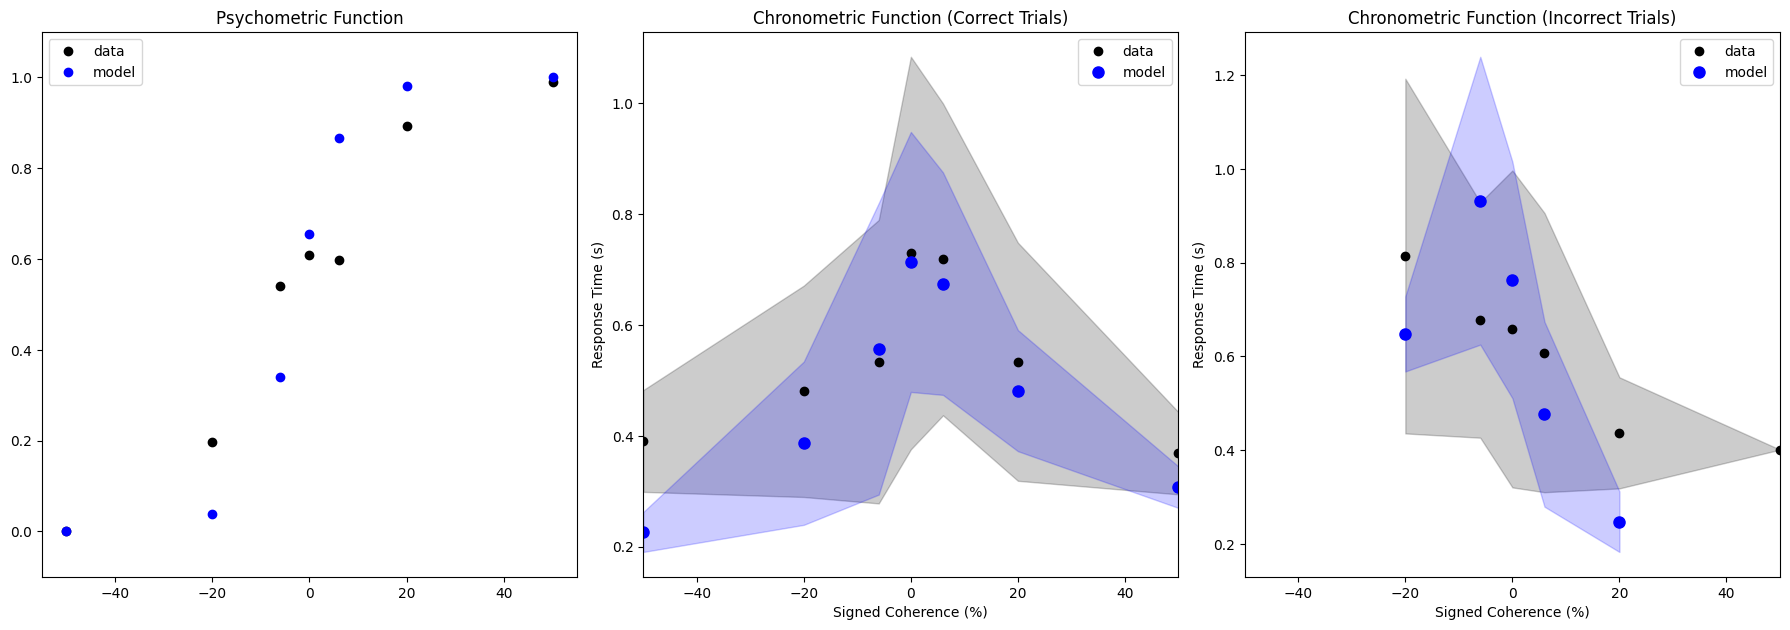

Proportion of invalid trials: 0.0

Session: 241216_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 498 trials
ndt (global): 0.1002
drift_gain (global): 5.2552
variance (global): 2.6969
a (prior 1): 5.9600
z (prior 1): 0.1144
drift_offset (prior 1): 0.4462
leak_rate (global): 0.6256
time_constant (global): 0.0037

Simulation completed. Generated 498 trials.
Valid simulated trials: 498


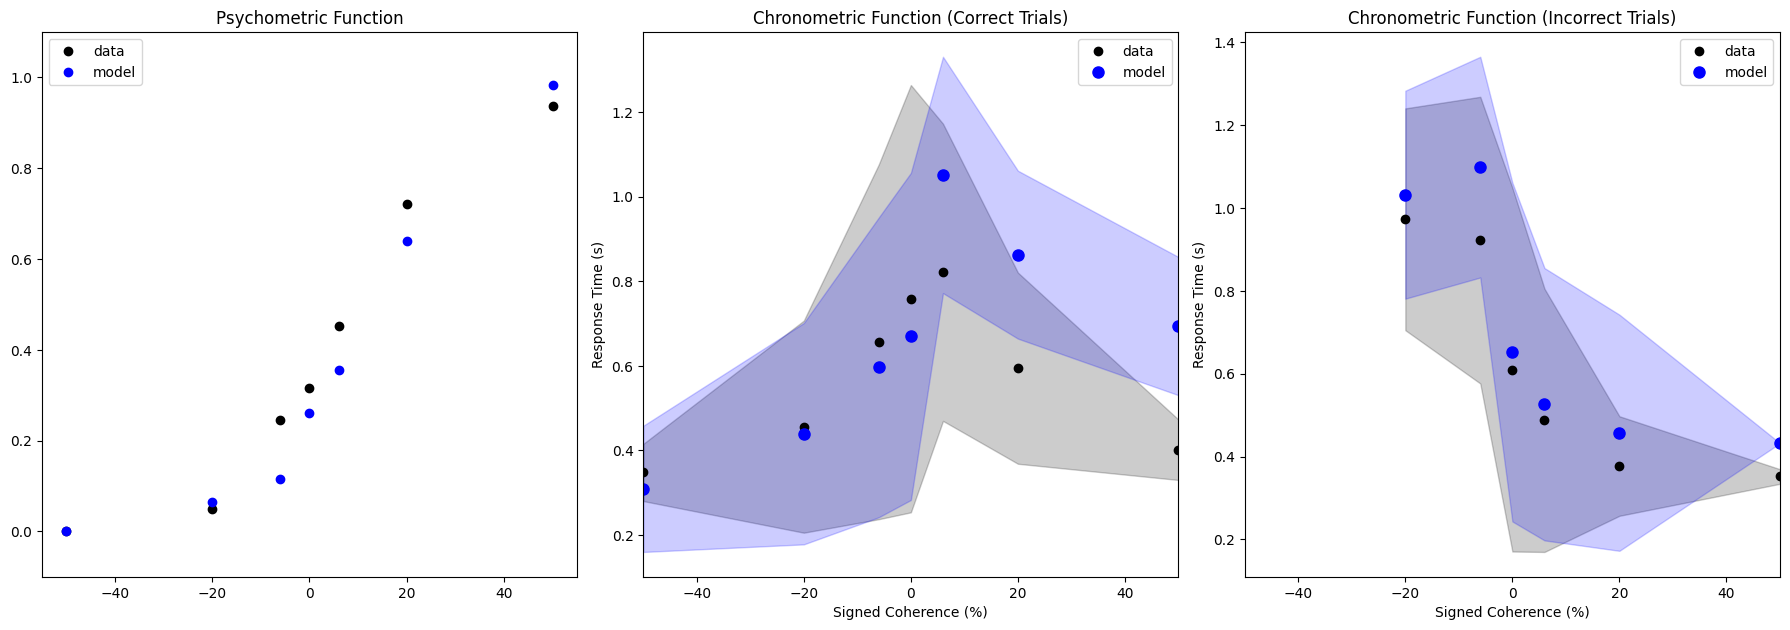

Proportion of invalid trials: 0.0

Session: 241216_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 681 trials
ndt (global): 0.1002
drift_gain (global): 5.2552
variance (global): 2.6969
a (prior 2): 4.9141
z (prior 2): 0.2580
drift_offset (prior 2): 0.7832
leak_rate (global): 0.6256
time_constant (global): 0.0037

Simulation completed. Generated 681 trials.
Valid simulated trials: 681


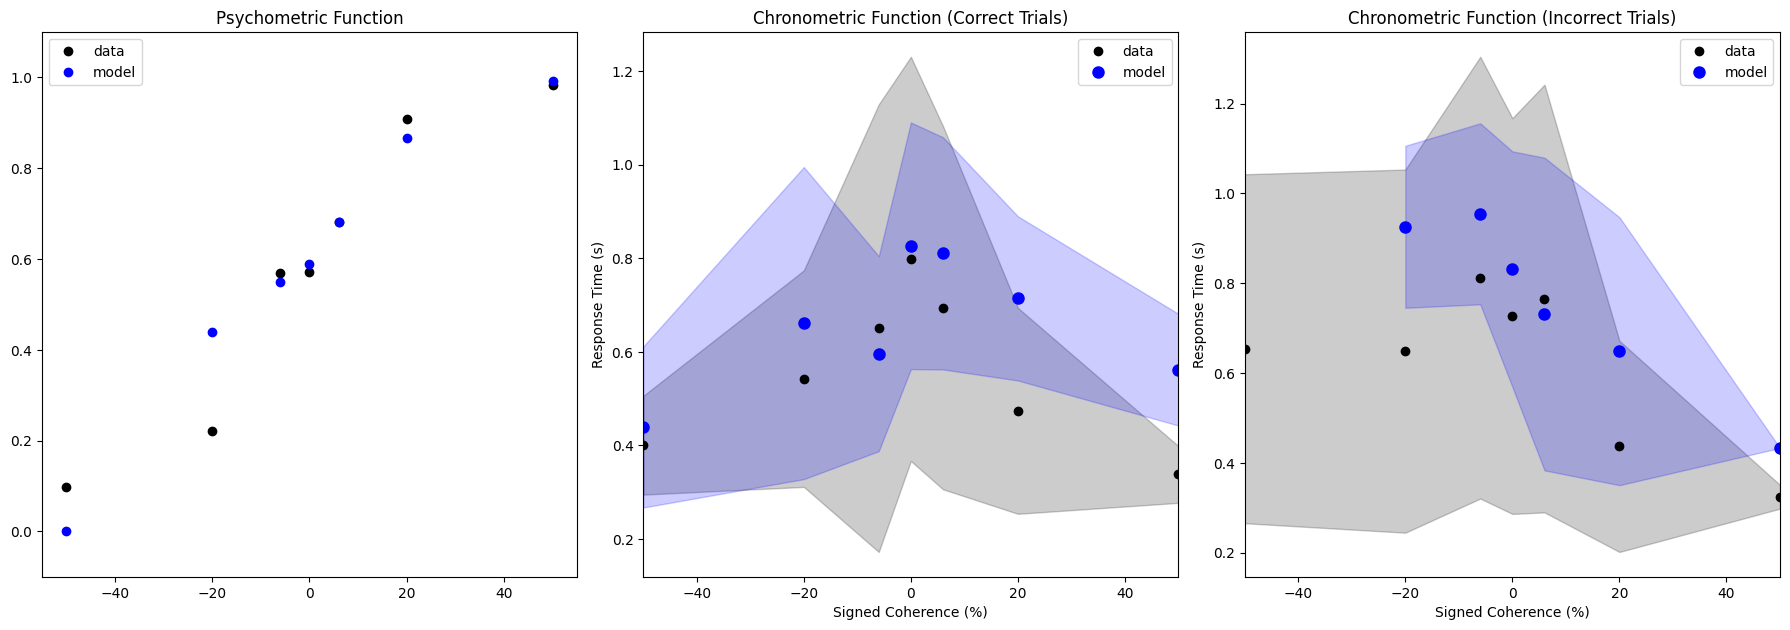

Proportion of invalid trials: 0.0

Session: 250109_GP_TZ, Prior: equal (idx: 0)
Prior condition 'equal' has 500 trials
ndt (global): 0.1129
drift_gain (global): 4.9653
variance (global): 1.1699
a (prior 1): 3.9774
z (prior 1): 0.2887
drift_offset (prior 1): 1.6513
leak_rate (global): 0.7661
time_constant (global): 0.0028

Simulation completed. Generated 500 trials.
Valid simulated trials: 500


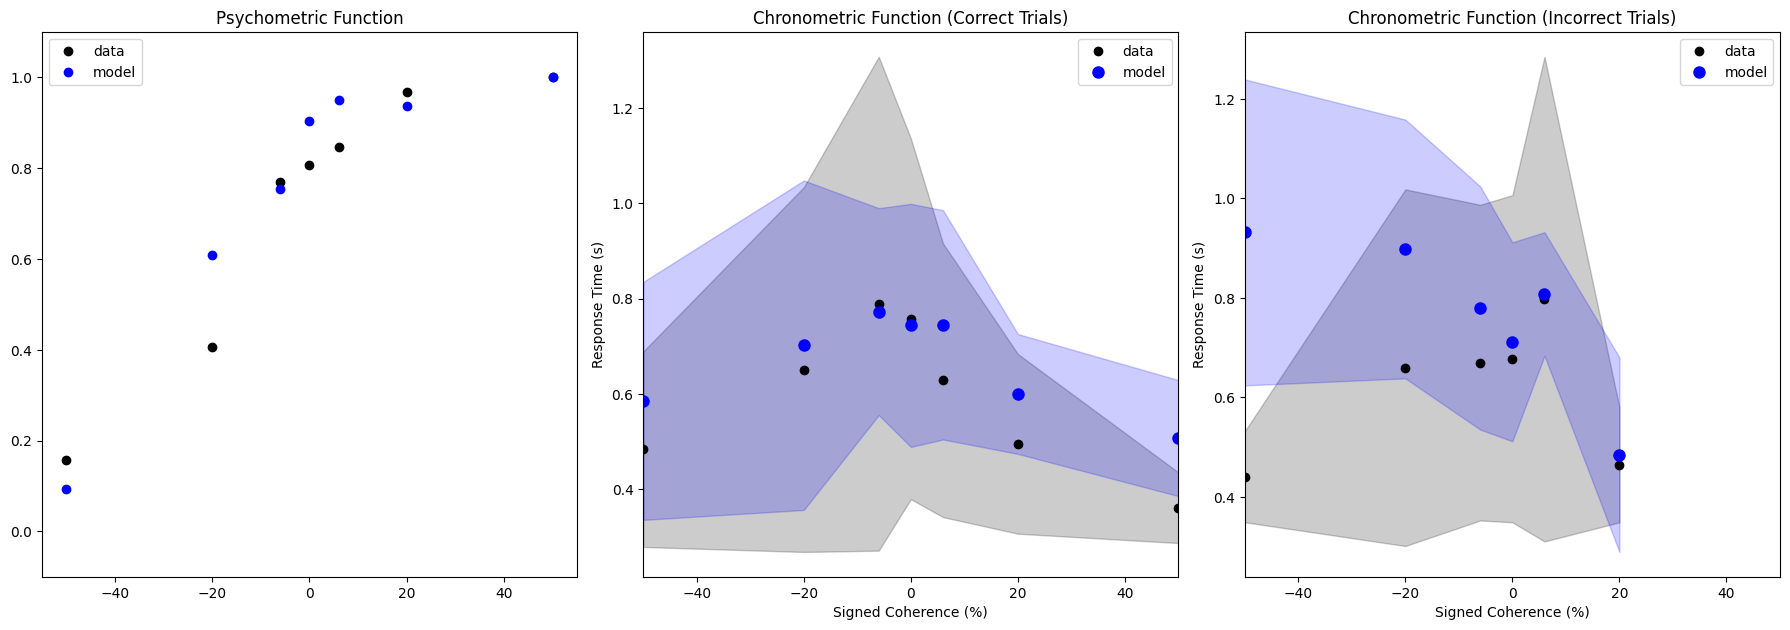

Proportion of invalid trials: 0.0

Session: 250109_GP_TZ, Prior: unequal (idx: 1)
Prior condition 'unequal' has 677 trials
ndt (global): 0.1129
drift_gain (global): 4.9653
variance (global): 1.1699
a (prior 2): 4.9343
z (prior 2): 0.1952
drift_offset (prior 2): 0.1564
leak_rate (global): 0.7661
time_constant (global): 0.0028

Simulation completed. Generated 677 trials.
Valid simulated trials: 676


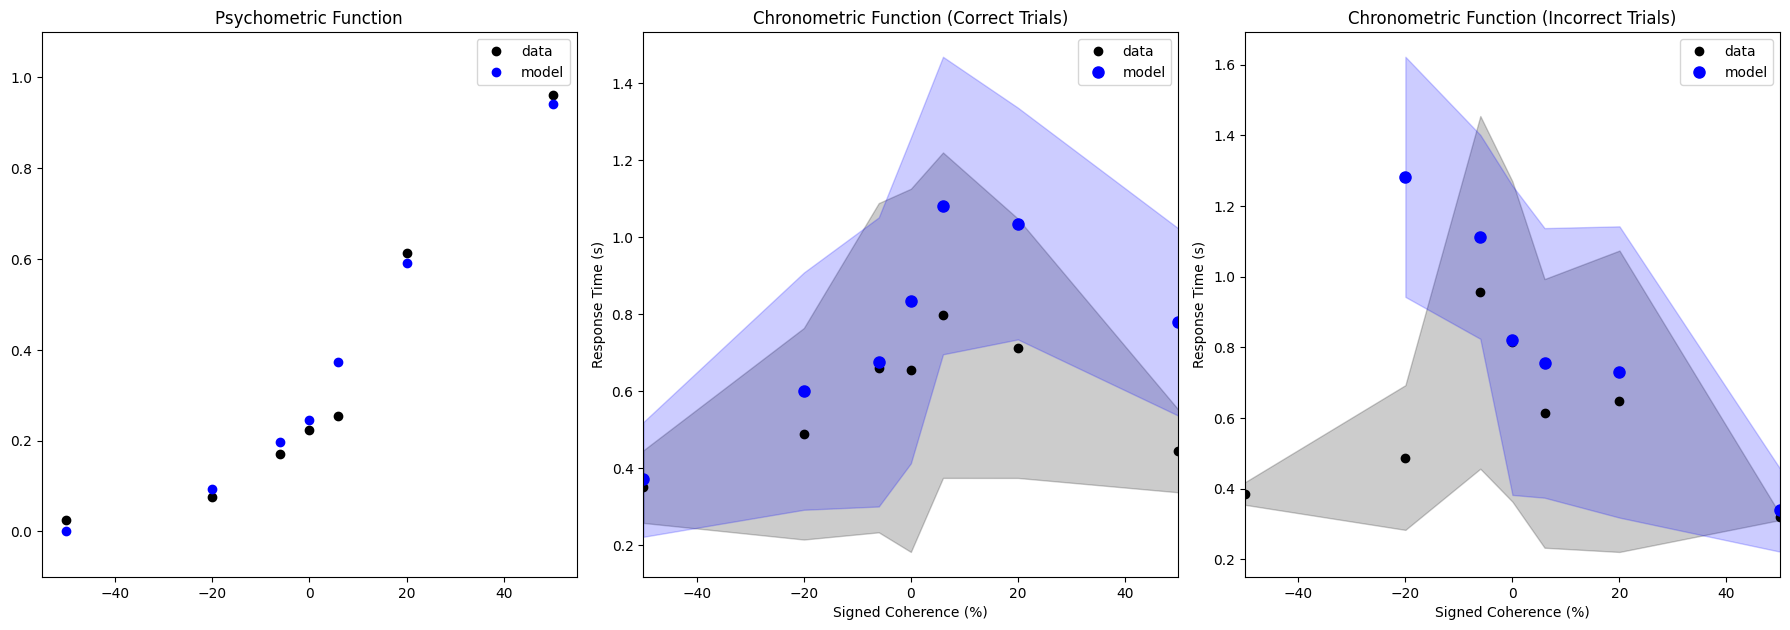

Proportion of invalid trials: 0.0014771048744460858


In [110]:
for f in model_files:
    with open(f, "rb") as pkl_file:
        model_dict = pickle.load(pkl_file)
    session_id = model_dict["session_id"]

    if session_id not in behavior_df["session_id"].unique():
        print(f"Session ID {session_id} not found in behavior data. Skipping.")
        continue

    session_data = behavior_df[behavior_df["session_id"] == session_id]
    data = session_data[["signed_coherence", "choice", "rt", "prior_block", "outcome"]]

    # Get stimulus length
    stimulus_length = int(np.max(data["rt"]) * 1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100

    # Simulate and plot for each prior condition
    for idx_prior, prior in enumerate(["equal", "unequal"]):
        print(f"\n{'=' * 50}")
        print(f"Session: {session_id}, Prior: {prior} (idx: {idx_prior})")
        print(f"{'=' * 50}")

        # Filter data and stimulus for this prior condition
        prior_mask = data["prior_block"] == prior
        prior_data = data[prior_mask].reset_index(drop=True)
        prior_stimulus = stimulus[prior_mask]

        if len(prior_data) == 0:
            print(f"No data found for prior condition: {prior}")
            continue

        print(f"Prior condition '{prior}' has {len(prior_data)} trials")

        # Simulate with parameters fitted for this prior condition
        model_sim = simulate_ddm(idx_prior, model_dict["models"], model_dict["results"], prior_stimulus)

        print(f"\nSimulation completed. Generated {len(model_sim)} trials.")
        print(f"Valid simulated trials: {np.sum(~np.isnan(model_sim['choice']))}")

        # Plot comparison
        plot_ddm_fit(model_sim, prior_data)


In [105]:
rows = []
for f in model_files:
    with open(f, "rb") as pkl_file:
        model_dict = pickle.load(pkl_file)
    session_id = model_dict["session_id"]

    if session_id not in behavior_df["session_id"].unique():
        print(f"Session ID {session_id} not found in behavior data. Skipping.")
        continue

    row = {"session_id": session_id, "prior_direction": behavior_df.loc[behavior_df.session_id == session_id, "prior_direction"].iloc[0]}
    row.update(model_dict["results"]["parameters"])
    if row["prior_direction"] == "L":
        row["z_1"] = 1 - row["z_1"]
        row["drift_offset_1"] = -row["drift_offset_1"]
        row["z_2"] = 1 - row["z_2"]
        row["drift_offset_2"] = -row["drift_offset_2"]
    rows.append(row)

params = pd.DataFrame(rows)


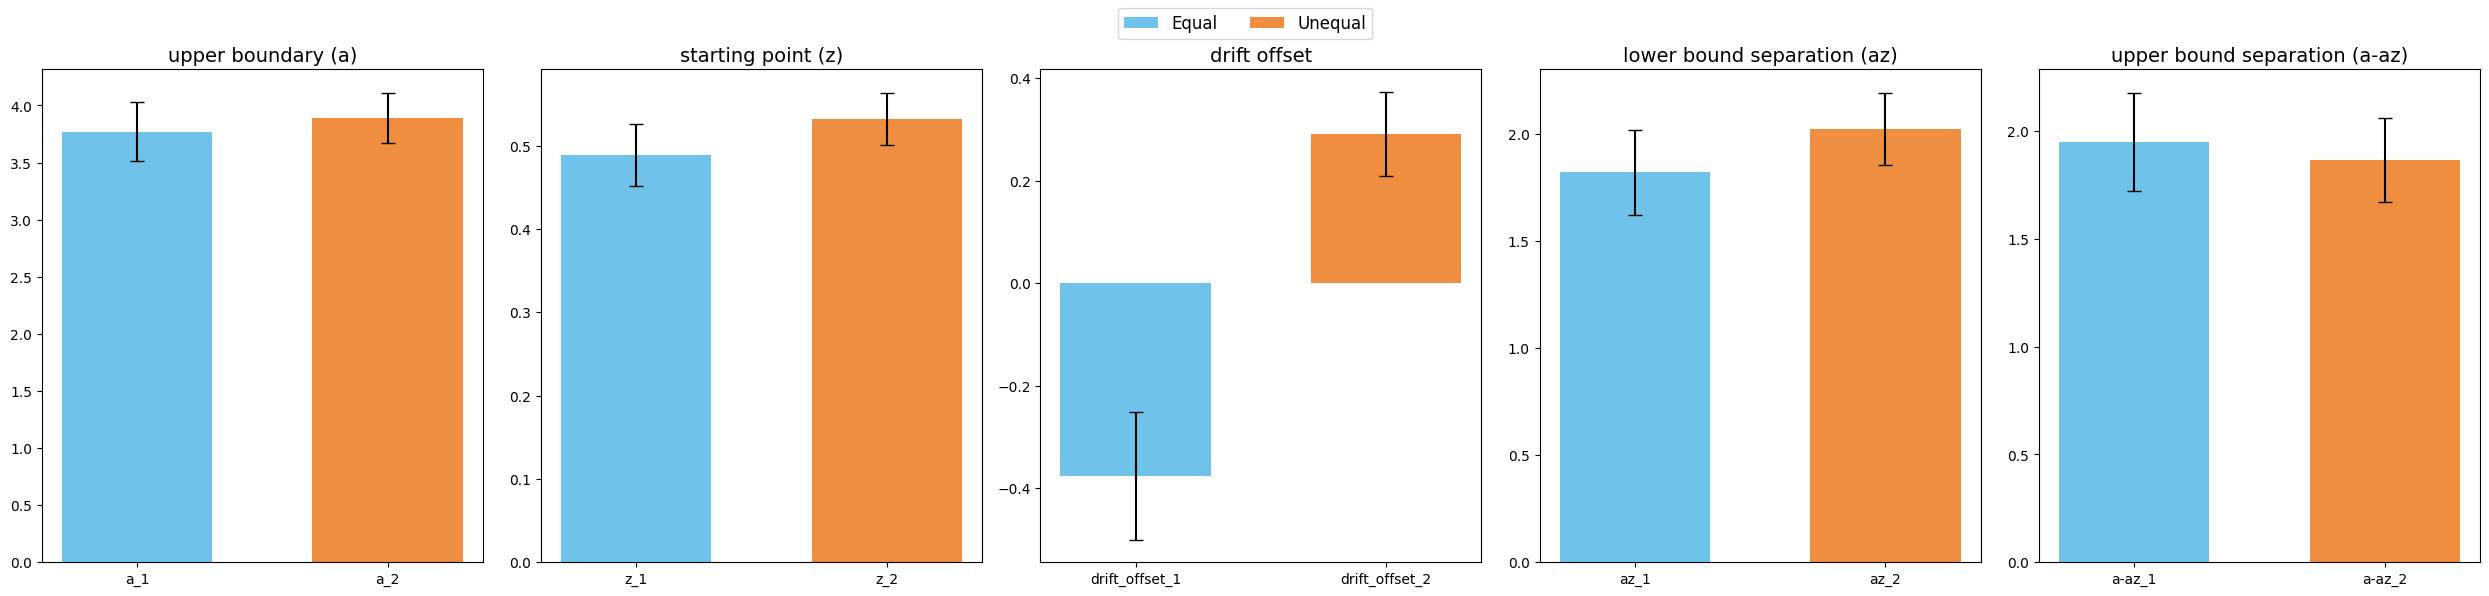

In [ ]:
params_to_plot = ["a", "z", "drift_offset", "az", "a-az"]
param_names = ["upper boundary (a)", "starting point (z)", "drift offset", "lower bound separation (az)", "upper bound separation (a-az)"]
colors = {"Equal": "#6FC3EB", "Unequal": "#EF8D41"}

nrows, ncols = 1, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 6 * nrows))

for idx_param, param_name in enumerate(params_to_plot):
    if nrows > 1:
        ax = axs[idx_param // ncols, idx_param % ncols]
    else:
        ax = axs[idx_param % ncols]
    if param_name == "az":
        params["az_1"] = params["a_1"] * params["z_1"]
        params["az_2"] = params["a_2"] * params["z_2"]
    elif param_name == "a-az":
        params["az_1"] = params["a_1"] * params["z_1"]
        params["az_2"] = params["a_2"] * params["z_2"]
        params["a-az_1"] = params["a_1"] - params["az_1"]
        params["a-az_2"] = params["a_2"] - params["az_2"]
    param_1 = f"{param_name}_1"
    param_2 = f"{param_name}_2"

    means_1 = params[param_1].mean()
    sems_1 = sem(params[param_1])
    means_2 = params[param_2].mean()
    sems_2 = sem(params[param_2])

    ax.bar(0, means_1, yerr=sems_1, capsize=5, width=0.6, color=colors["Equal"], label="Equal")
    ax.bar(1, means_2, yerr=sems_2, capsize=5, width=0.6, color=colors["Unequal"], label="Unequal")

    ax.set_xticks([0, 1])
    ax.set_xticklabels([param_1, param_2])
    ax.set_title(param_names[idx_param], fontsize=14)

# one shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()
